# NIC Division 14 - Manufacture of Wearing Apparel (India)
## Structural Transformation Analysis: 1973-2024

**Blocks:**
- 0 - Data Preparation (load, harmonise, deflate)
- 1 - All-India Long-Run Analysis (growth, breaks, productivity)
- 2 - Employment, Wages, and Labour Structure
- 3 - Regional Concentration and State-Level Panel
- 4 - Price Dynamics, GVC Context, and Policy Synthesis

**Deflation:**
- Output-side: WPI Wearing Apparel (2016 = 100)
- Wage-side: CPI-IW Linked Series (rebased to 2011-12 = 100)

In [53]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from pathlib import Path
from scipy import stats
import ruptures as rpt

print('All imports successful.')

All imports successful.


In [54]:
# Safe defaults for notebook display
plt.rcParams['figure.figsize'] = (10, 6)   # inches
plt.rcParams['figure.dpi'] = 120            # display DPI
plt.rcParams['savefig.dpi'] = 150           # saved file DPI


In [55]:
# Configuration
BASE_DIR = Path(r"c:\Users\user\Downloads\EPWRF Clone\epwrf_downloader\division 14")
OUTPUT_DIR = BASE_DIR / "output"
OUTPUT_DIR.mkdir(exist_ok=True)
FIG_DIR = OUTPUT_DIR / "figures"
FIG_DIR.mkdir(exist_ok=True)
TABLE_DIR = OUTPUT_DIR / "tables"
TABLE_DIR.mkdir(exist_ok=True)

# Plot style
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'figure.dpi': 150,
    'savefig.dpi': 125,          # cap saved figures: 16 in × 125 = 2000 px max
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 12,
    'legend.fontsize': 10,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.grid': True,
    'grid.alpha': 0.3,
})

# Policy break years (for vertical lines on charts)
POLICY_BREAKS = {
    1991: 'Liberalisation',
    2001: 'De-reservation',
    2005: 'MFA End',
    2017: 'GST',
    2020: 'COVID',
    2021: 'PLI Scheme',
}

# Era definitions for periodization
ERAS = {
    'Era I: Protection & MFA (1973-1990)':   (1973, 1990),
    'Era II: Liberalisation (1991-2000)':     (1991, 2000),
    'Era III: De-reservation & MFA End (2001-2007)': (2001, 2007),
    'Era IV: Post-Quota Adjustment (2008-2019)':     (2008, 2019),
    'Era V: COVID & PLI (2020-2024)':                (2020, 2024),
}

print('Configuration set.')

Configuration set.


---
# BLOCK 0: DATA PREPARATION

In [56]:
# Helper: parse fiscal year string to start year integer
def parse_fiscal_year(fy_str):
    """Convert '1973 - 1974' to 1973 or '1973-74' to 1973."""
    fy_str = str(fy_str).strip()
    if ' - ' in fy_str:
        return int(fy_str.split(' - ')[0])
    elif '-' in fy_str:
        return int(fy_str.split('-')[0])
    return int(fy_str)

# Helper: add policy break lines to axes (BOLD for presentation)
def add_policy_lines(ax):
    """Add vertical dashed lines at policy break years, bold for presentations."""
    for yr, label in POLICY_BREAKS.items():
        ax.axvline(yr, color='black', linestyle='--', alpha=0.85, linewidth=2.5)
        ylims = ax.get_ylim()
        y_pos = ylims[0] + (ylims[1] - ylims[0]) * 0.95
        ax.text(yr + 0.3, y_pos, label, rotation=90, fontsize=12,
                va='top', ha='left', color='black', alpha=0.9,
                fontweight='bold')

print('Helpers defined.')

Helpers defined.


In [57]:
# 0.1 Load sub02 (All-India, 2-digit concordance)
print('[0.1] Loading sub02_nic14_wide.csv...')
sub02 = pd.read_csv(BASE_DIR / 'sub02_nic14_wide.csv')
sub02['YearStart'] = sub02['Year'].apply(parse_fiscal_year)
sub02 = sub02.sort_values('YearStart').reset_index(drop=True)
print(f'  Shape: {sub02.shape}  |  Years: {sub02["YearStart"].min()}-{sub02["YearStart"].max()}')
sub02.head(3)

[0.1] Loading sub02_nic14_wide.csv...
  Shape: (51, 70)  |  Years: 1973-2023


Year      State  Addition in Stock of Finished Goods  \
0  1973 - 1974  All India                                  NaN   
1  1974 - 1975  All India                                  NaN   
2  1975 - 1976  All India                                  NaN   

   Addition in Stock of Materials, Fuels, etc.  \
0                                          NaN   
1                                          NaN   
2                                          NaN   

   Addition in Stock of Semi-Finished Goods  Additions to Total Stock  \
0                                       NaN                       NaN   
1                                       NaN                       NaN   
2                                       NaN                       NaN   

   Bonus to All Staff  Contribution to Provident and Other Funds  \
0                 NaN                                        NaN   
1                 NaN                                        NaN   
2                 NaN                                        NaN   

   Depreciation  Employees Other Than Workers  ...  Total Persons Engaged  \
0          1.55                           NaN  ...                    NaN   
1          1.64                           NaN  ...                    NaN   
2          2.46                           NaN  ...                    NaN   

   Unpaid family members/proprietor etc  Value of Gross Output  \
0                                   NaN                 143.97   
1                                   NaN                 153.14   
2                                   NaN                 229.16   

   Wages and Salaries - Other Employees  \
0                                   NaN   
1                                   NaN   
2                                   NaN   

   Wages and Salaries - Supervisory and Managerial Staff  \
0                                                NaN       
1                                                NaN       
2                                                NaN       

   Wages and Salaries - Total  Wages and Salaries - Workers  Working Capital  \
0                         NaN                          7.01            21.30   
1                         NaN                          7.62            22.46   
2                         NaN                         10.16            23.92   

   Workmen and Staff Welfare Expenses  YearStart  
0                                 NaN       1973  
1                                 NaN       1974  
2                                 NaN       1975  

[3 rows x 70 columns]

In [58]:
# 0.2 Load WPI deflator
print('[0.2] Loading WPI Wearing Apparel linked series...')
wpi = pd.read_csv(BASE_DIR / 'nic_14_wpi_linked_series.csv')
wpi.columns = ['Year_raw', 'WPI']
wpi['YearStart'] = wpi['Year_raw'].apply(parse_fiscal_year)
wpi = wpi[['YearStart', 'WPI']].sort_values('YearStart').reset_index(drop=True)
print(f'  Shape: {wpi.shape}  |  Years: {wpi["YearStart"].min()}-{wpi["YearStart"].max()}')
print(f'  Base 2011-12: WPI = {wpi.loc[wpi["YearStart"]==2011, "WPI"].values[0]}')
wpi.tail(5)

[0.2] Loading WPI Wearing Apparel linked series...
  Shape: (73, 2)  |  Years: 1952-2024
  Base 2011-12: WPI = 100.0


YearStart    WPI
68       2020  138.6
69       2021  143.1
70       2022  148.7
71       2023  150.8
72       2024  153.4

In [59]:
# 0.3 Load CPI-IW and compute fiscal-year averages
print('[0.3] Loading CPI-IW linked series and computing FY averages...')
cpi_raw = pd.read_csv(BASE_DIR / 'cpi_iw_linked_1960_to_2016base.csv')
cpi_raw['Date'] = pd.to_datetime(cpi_raw['Date'])
cpi_raw['Month'] = cpi_raw['Date'].dt.month
cpi_raw['Year'] = cpi_raw['Date'].dt.year
# Fiscal year: April of year t to March of year t+1, labelled as t
cpi_raw['FY'] = cpi_raw.apply(
    lambda r: r['Year'] if r['Month'] >= 4 else r['Year'] - 1, axis=1
)
cpi_fy = cpi_raw.groupby('FY')['Value_2016base'].mean().reset_index()
cpi_fy.columns = ['YearStart', 'CPI_2016base']

# Rebase CPI to 2011-12 = 100
cpi_2011_val = cpi_fy.loc[cpi_fy['YearStart'] == 2011, 'CPI_2016base'].values[0]
cpi_fy['CPI'] = (cpi_fy['CPI_2016base'] / cpi_2011_val) * 100
print(f'  FY averages computed: {len(cpi_fy)} fiscal years')
print(f'  CPI 2011-12 (2016 base): {cpi_2011_val:.4f} -> rebased to 100')
print(f'  CPI range: {cpi_fy["YearStart"].min()}-{cpi_fy["YearStart"].max()}')
cpi_fy.tail(5)

[0.3] Loading CPI-IW linked series and computing FY averages...
  FY averages computed: 56 fiscal years
  CPI 2011-12 (2016 base): 72.6852 -> rebased to 100
  CPI range: 1969-2024


YearStart  CPI_2016base         CPI
51       2020    122.025000  167.881529
52       2021    129.225000  177.787261
53       2022    136.400000  187.658599
54       2023    141.583333  194.789809
55       2024    144.711111  199.092994

In [60]:
# 0.4 Merge deflators into sub02
print('[0.4] Merging deflators with sub02...')
df = sub02.merge(wpi, on='YearStart', how='left')
df = df.merge(cpi_fy[['YearStart', 'CPI']], on='YearStart', how='left')
print(f'  WPI coverage: {df["WPI"].notna().sum()}/{len(df)} years')
print(f'  CPI coverage: {df["CPI"].notna().sum()}/{len(df)} years')

[0.4] Merging deflators with sub02...
  WPI coverage: 51/51 years
  CPI coverage: 51/51 years


In [61]:
# 0.5 Generate real variable series (constant 2011-12 prices)
print('[0.5] Generating real variable series (constant 2011-12 prices)...')

# Output-side deflation (by WPI)
wpi_vars = {
    'Gross Value Added': 'Real_GVA',
    'Net Value Added': 'Real_NVA',
    'Value of Gross Output': 'Real_Output',
    'Fixed Capital': 'Real_FixedCapital',
    'Working Capital': 'Real_WorkingCapital',
    'Invested Capital': 'Real_InvestedCapital',
    'Materials Consumed': 'Real_Materials',
    'Total Input': 'Real_TotalInput',
    'Gross Fixed Capital Formation': 'Real_GFCF',
    'Net Fixed Capital Formation': 'Real_NFCF',
    'Products and By-products': 'Real_Products',
    'Depreciation': 'Real_Depreciation',
    'Profits': 'Real_Profits',
    'Net Income': 'Real_NetIncome',
    'Productive Capital': 'Real_ProductiveCapital',
    'Physical Working Capital': 'Real_PhysicalWC',
    'Interest Paid': 'Real_InterestPaid',
    'Rent Paid': 'Real_RentPaid',
    'Fuels Consumed - Total': 'Real_Fuels',
}

for nom_col, real_col in wpi_vars.items():
    if nom_col in df.columns:
        df[real_col] = (df[nom_col] / df['WPI']) * 100

# Wage-side deflation (by CPI-IW)
cpi_vars = {
    'Total Emoluments': 'Real_Emoluments',
    'Wages and Salaries - Workers': 'Real_WagesWorkers',
    'Wages and Salaries - Supervisory and Managerial Staff': 'Real_WagesSupervisory',
    'Wages and Salaries - Total': 'Real_WagesTotal',
    'PF and Other Benefits': 'Real_PFBenefits',
    'Bonus to All Staff': 'Real_Bonus',
}

for nom_col, real_col in cpi_vars.items():
    if nom_col in df.columns:
        df[real_col] = (df[nom_col] / df['CPI']) * 100

# Verification: 2011-12 real should equal nominal
yr_2011 = df[df['YearStart'] == 2011]
if len(yr_2011) > 0 and 'Gross Value Added' in df.columns:
    nom_gva_2011 = yr_2011['Gross Value Added'].values[0]
    real_gva_2011 = yr_2011['Real_GVA'].values[0]
    if pd.notna(nom_gva_2011) and pd.notna(real_gva_2011):
        print(f'  Verification 2011-12: Nominal GVA = {nom_gva_2011:.2f}, Real GVA = {real_gva_2011:.2f} (ratio: {real_gva_2011/nom_gva_2011:.4f})')

print(f'  Real variables created: {len(wpi_vars) + len(cpi_vars)}')

[0.5] Generating real variable series (constant 2011-12 prices)...
  Verification 2011-12: Nominal GVA = 17003.33, Real GVA = 17003.33 (ratio: 1.0000)
  Real variables created: 25


In [62]:
# 0.6 Derived indicators
print('[0.6] Computing derived indicators...')

# Employment vars: sub02 Workers/Employees/TotalPersons are in '000 (thousands)
df['Workers'] = df['Number of Workers']
df['Employees'] = df['Number of Employees']
df['TotalPersons'] = df['Total Persons Engaged']

df['Factories'] = df['Number of Factories']  # absolute count

# Labour productivity: Real GVA per Worker (Rs Lakh per worker)
# GVA in Rs Crore (x100 -> Lakh), Workers in '000 (x1000 -> actual)
df['LP_GVA_Worker'] = (df['Real_GVA'] * 100) / (df['Workers'] * 1000)
df['LP_Output_Worker'] = (df['Real_Output'] * 100) / (df['Workers'] * 1000)

# Capital intensity: Real Fixed Capital per Worker (Rs Lakh per worker)
df['KI_FixedCap_Worker'] = (df['Real_FixedCapital'] * 100) / (df['Workers'] * 1000)

# Capital-Output Ratio (both Rs Crore -> dimensionless ratio)
df['CapOutputRatio'] = df['Real_FixedCapital'] / df['Real_GVA']

# Average factory size (Workers in '000 x1000 -> actual, Factories absolute)
df['WorkersPerFactory'] = df['Workers'] * 1000 / df['Factories']
df['OutputPerFactory'] = df['Real_Output'] / df['Factories']

# Input structure (shares of Gross Output, nominal, both Rs Crore -> ratio OK)
df['MaterialShare'] = df['Materials Consumed'] / df['Value of Gross Output']
df['FuelShare'] = df['Fuels Consumed - Total'] / df['Value of Gross Output']
df['EmolumentShare'] = df['Total Emoluments'] / df['Value of Gross Output']
df['DepreciationShare'] = df['Depreciation'] / df['Value of Gross Output']

# Labour share of GVA (both Rs Crore -> ratio OK)
df['LabourShareGVA'] = df['Total Emoluments'] / df['Gross Value Added']

# Profit rate (both Rs Crore -> ratio OK)
df['ProfitRate_IC'] = df['Profits'] / df['Invested Capital']
df['ProfitRate_FC'] = df['Profits'] / df['Fixed Capital']

# Investment rate (both Rs Crore -> ratio OK)
df['InvestmentRate'] = df['Gross Fixed Capital Formation'] / df['Gross Value Added']

# NVA/GVA ratio (both Rs Crore -> ratio OK)
df['NVA_GVA_Ratio'] = df['Net Value Added'] / df['Gross Value Added']

# Real wage per worker (CPI deflated, Rs Lakh per worker)
# Emoluments in Rs Crore (x100 -> Lakh), Workers in '000 (x1000 -> actual)
df['RealWagePerWorker'] = (df['Real_Emoluments'] * 100) / (df['Workers'] * 1000)

# Mandays per employee (actual mandays per actual employee)
# Mandays in Lakh (x100000 -> actual), Employees in '000 (x1000 -> actual)
# = Mandays * 100000 / (Employees * 1000) = Mandays * 100 / Employees
df['MandaysPerEmployee'] = df['Number of Mandays - Employees'] * 100 / df['Employees']

# Gender shares (from 1998 onward, both absolute -> ratio OK)
df['WomenShare'] = df['Number of Workers - Directly Employed - Women'] / df['Number of Workers - Directly Employed']
df['MenShare'] = df['Number of Workers - Directly Employed - Men'] / df['Number of Workers - Directly Employed']

# Contract worker share (contractors absolute, Workers in '000 x1000 -> actual)
df['ContractShare'] = df['Number of Workers - Employed Through Contractors'] / (df['Workers'] * 1000)

# Wage inequality: supervisory vs worker wages (per person)
# Supervisory staff is absolute, Workers in '000 (x1000 -> actual)
if 'Supervisory and Managerial Staff' in df.columns:
    df['WageRatio_Sup_Worker'] = (
        (df['Wages and Salaries - Supervisory and Managerial Staff'] / df['Supervisory and Managerial Staff'])
        / (df['Wages and Salaries - Workers'] / (df['Workers'] * 1000))
    )
else:
    df['WageRatio_Sup_Worker'] = np.nan

n_derived = len([c for c in df.columns if c.startswith('Real_') or c in [
    'LP_GVA_Worker','LP_Output_Worker','KI_FixedCap_Worker','CapOutputRatio',
    'WorkersPerFactory','OutputPerFactory','MaterialShare','FuelShare',
    'EmolumentShare','DepreciationShare','LabourShareGVA','ProfitRate_IC',
    'ProfitRate_FC','InvestmentRate','NVA_GVA_Ratio','RealWagePerWorker',
    'MandaysPerEmployee','WomenShare','MenShare','ContractShare','WageRatio_Sup_Worker']])
print(f'  Total derived indicators: {n_derived}')

[0.6] Computing derived indicators...
  Total derived indicators: 46


In [63]:
# 0.7 Variable availability matrix
print('[0.7] Building variable availability matrix...')
key_vars = [
    'Real_GVA', 'Real_NVA', 'Real_Output', 'Real_FixedCapital',
    'Workers', 'Employees', 'TotalPersons', 'Factories',
    'Real_GFCF', 'Real_Emoluments', 'Real_WagesWorkers', 'Real_Profits',
    'LP_GVA_Worker', 'KI_FixedCap_Worker', 'LabourShareGVA',
    'WomenShare', 'ContractShare', 'RealWagePerWorker',
]
avail = pd.DataFrame({
    'Variable': key_vars,
    'First Year': [df.loc[df[v].notna(), 'YearStart'].min() if v in df.columns and df[v].notna().any() else 'N/A' for v in key_vars],
    'Last Year': [df.loc[df[v].notna(), 'YearStart'].max() if v in df.columns and df[v].notna().any() else 'N/A' for v in key_vars],
    'N obs': [df[v].notna().sum() if v in df.columns else 0 for v in key_vars],
})
print(avail.to_string(index=False))
avail.to_csv(TABLE_DIR / 'TableA1_variable_availability.csv', index=False)

[0.7] Building variable availability matrix...
          Variable  First Year  Last Year  N obs
          Real_GVA        1973       2022     50
          Real_NVA        1973       2023     51
       Real_Output        1973       2023     51
 Real_FixedCapital        1973       2023     51
           Workers        1973       2023     51
         Employees        1973       2023     51
      TotalPersons        1980       2023     44
         Factories        1973       2023     51
         Real_GFCF        1979       2023     45
   Real_Emoluments        1973       2023     51
 Real_WagesWorkers        1973       2023     51
      Real_Profits        1979       2023     45
     LP_GVA_Worker        1973       2022     50
KI_FixedCap_Worker        1973       2023     51
    LabourShareGVA        1973       2022     50
        WomenShare        1998       2023     26
     ContractShare        1998       2023     26
 RealWagePerWorker        1973       2023     51


In [64]:
df[['YearStart', 'TotalPersons']]

YearStart  TotalPersons
0        1973           NaN
1        1974           NaN
2        1975           NaN
3        1976           NaN
4        1977           NaN
5        1978           NaN
6        1979           NaN
7        1980        66.661
8        1981        68.324
9        1982        69.472
10       1983        75.617
11       1984        78.663
12       1985        83.449
13       1986        81.946
14       1987       101.704
15       1988       112.188
16       1989       135.597
17       1990       146.261
18       1991       161.279
19       1992       188.312
20       1993       258.612
21       1994       301.019
22       1995       322.496
23       1996       331.765
24       1997       331.762
25       1998       337.005
26       1999       359.033
27       2000       418.535
28       2001       397.895
29       2002       426.084
30       2003       516.486
31       2004       611.305
32       2005       715.920
33       2006       876.646
34       2007       818.139
35       2008       797.878
36       2009       865.062
37       2010       872.962
38       2011       922.725
39       2012       922.950
40       2013       978.709
41       2014       988.651
42       2015      1083.149
43       2016      1137.020
44       2017      1189.520
45       2018      1197.318
46       2019      1260.628
47       2020      1042.590
48       2021      1180.573
49       2022      1320.172
50       2023      1338.856

In [65]:
# 0.8 Load sub07 (State-level panel)
print('[0.8] Loading sub07_nic14_wide.csv (state-level)...')
sub07 = pd.read_csv(BASE_DIR / 'sub07_nic14_wide.csv')
sub07['YearStart'] = sub07['Year'].apply(parse_fiscal_year)

# Drop permanently empty states
DROP_STATES = [
    'Andaman & Nicobar Islands', 'Arunachal Pradesh', 'Chandigarh',
    'Ladakh', 'Lakshadweep', 'Manipur', 'Meghalaya', 'Nagaland',
    'Sikkim', 'Tripura',
]
sub07 = sub07[~sub07['State'].isin(DROP_STATES)].copy()

# Convert Rs Lakh to Rs Crore for monetary variables
# Exclude non-monetary columns (absolute counts and physical quantities)
monetary_cols_07 = [c for c in sub07.columns if c not in [
    'Year', 'State', 'YearStart',
    'Number of Factories', 'Number of Factories in Operation',
    'Number of Workers', 'Number of Workers - Directly Employed',
    'Number of Workers - Directly Employed - Children',
    'Number of Workers - Directly Employed - Men',
    'Number of Workers - Directly Employed - Women',
    'Number of Workers - Employed Through Contractors',
    'Number of Employees', 'Employees Other Than Workers',
    'Number of Mandays - Employees',
    'Total Persons Engaged', 'Unpaid family members/proprietor etc',
    'Supervisory and Managerial Staff', 'Other Employees',
    'Fuels Consumed - Coal (Quantity)',
    'Fuels Consumed - Electricity Purchased (Quantity)',
]]
for col in monetary_cols_07:
    if col in sub07.columns:
        sub07[col] = pd.to_numeric(sub07[col], errors='coerce') / 100  # Lakh to Crore

# Merge WPI for state-level deflation
sub07 = sub07.merge(wpi, on='YearStart', how='left')
sub07 = sub07.merge(cpi_fy[['YearStart', 'CPI']], on='YearStart', how='left')

# State-level real variables
for nom_col, real_col in [
    ('Gross Value Added', 'Real_GVA'),
    ('Value of Gross Output', 'Real_Output'),
    ('Fixed Capital', 'Real_FixedCapital'),
    ('Total Emoluments', 'Real_Emoluments'),
    ('Gross Fixed Capital Formation', 'Real_GFCF'),
]:
    if nom_col in sub07.columns:
        sub07[real_col] = (sub07[nom_col] / sub07['WPI']) * 100

# State labour productivity
# sub07 Workers are ABSOLUTE (unit "-"), Real_GVA in Rs Crore (after Lakh->Crore)
# LP in Rs Lakh per worker = Real_GVA (Crore) * 100 (Lakh/Crore) / Workers (absolute)
sub07['Workers'] = sub07['Number of Workers']
sub07['LP_GVA_Worker'] = (sub07['Real_GVA'] * 100) / sub07['Workers']

print(f'  Shape: {sub07.shape}  |  States: {sub07["State"].nunique()}')
print(f'  Years: {sub07["YearStart"].min()}-{sub07["YearStart"].max()}')

# Save prepared data
df.to_csv(OUTPUT_DIR / 'sub02_prepared.csv', index=False)
sub07.to_csv(OUTPUT_DIR / 'sub07_prepared.csv', index=False)
print('\nBlock 0 complete. Prepared data saved to output/')

[0.8] Loading sub07_nic14_wide.csv (state-level)...


  Shape: (1247, 69)  |  States: 29
  Years: 1980-2023

Block 0 complete. Prepared data saved to output/


---
# BLOCK 1: ALL-INDIA LONG-RUN ANALYSIS (1973-2024)

In [66]:
# 1.1 CAGR computation by era
print('[1.1] Computing CAGR by era...')

def cagr(series, start_yr, end_yr, year_col='YearStart'):
    """Compute CAGR between two years from a dataframe."""
    d = df[df[year_col].between(start_yr, end_yr)].copy()
    d = d.dropna(subset=[series]) if series in df.columns else pd.DataFrame()
    if len(d) < 2:
        return np.nan
    v0 = d.iloc[0][series]
    v1 = d.iloc[-1][series]
    n = d.iloc[-1][year_col] - d.iloc[0][year_col]
    if v0 <= 0 or v1 <= 0 or n == 0:
        return np.nan
    return ((v1 / v0) ** (1 / n) - 1) * 100

cagr_vars = ['Real_GVA', 'Real_Output', 'Real_FixedCapital', 'Workers',
             'Employees', 'Factories', 'LP_GVA_Worker', 'KI_FixedCap_Worker',
             'Real_Emoluments', 'RealWagePerWorker']

cagr_table = []
for era_name, (start, end) in ERAS.items():
    row = {'Era': era_name}
    for v in cagr_vars:
        row[v] = cagr(v, start, end)
    cagr_table.append(row)

# Full period
row_full = {'Era': 'Full Period (1973-2024)'}
for v in cagr_vars:
    row_full[v] = cagr(v, 1973, 2023)
cagr_table.append(row_full)

cagr_df = pd.DataFrame(cagr_table).set_index('Era')
cagr_df.columns = [c.replace('Real_', 'R.').replace('_', ' ') for c in cagr_df.columns]
print('\nTable 1: CAGR (%) by Era')
cagr_df.round(2).to_csv(TABLE_DIR / 'Table1_CAGR_by_era.csv')
cagr_df.round(2)

[1.1] Computing CAGR by era...

Table 1: CAGR (%) by Era


R.GVA  R.Output  \
Era                                                              
Era I: Protection & MFA (1973-1990)            16.43     13.45   
Era II: Liberalisation (1991-2000)             14.13     15.72   
Era III: De-reservation & MFA End (2001-2007)  15.04     12.75   
Era IV: Post-Quota Adjustment (2008-2019)       6.17      5.12   
Era V: COVID & PLI (2020-2024)                 24.75     15.85   
Full Period (1973-2024)                        12.17     10.68   

                                               R.FixedCapital  Workers  \
Era                                                                      
Era I: Protection & MFA (1973-1990)                     13.89     8.83   
Era II: Liberalisation (1991-2000)                      25.82    11.50   
Era III: De-reservation & MFA End (2001-2007)           16.62    12.50   
Era IV: Post-Quota Adjustment (2008-2019)                3.87     4.39   
Era V: COVID & PLI (2020-2024)                          13.18     8.71   
Full Period (1973-2024)                                 12.82     7.68   

                                               Employees  Factories  \
Era                                                                   
Era I: Protection & MFA (1973-1990)                 8.59       5.94   
Era II: Liberalisation (1991-2000)                 11.36       6.44   
Era III: De-reservation & MFA End (2001-2007)      12.83       0.54   
Era IV: Post-Quota Adjustment (2008-2019)           4.26       6.55   
Era V: COVID & PLI (2020-2024)                      8.71       2.74   
Full Period (1973-2024)                             7.54       5.14   

                                               LP GVA Worker  \
Era                                                            
Era I: Protection & MFA (1973-1990)                     6.99   
Era II: Liberalisation (1991-2000)                      2.36   
Era III: De-reservation & MFA End (2001-2007)           2.26   
Era IV: Post-Quota Adjustment (2008-2019)               1.70   
Era V: COVID & PLI (2020-2024)                         10.41   
Full Period (1973-2024)                                 4.03   

                                               KI FixedCap Worker  \
Era                                                                 
Era I: Protection & MFA (1973-1990)                          4.65   
Era II: Liberalisation (1991-2000)                          12.85   
Era III: De-reservation & MFA End (2001-2007)                3.66   
Era IV: Post-Quota Adjustment (2008-2019)                   -0.50   
Era V: COVID & PLI (2020-2024)                               4.11   
Full Period (1973-2024)                                      4.78   

                                               R.Emoluments  RealWagePerWorker  
Era                                                                             
Era I: Protection & MFA (1973-1990)                   10.98               1.97  
Era II: Liberalisation (1991-2000)                    14.54               2.73  
Era III: De-reservation & MFA End (2001-2007)         15.09               2.30  
Era IV: Post-Quota Adjustment (2008-2019)              6.30               1.82  
Era V: COVID & PLI (2020-2024)                        12.42               3.41  
Full Period (1973-2024)                                9.76               1.93

[1.2] Plotting real GVA & output...


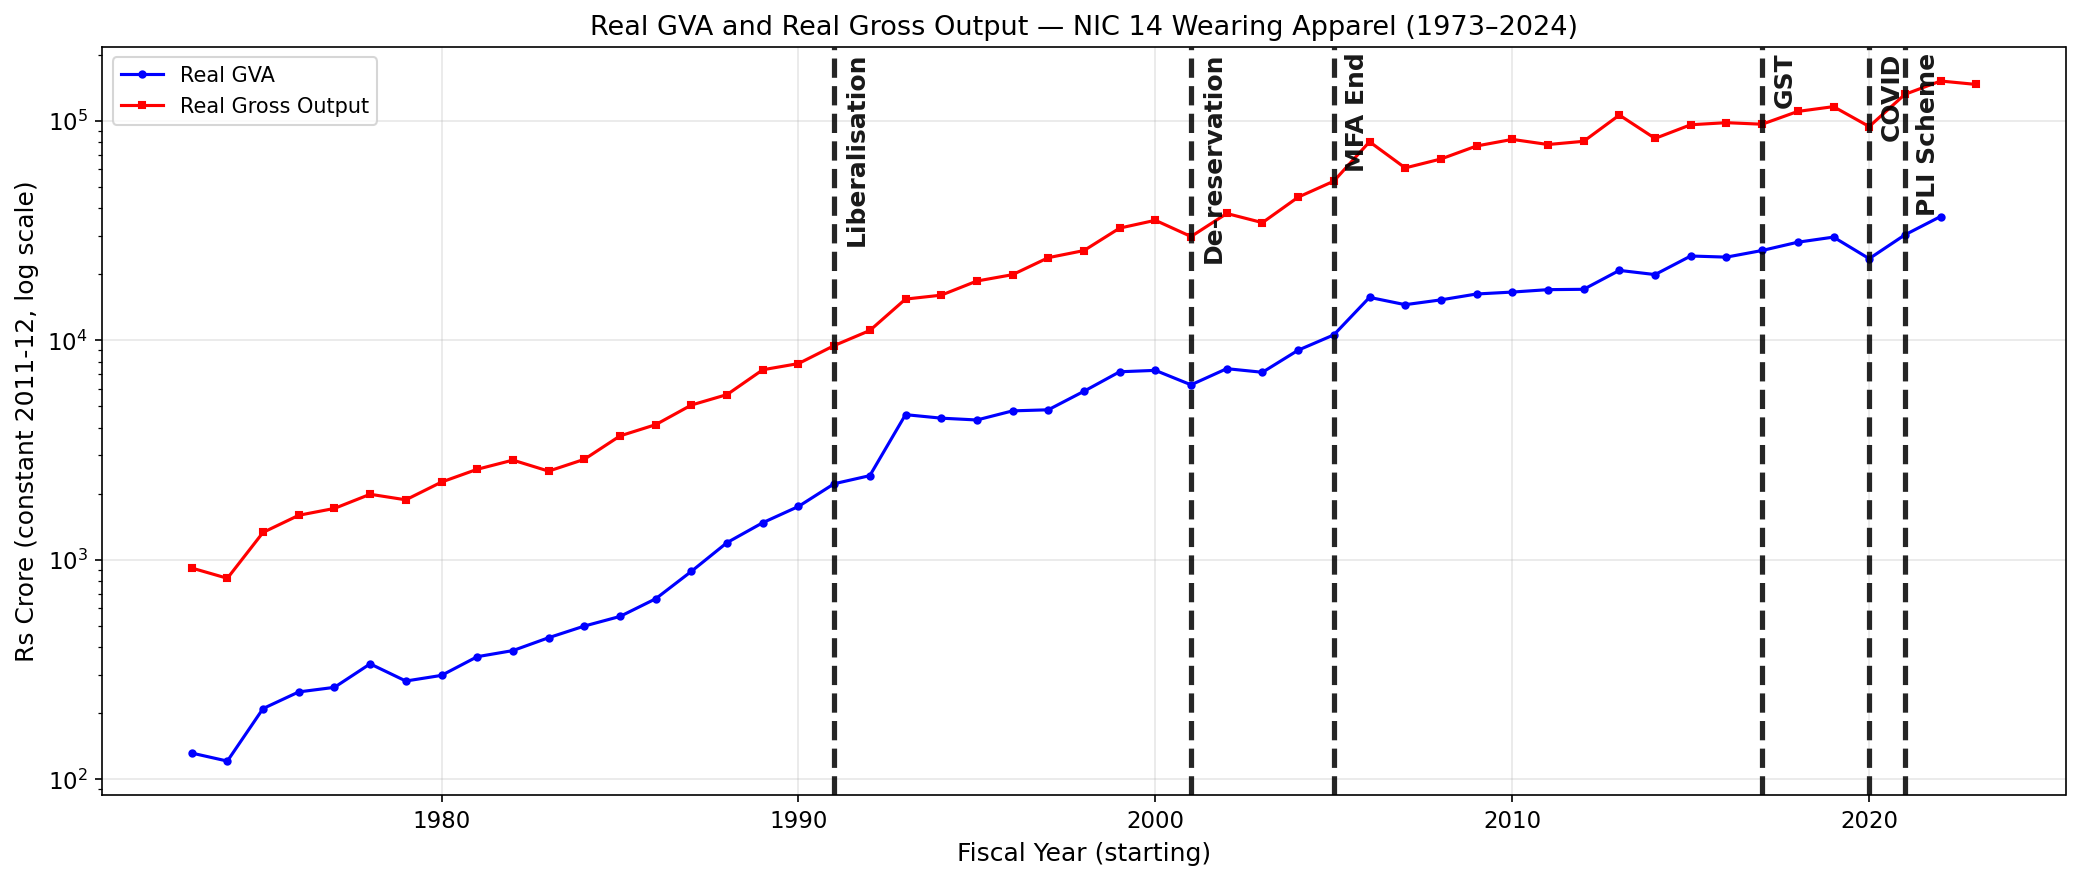

In [67]:
# 1.2 Real GVA and Real Gross Output
print('[1.2] Plotting real GVA & output...')
fig, ax1 = plt.subplots(figsize=(14, 6))
mask_gva = df['Real_GVA'].notna()
mask_out = df['Real_Output'].notna()
ax1.semilogy(df.loc[mask_gva, 'YearStart'], df.loc[mask_gva, 'Real_GVA'],
             'b-o', markersize=3, label='Real GVA', linewidth=1.5)
ax1.semilogy(df.loc[mask_out, 'YearStart'], df.loc[mask_out, 'Real_Output'],
             'r-s', markersize=3, label='Real Gross Output', linewidth=1.5)
ax1.set_xlabel('Fiscal Year (starting)')
ax1.set_ylabel('Rs Crore (constant 2011-12, log scale)')
ax1.set_title('Real GVA and Real Gross Output — NIC 14 Wearing Apparel (1973–2024)')
ax1.legend()
add_policy_lines(ax1)
plt.tight_layout()
plt.savefig(FIG_DIR / 'Fig01_RealGVA_Output.png', bbox_inches='tight')
plt.show()

[1.3] Plotting factories & employment...


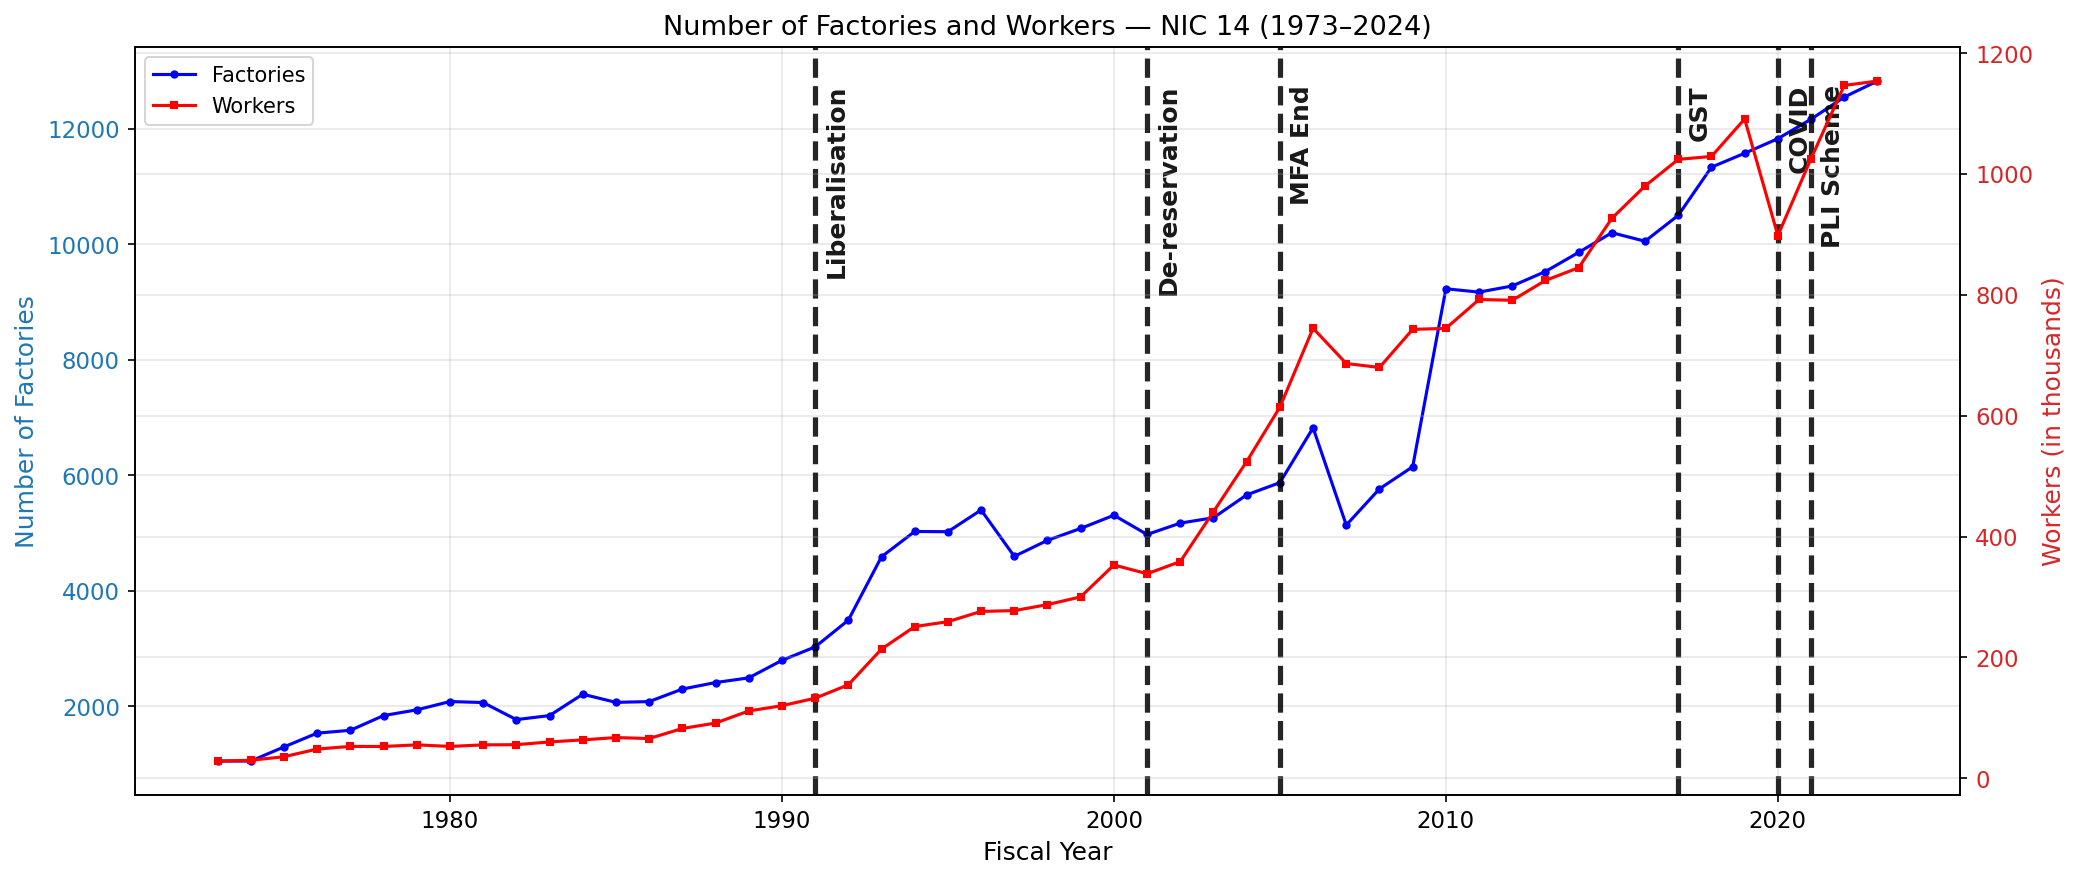

In [68]:
# 1.3 Factories and Employment
print('[1.3] Plotting factories & employment...')
fig, ax1 = plt.subplots(figsize=(14, 6))
color1 = 'tab:blue'
ax1.set_xlabel('Fiscal Year')
ax1.set_ylabel('Number of Factories', color=color1)
mask_f = df['Factories'].notna()
ax1.plot(df.loc[mask_f, 'YearStart'], df.loc[mask_f, 'Factories'],
         'b-o', markersize=3, label='Factories', linewidth=1.5)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Workers (in thousands)', color=color2)
mask_w = df['Workers'].notna()
ax2.plot(df.loc[mask_w, 'YearStart'], df.loc[mask_w, 'Workers'],
         'r-s', markersize=3, label='Workers', linewidth=1.5)
ax2.tick_params(axis='y', labelcolor=color2)

ax1.set_title('Number of Factories and Workers — NIC 14 (1973–2024)')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
add_policy_lines(ax1)
plt.tight_layout()
plt.savefig(FIG_DIR / 'Fig02_Factories_Workers.png', bbox_inches='tight')
plt.show()

[1.4] Plotting real fixed capital & GFCF...


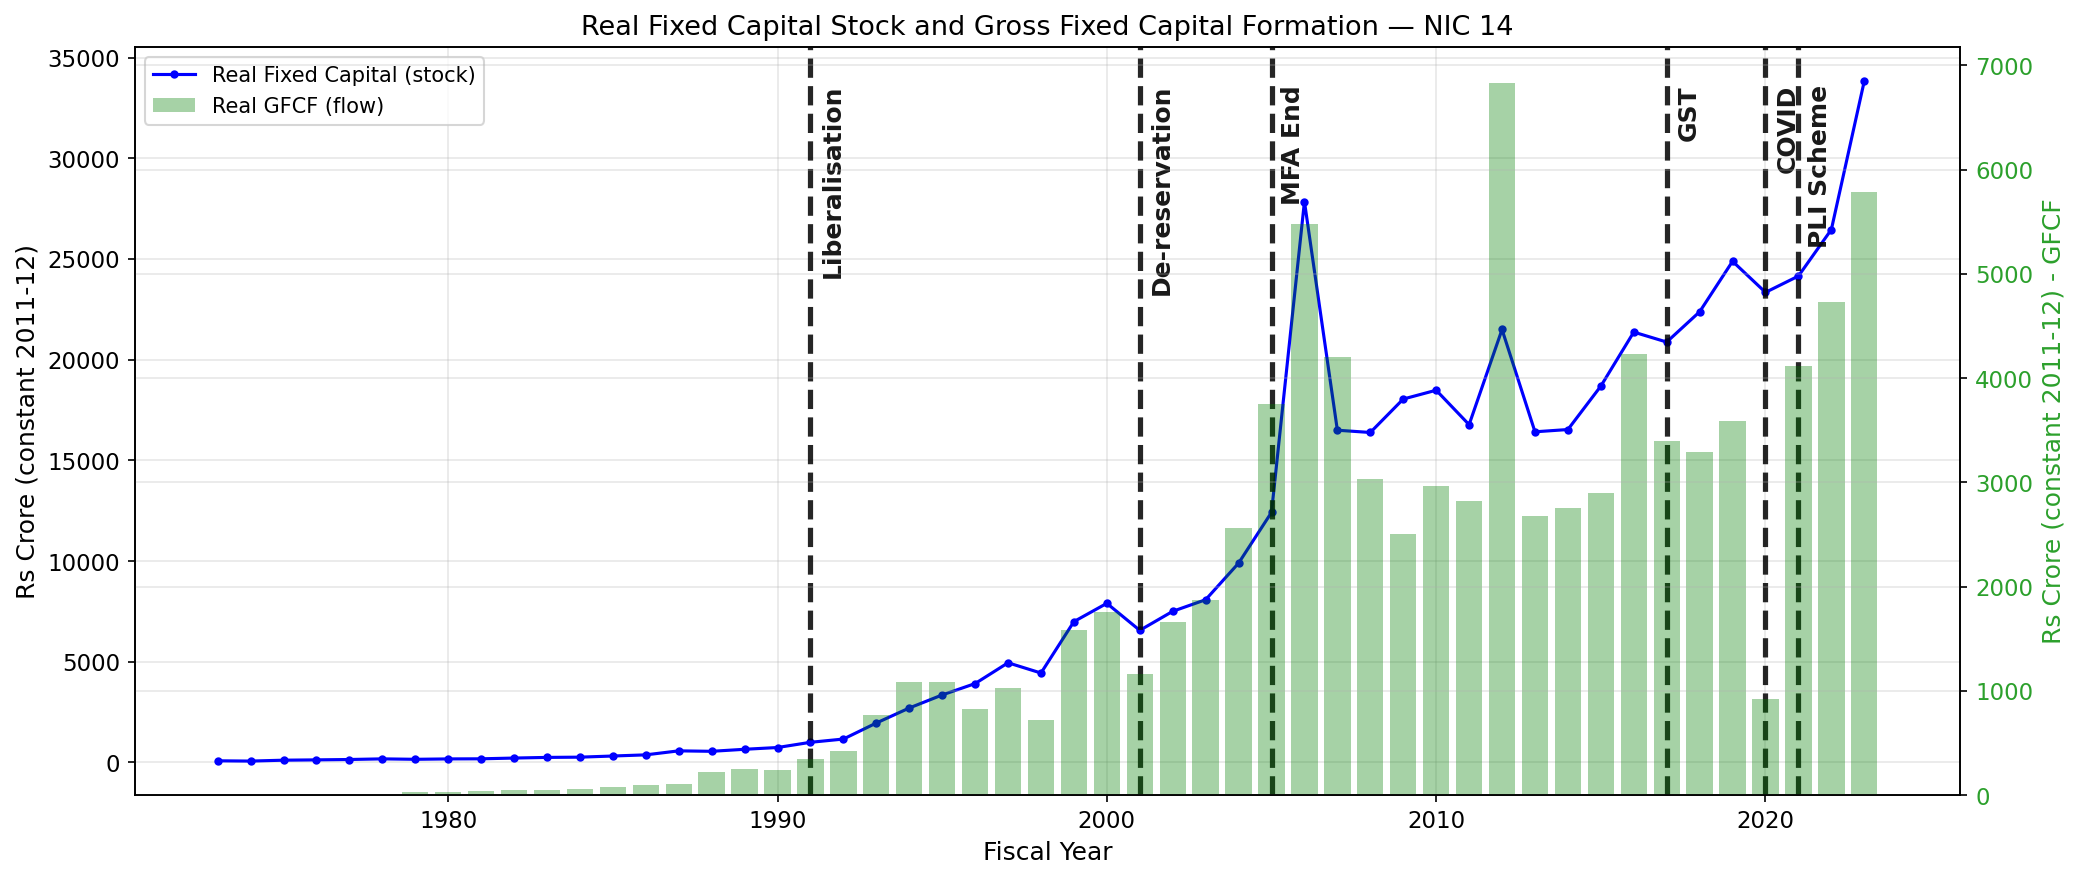

In [69]:
# 1.4 Real Fixed Capital and GFCF
print('[1.4] Plotting real fixed capital & GFCF...')
fig, ax1 = plt.subplots(figsize=(14, 6))
mask_fc = df['Real_FixedCapital'].notna()
mask_gfcf = df['Real_GFCF'].notna()
ax1.set_xlabel('Fiscal Year')
ax1.set_ylabel('Rs Crore (constant 2011-12)')
ax1.plot(df.loc[mask_fc, 'YearStart'], df.loc[mask_fc, 'Real_FixedCapital'],
         'b-o', markersize=3, label='Real Fixed Capital (stock)', linewidth=1.5)
ax2 = ax1.twinx()
ax2.set_ylabel('Rs Crore (constant 2011-12) - GFCF', color='tab:green')
ax2.bar(df.loc[mask_gfcf, 'YearStart'], df.loc[mask_gfcf, 'Real_GFCF'],
        color='green', alpha=0.35, label='Real GFCF (flow)')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax1.set_title('Real Fixed Capital Stock and Gross Fixed Capital Formation — NIC 14')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
add_policy_lines(ax1)
plt.tight_layout()
plt.savefig(FIG_DIR / 'Fig03_RealCapital_GFCF.png', bbox_inches='tight')
plt.show()

[1.5] Plotting nominal vs real GVA...


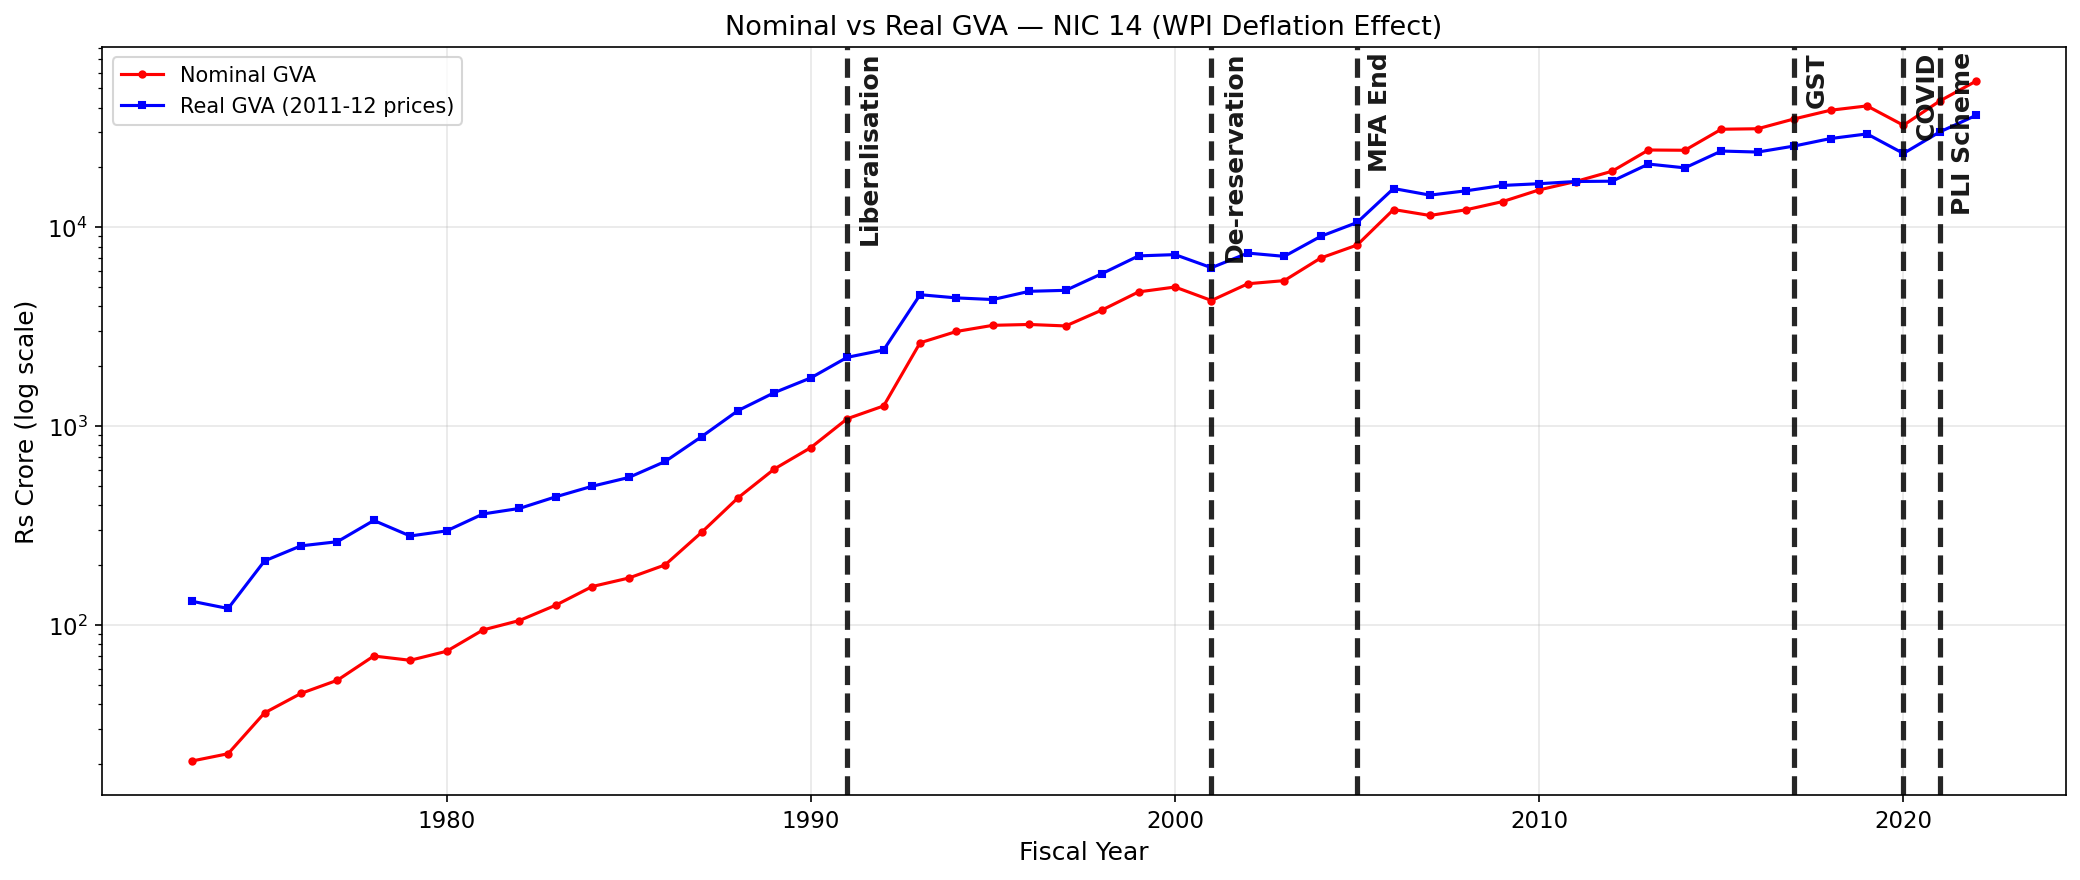

In [70]:
# 1.5 Nominal vs Real GVA
print('[1.5] Plotting nominal vs real GVA...')
fig, ax = plt.subplots(figsize=(14, 6))
mask = df['Gross Value Added'].notna() & df['Real_GVA'].notna()
ax.semilogy(df.loc[mask, 'YearStart'], df.loc[mask, 'Gross Value Added'],
            'r-o', markersize=3, label='Nominal GVA', linewidth=1.5)
ax.semilogy(df.loc[mask, 'YearStart'], df.loc[mask, 'Real_GVA'],
            'b-s', markersize=3, label='Real GVA (2011-12 prices)', linewidth=1.5)
ax.set_xlabel('Fiscal Year')
ax.set_ylabel('Rs Crore (log scale)')
ax.set_title('Nominal vs Real GVA — NIC 14 (WPI Deflation Effect)')
ax.legend()
add_policy_lines(ax)
plt.tight_layout()
plt.savefig(FIG_DIR / 'Fig04_NominalVsRealGVA.png', bbox_inches='tight')
plt.show()

In [71]:
# 1.6 Structural Break Detection — PELT change-point detection (Killick, Fearnhead & Eckley 2012)
# NOTE: This uses the PELT algorithm from the 'ruptures' library with an RBF kernel,
# NOT the Bai-Perron (2003) sequential F-test. Relabeled for methodological accuracy.
print('[1.6] PELT change-point detection (Killick, Fearnhead & Eckley 2012)...')

break_results = {}
for var_name, var_label in [
    ('LP_GVA_Worker', 'Log Labour Productivity'),
    ('KI_FixedCap_Worker', 'Log Capital Intensity'),
    ('CapOutputRatio', 'Capital-Output Ratio'),
]:
    series = df[['YearStart', var_name]].dropna()
    if len(series) < 10:
        print(f'  {var_label}: insufficient data ({len(series)} obs)')
        continue
    
    signal = np.log(series[var_name].values) if 'Log' in var_label else series[var_name].values
    signal = signal.reshape(-1, 1)
    
    try:
        algo = rpt.Pelt(model="rbf", min_size=5, jump=1).fit(signal)
        bkps = algo.predict(pen=3)
        years_at_break = [series.iloc[b - 1]['YearStart'] if b < len(series) else series.iloc[-1]['YearStart']
                          for b in bkps[:-1]]
        break_results[var_label] = years_at_break
        print(f'  {var_label}: breaks at {years_at_break}')
    except Exception as e:
        print(f'  {var_label}: ruptures failed - {e}')

# Also try on Real GVA
gva_series = df[['YearStart', 'Real_GVA']].dropna()
if len(gva_series) >= 10:
    signal_gva = np.log(gva_series['Real_GVA'].values).reshape(-1, 1)
    try:
        algo = rpt.Pelt(model="rbf", min_size=5, jump=1).fit(signal_gva)
        bkps = algo.predict(pen=3)
        years_at_break = [gva_series.iloc[b - 1]['YearStart'] if b < len(gva_series) else gva_series.iloc[-1]['YearStart']
                          for b in bkps[:-1]]
        break_results['Log Real GVA'] = years_at_break
        print(f'  Log Real GVA: breaks at {years_at_break}')
    except Exception as e:
        print(f'  Log Real GVA: ruptures failed - {e}')

# Save break results
breaks_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in break_results.items()]))
breaks_df.to_csv(TABLE_DIR / 'structural_breaks.csv', index=False)
breaks_df

[1.6] PELT change-point detection (Killick, Fearnhead & Eckley 2012)...
  Log Labour Productivity: breaks at [np.float64(1987.0), np.float64(2005.0)]
  Log Capital Intensity: breaks at [np.float64(1984.0), np.float64(1994.0)]
  Capital-Output Ratio: breaks at [np.float64(1994.0), np.float64(2012.0)]
  Log Real GVA: breaks at [np.float64(1988.0), np.float64(2004.0)]


Log Labour Productivity  Log Capital Intensity  Capital-Output Ratio  \
0                   1987.0                 1984.0                1994.0   
1                   2005.0                 1994.0                2012.0   

   Log Real GVA  
0        1988.0  
1        2004.0

In [72]:
# 1.7 Table 2: Productivity Dashboard
print('[1.7] Building Table 2: Productivity Dashboard...')
prod_vars = {
    'LP_GVA_Worker': 'Labour Productivity (Real GVA/Worker, Rs Lakh)',
    'KI_FixedCap_Worker': 'Capital Intensity (Real FK/Worker, Rs Lakh)',
    'CapOutputRatio': 'Capital-Output Ratio',
    'WorkersPerFactory': 'Avg Factory Size (Workers/Factory)',
    'MaterialShare': 'Material Intensity (Materials/Output)',
    'FuelShare': 'Fuel Intensity (Fuels/Output)',
    'InvestmentRate': 'Investment Rate (GFCF/GVA)',
    'NVA_GVA_Ratio': 'NVA/GVA Ratio',
}

prod_table = []
for era_name, (start, end) in ERAS.items():
    era_df = df[df['YearStart'].between(start, end)]
    row = {'Era': era_name}
    for var, label in prod_vars.items():
        row[label] = era_df[var].mean() if var in era_df.columns else np.nan
    prod_table.append(row)

# Full period
era_df = df[df['YearStart'].between(1973, 2023)]
row_full = {'Era': 'Full Period'}
for var, label in prod_vars.items():
    row_full[label] = era_df[var].mean() if var in era_df.columns else np.nan
prod_table.append(row_full)

prod_dashboard = pd.DataFrame(prod_table).set_index('Era')
prod_dashboard.round(3).to_csv(TABLE_DIR / 'Table2_productivity_dashboard.csv')
prod_dashboard.round(3)

[1.7] Building Table 2: Productivity Dashboard...


Labour Productivity (Real GVA/Worker, Rs Lakh)  \
Era                                                                                             
Era I: Protection & MFA (1973-1990)                                                     0.780   
Era II: Liberalisation (1991-2000)                                                      1.877   
Era III: De-reservation & MFA End (2001-2007)                                           1.886   
Era IV: Post-Quota Adjustment (2008-2019)                                               2.402   
Era V: COVID & PLI (2020-2024)                                                          2.920   
Full Period                                                                             1.672   

                                               Capital Intensity (Real FK/Worker, Rs Lakh)  \
Era                                                                                          
Era I: Protection & MFA (1973-1990)                                                  0.411   
Era II: Liberalisation (1991-2000)                                                   1.410   
Era III: De-reservation & MFA End (2001-2007)                                        2.274   
Era IV: Post-Quota Adjustment (2008-2019)                                            2.233   
Era V: COVID & PLI (2020-2024)                                                       2.549   
Full Period                                                                          1.459   

                                               Capital-Output Ratio  \
Era                                                                   
Era I: Protection & MFA (1973-1990)                           0.540   
Era II: Liberalisation (1991-2000)                            0.741   
Era III: De-reservation & MFA End (2001-2007)                 1.196   
Era IV: Post-Quota Adjustment (2008-2019)                     0.941   
Era V: COVID & PLI (2020-2024)                                0.838   
Full Period                                                   0.786   

                                               Avg Factory Size (Workers/Factory)  \
Era                                                                                 
Era I: Protection & MFA (1973-1990)                                        32.065   
Era II: Liberalisation (1991-2000)                                         53.279   
Era III: De-reservation & MFA End (2001-2007)                              94.511   
Era IV: Post-Quota Adjustment (2008-2019)                                  94.549   
Era V: COVID & PLI (2020-2024)                                             85.407   
Full Period                                                                63.681   

                                               Material Intensity (Materials/Output)  \
Era                                                                                    
Era I: Protection & MFA (1973-1990)                                            0.596   
Era II: Liberalisation (1991-2000)                                             0.532   
Era III: De-reservation & MFA End (2001-2007)                                  0.511   
Era IV: Post-Quota Adjustment (2008-2019)                                      0.495   
Era V: COVID & PLI (2020-2024)                                                 0.503   
Full Period                                                                    0.540   

                                               Fuel Intensity (Fuels/Output)  \
Era                                                                            
Era I: Protection & MFA (1973-1990)                                    0.009   
Era II: Liberalisation (1991-2000)                                     0.014   
Era III: De-reservation & MFA End (2001-2007)                          0.026   
Era IV: Post-Quota Adjustment (2008-2019)                              0.020   
Era V: COVID & PLI (2020-2024)                                         0.018   
Fu

[1.8] Plotting input cost decomposition...


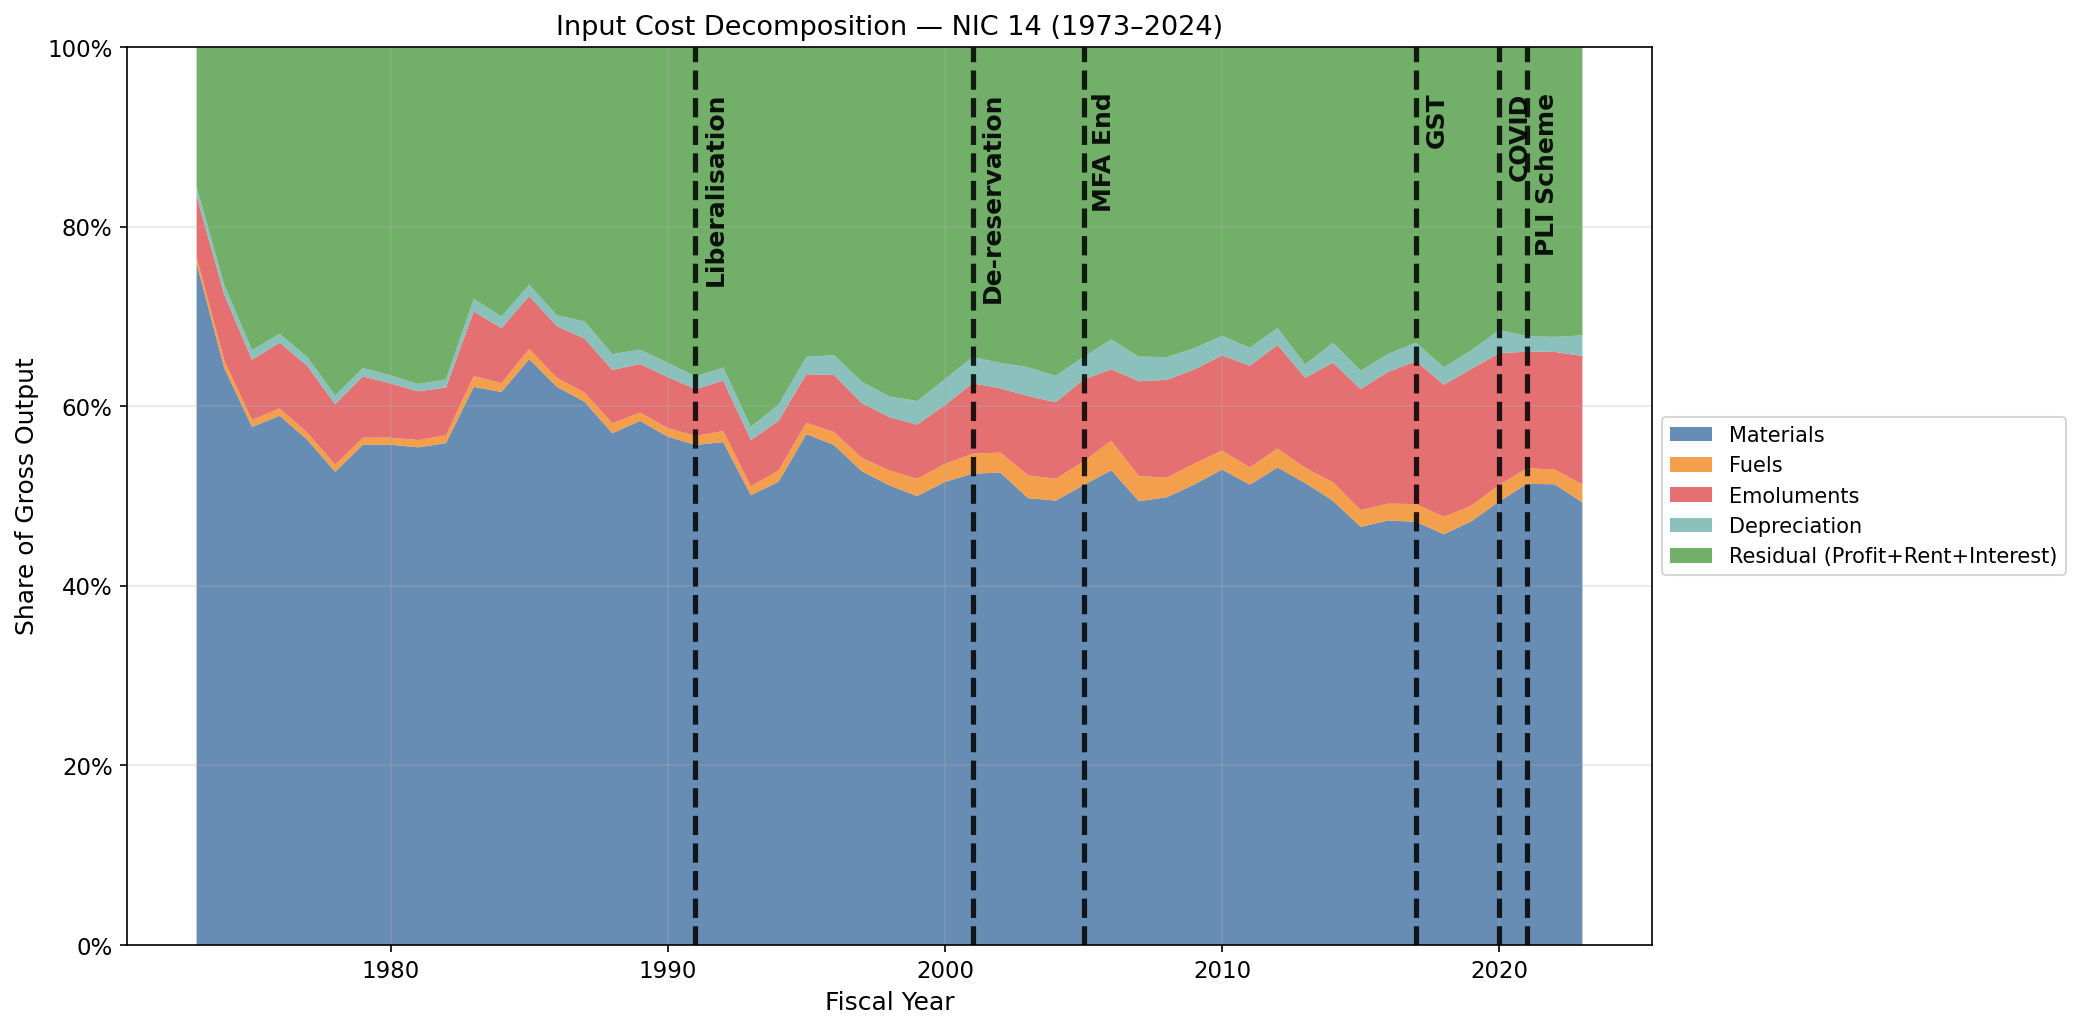

In [73]:
# 1.8 Input Cost Decomposition
print('[1.8] Plotting input cost decomposition...')
shares = df[['YearStart', 'MaterialShare', 'FuelShare', 'EmolumentShare', 'DepreciationShare']].dropna(subset=['MaterialShare'])
shares = shares.copy()
shares['Residual'] = 1 - shares[['MaterialShare', 'FuelShare', 'EmolumentShare', 'DepreciationShare']].sum(axis=1)
shares['Residual'] = shares['Residual'].clip(lower=0)

fig, ax = plt.subplots(figsize=(14, 7))
cols = ['MaterialShare', 'FuelShare', 'EmolumentShare', 'DepreciationShare', 'Residual']
labels = ['Materials', 'Fuels', 'Emoluments', 'Depreciation', 'Residual (Profit+Rent+Interest)']
colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f']
ax.stackplot(shares['YearStart'], *[shares[c] for c in cols],
             labels=labels, colors=colors, alpha=0.85)
ax.set_xlabel('Fiscal Year')
ax.set_ylabel('Share of Gross Output')
ax.set_title('Input Cost Decomposition — NIC 14 (1973–2024)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
add_policy_lines(ax)
plt.tight_layout()
plt.savefig(FIG_DIR / 'Fig05_InputCostDecomposition.png', bbox_inches='tight')
plt.show()

[1.9] Plotting Figure: Labour productivity & Capital intensity...


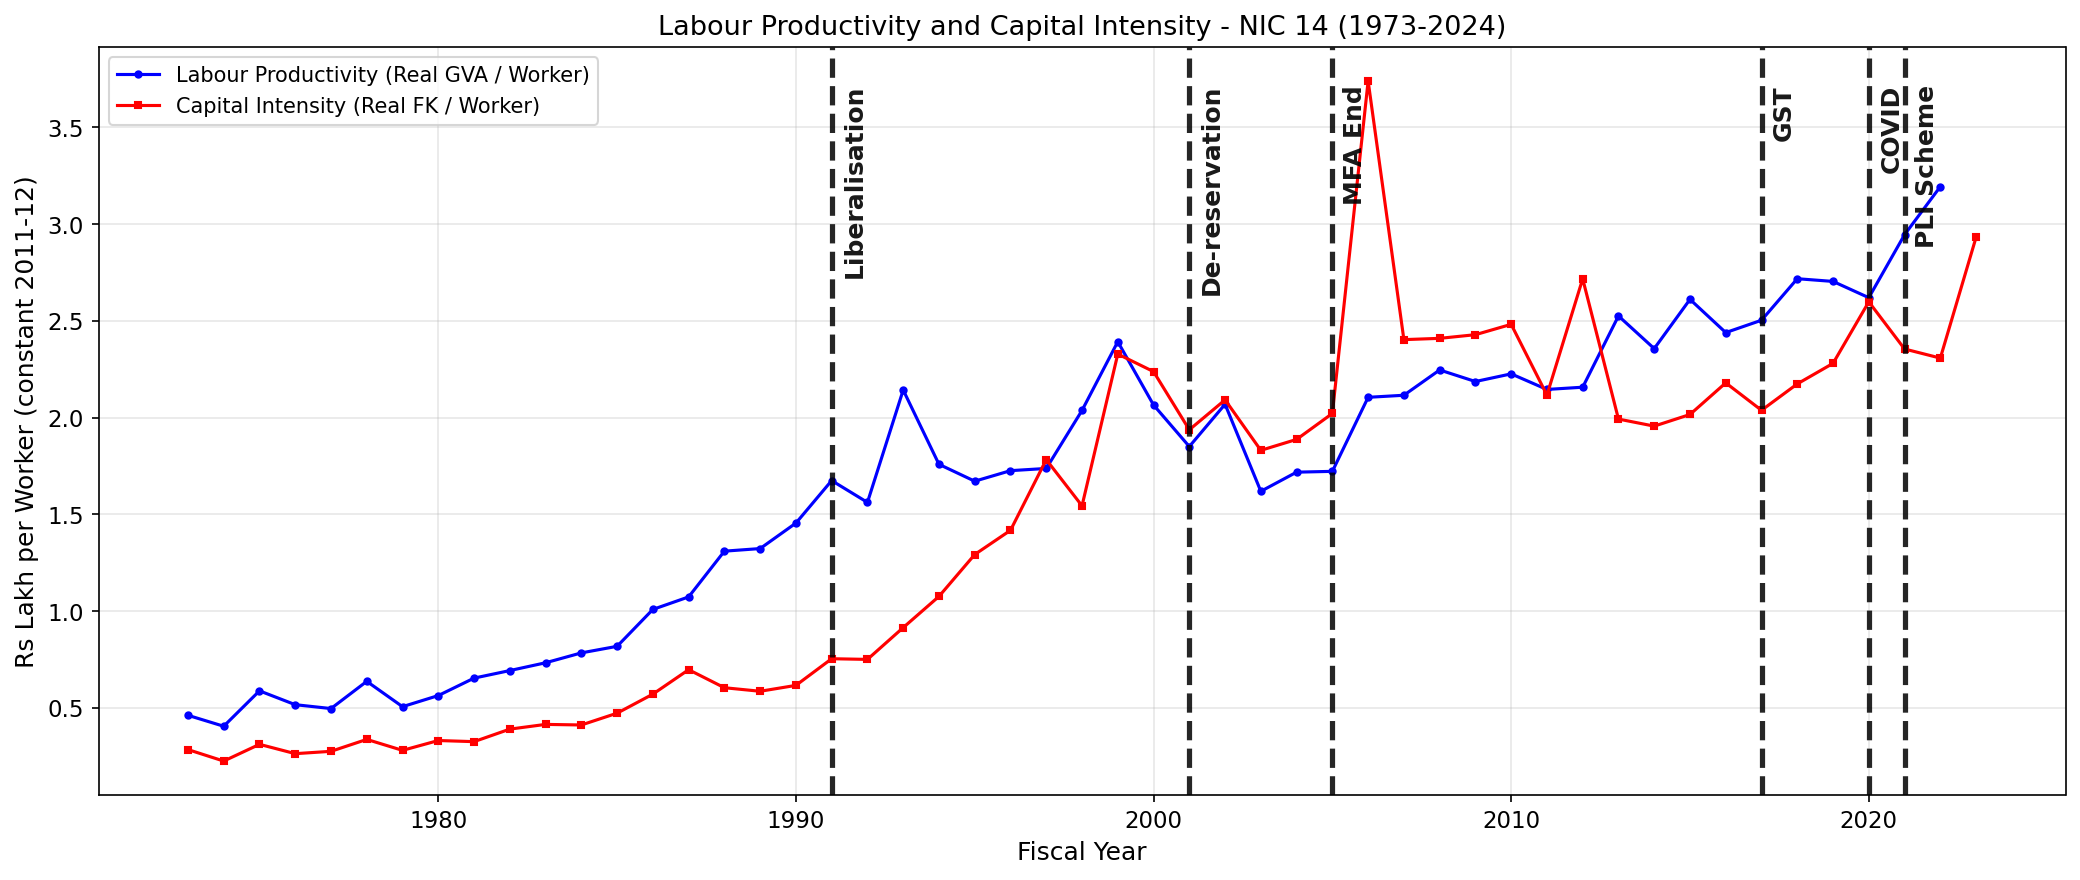

In [74]:
# 1.9 Figure: Productivity trends
print('[1.9] Plotting Figure: Labour productivity & Capital intensity...')
fig, ax1 = plt.subplots(figsize=(14, 6))
mask_lp = df['LP_GVA_Worker'].notna()
mask_ki = df['KI_FixedCap_Worker'].notna()
ax1.plot(df.loc[mask_lp, 'YearStart'], df.loc[mask_lp, 'LP_GVA_Worker'],
         'b-o', markersize=3, label='Labour Productivity (Real GVA / Worker)', linewidth=1.5)
ax1.plot(df.loc[mask_ki, 'YearStart'], df.loc[mask_ki, 'KI_FixedCap_Worker'],
         'r-s', markersize=3, label='Capital Intensity (Real FK / Worker)', linewidth=1.5)
ax1.set_xlabel('Fiscal Year')
ax1.set_ylabel('Rs Lakh per Worker (constant 2011-12)')
ax1.set_title('Labour Productivity and Capital Intensity - NIC 14 (1973-2024)')
ax1.legend()
add_policy_lines(ax1)
plt.tight_layout()
plt.savefig(FIG_DIR / 'Fig_Productivity_CapitalIntensity.png', bbox_inches='tight')
plt.show()

[1.10] Plotting: Profit rate & Investment rate...


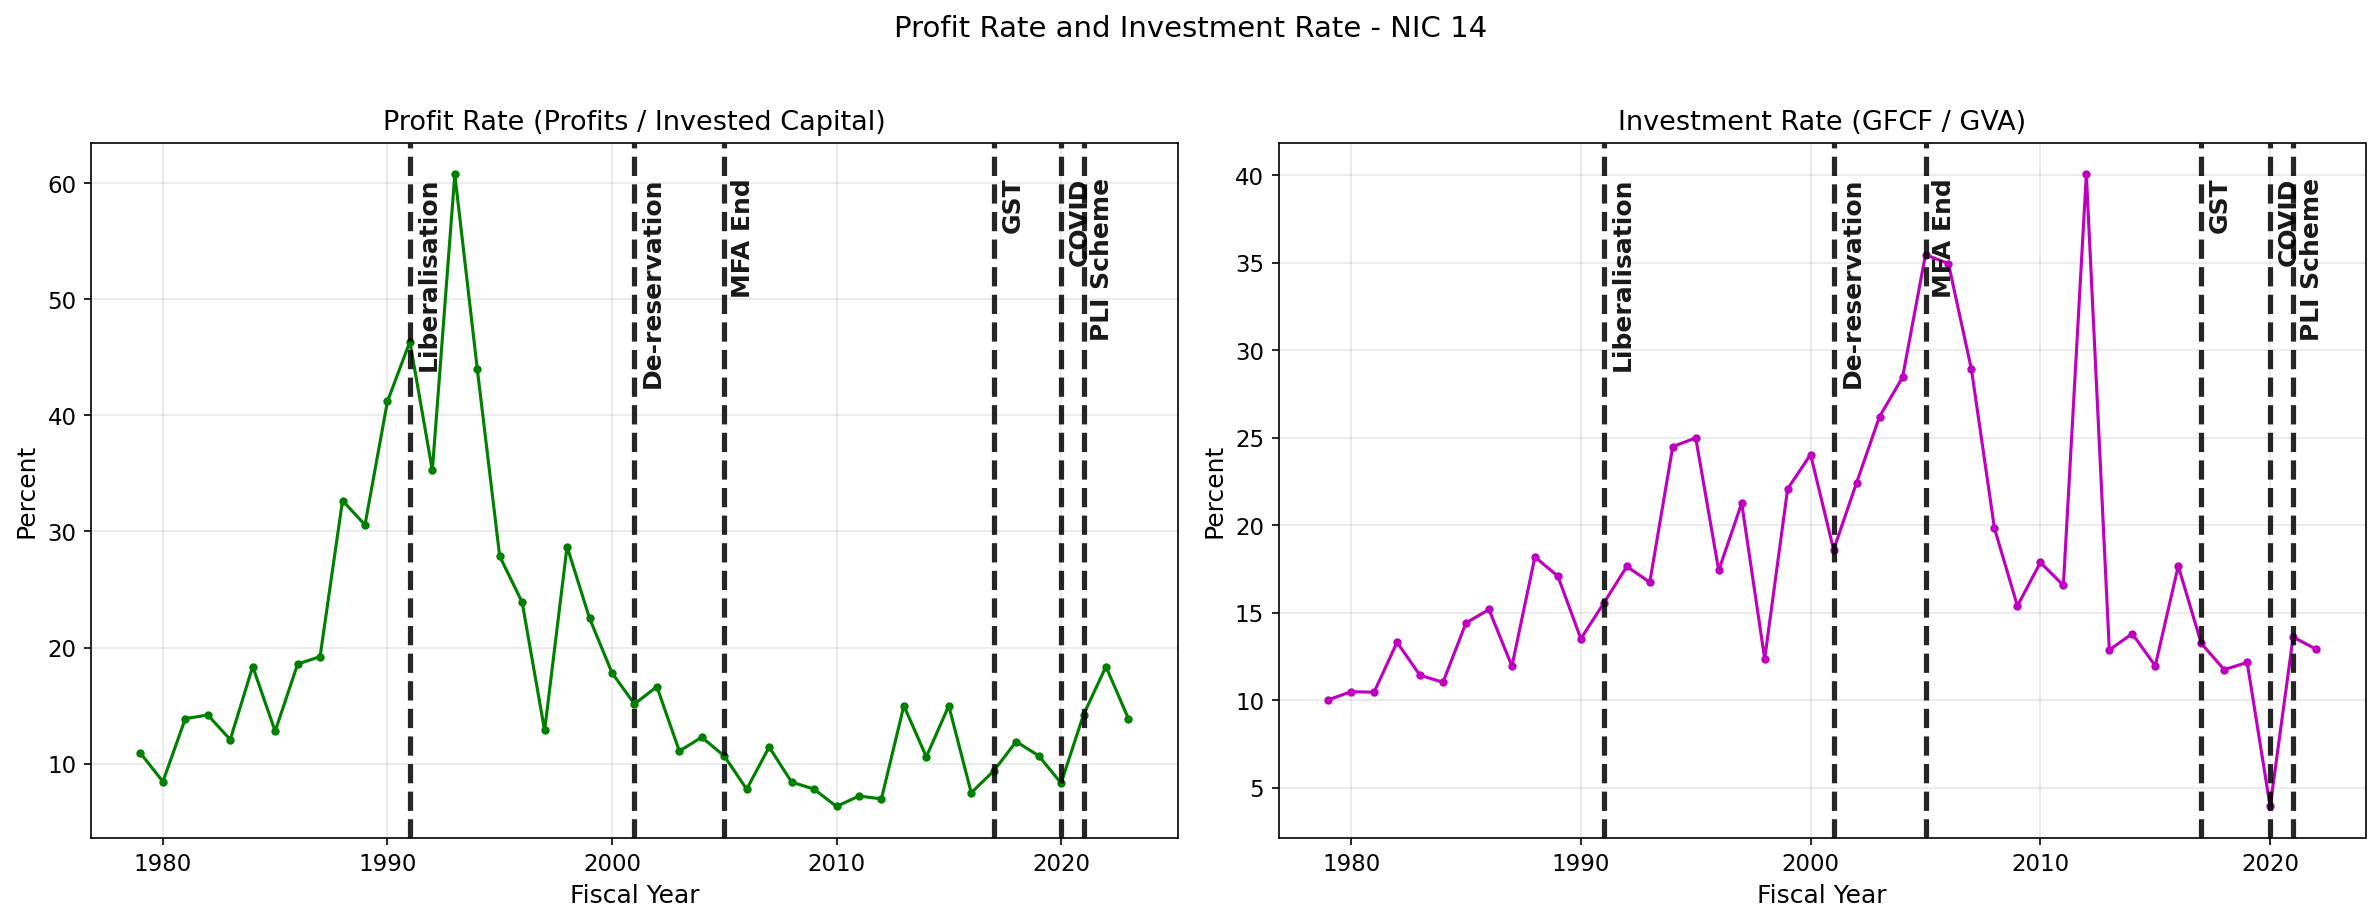

In [75]:
# 1.10 Profit rate and investment rate
print('[1.10] Plotting: Profit rate & Investment rate...')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
# Profit rate
mask_p = df['ProfitRate_IC'].notna()
ax1.plot(df.loc[mask_p, 'YearStart'], df.loc[mask_p, 'ProfitRate_IC'] * 100,
         'g-o', markersize=3, linewidth=1.5)
ax1.set_title('Profit Rate (Profits / Invested Capital)')
ax1.set_ylabel('Percent')
ax1.set_xlabel('Fiscal Year')
add_policy_lines(ax1)

# Investment rate
mask_i = df['InvestmentRate'].notna()
ax2.plot(df.loc[mask_i, 'YearStart'], df.loc[mask_i, 'InvestmentRate'] * 100,
         'm-o', markersize=3, linewidth=1.5)
ax2.set_title('Investment Rate (GFCF / GVA)')
ax2.set_ylabel('Percent')
ax2.set_xlabel('Fiscal Year')
add_policy_lines(ax2)

plt.suptitle('Profit Rate and Investment Rate - NIC 14', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(FIG_DIR / 'Fig_ProfitRate_InvestmentRate.png', bbox_inches='tight')
plt.show()

---
# BLOCK 2: EMPLOYMENT, WAGES, AND LABOUR STRUCTURE

[2.1] Plotting employment trends...


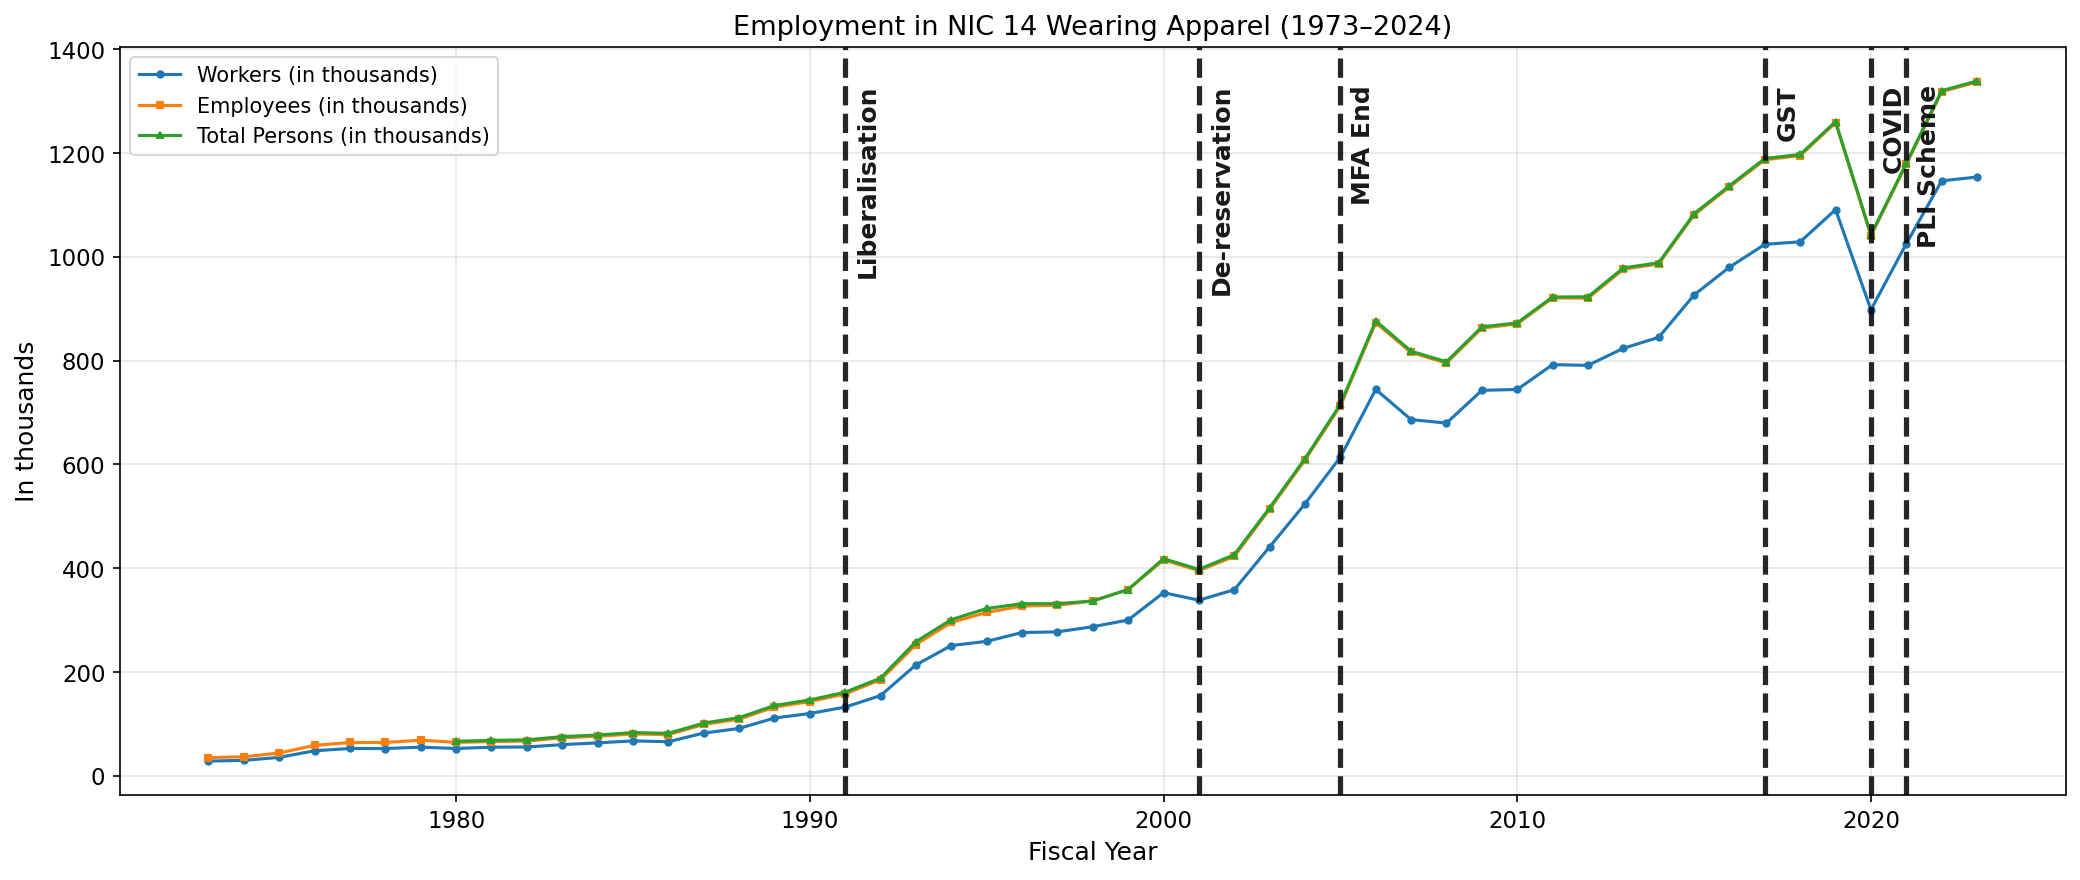

In [76]:
# 2.1 Employment trends
print('[2.1] Plotting employment trends...')
fig, ax = plt.subplots(figsize=(14, 6))
for col, label, marker in [
    ('Workers', 'Workers (in thousands)', 'o'),
    ('Employees', 'Employees (in thousands)', 's'),
    ('TotalPersons', 'Total Persons (in thousands)', '^'),
]:
    mask = df[col].notna()
    ax.plot(df.loc[mask, 'YearStart'], df.loc[mask, col],
            marker=marker, markersize=3, label=label, linewidth=1.5)

ax.set_xlabel('Fiscal Year')
ax.set_ylabel('In thousands')
ax.set_title('Employment in NIC 14 Wearing Apparel (1973–2024)')
ax.legend()
add_policy_lines(ax)
plt.tight_layout()
plt.savefig(FIG_DIR / 'Fig06_Employment.png', bbox_inches='tight')
plt.show()

In [77]:
# 2.2 Employment elasticity of output by era
print('[2.2] Computing employment elasticity by era...')
elast_table = []
for era_name, (start, end) in ERAS.items():
    cagr_w = cagr('Workers', start, end)
    cagr_o = cagr('Real_Output', start, end)
    elasticity = cagr_w / cagr_o if cagr_o and cagr_o != 0 else np.nan
    elast_table.append({
        'Era': era_name,
        'CAGR Workers (%)': round(cagr_w, 2) if cagr_w else np.nan,
        'CAGR Real Output (%)': round(cagr_o, 2) if cagr_o else np.nan,
        'Employment Elasticity': round(elasticity, 3) if elasticity else np.nan,
    })
elast_result = pd.DataFrame(elast_table)
elast_result

[2.2] Computing employment elasticity by era...


Era  CAGR Workers (%)  \
0            Era I: Protection & MFA (1973-1990)              8.83   
1             Era II: Liberalisation (1991-2000)             11.50   
2  Era III: De-reservation & MFA End (2001-2007)             12.50   
3      Era IV: Post-Quota Adjustment (2008-2019)              4.39   
4                 Era V: COVID & PLI (2020-2024)              8.71   

   CAGR Real Output (%)  Employment Elasticity  
0                 13.45                  0.657  
1                 15.72                  0.731  
2                 12.75                  0.981  
3                  5.12                  0.858  
4                 15.85                  0.549

[2.3] Plotting gender composition...


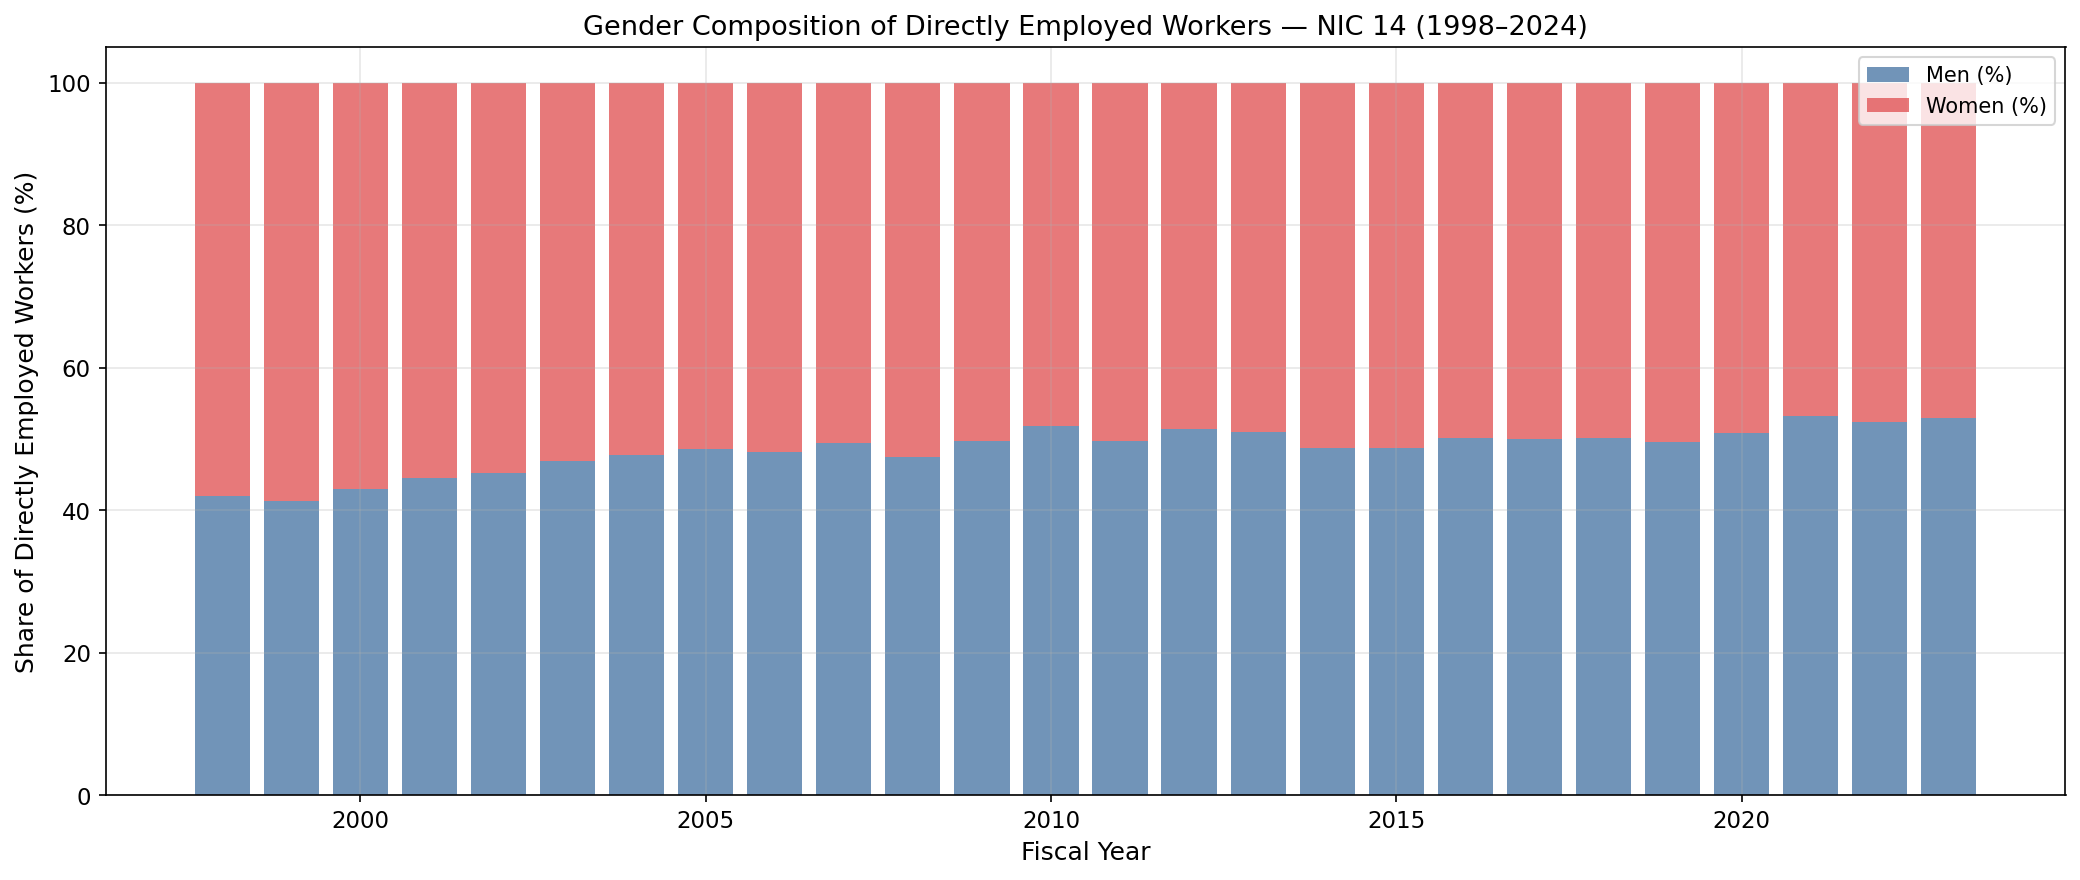

In [78]:
# 2.3 Gender composition (1998-2024)
print('[2.3] Plotting gender composition...')
gender_df = df[df['WomenShare'].notna()].copy()
if len(gender_df) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.bar(gender_df['YearStart'], gender_df['MenShare'] * 100, label='Men (%)', color='#4e79a7', alpha=0.8)
    ax.bar(gender_df['YearStart'], gender_df['WomenShare'] * 100,
           bottom=gender_df['MenShare'] * 100, label='Women (%)', color='#e15759', alpha=0.8)
    ax.set_xlabel('Fiscal Year')
    ax.set_ylabel('Share of Directly Employed Workers (%)')
    ax.set_title('Gender Composition of Directly Employed Workers — NIC 14 (1998–2024)')
    ax.legend()
    ax.set_ylim(0, 105)
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'Fig07_GenderComposition.png', bbox_inches='tight')
    plt.show()
else:
    print('  No gender data available.')

[2.4] Plotting contract worker share...


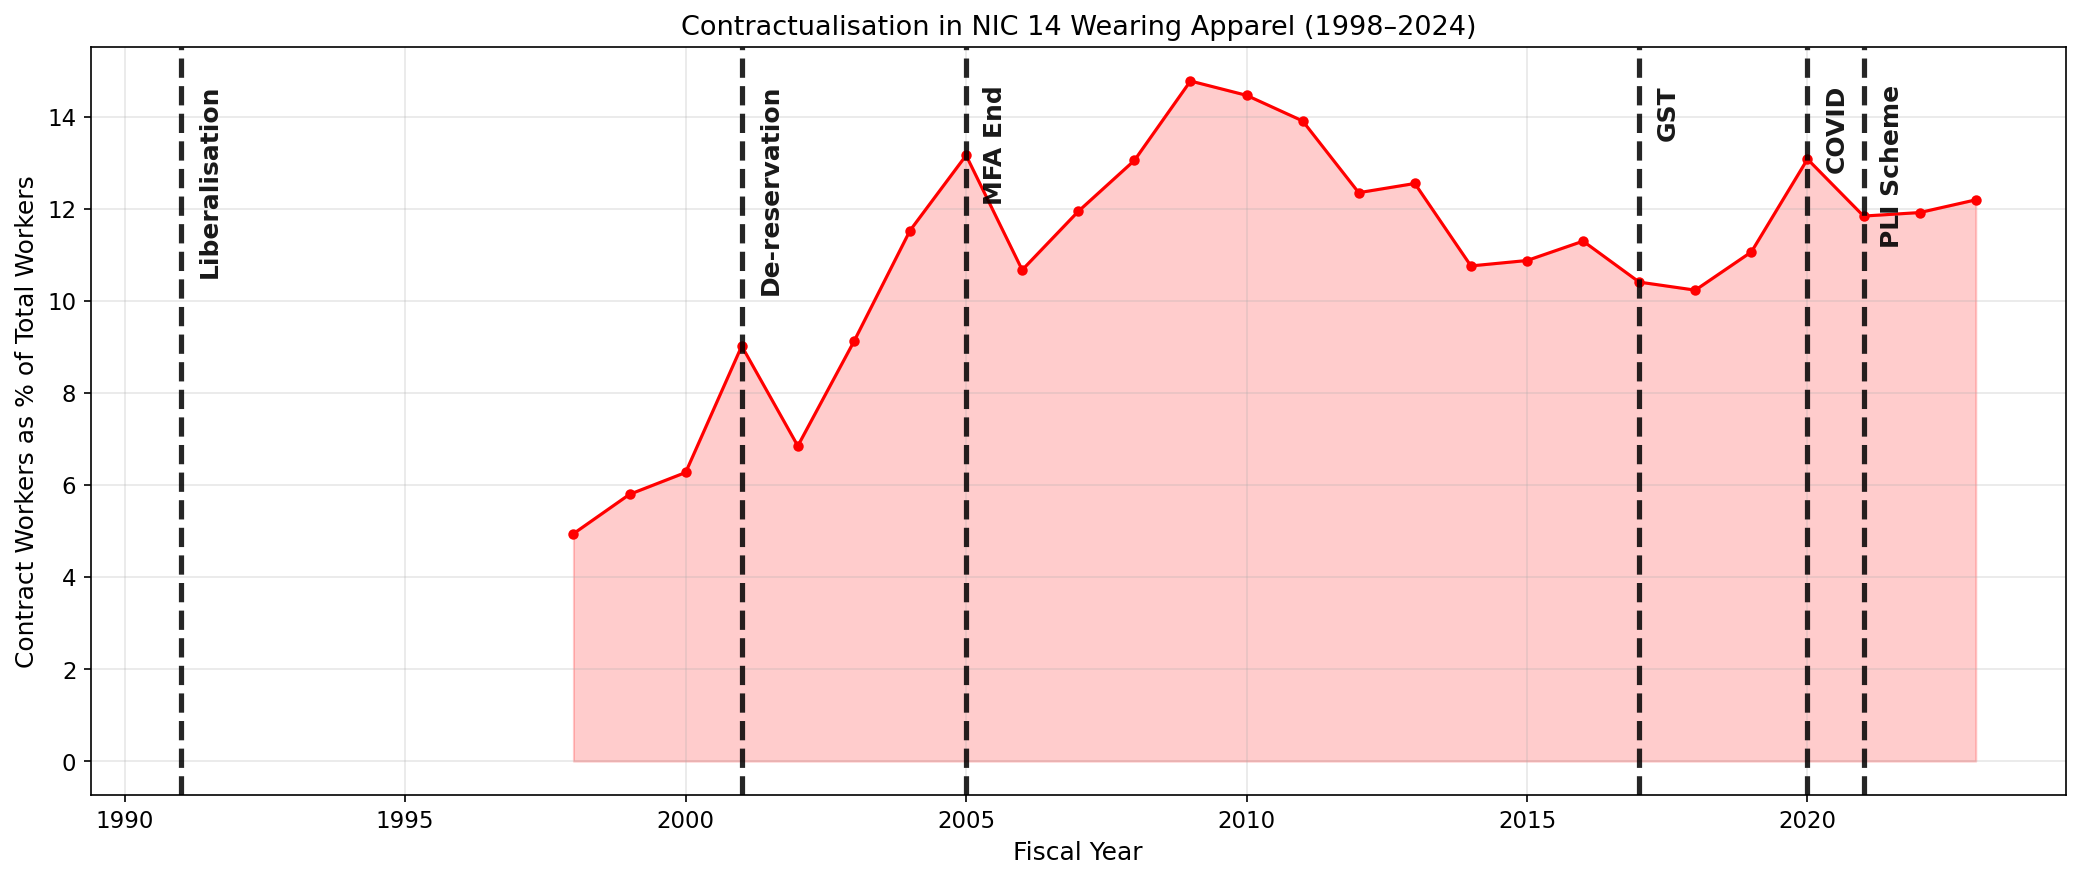

In [79]:
# 2.4 Contractualisation trend
print('[2.4] Plotting contract worker share...')
contract_df = df[df['ContractShare'].notna()].copy()
if len(contract_df) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(contract_df['YearStart'], contract_df['ContractShare'] * 100,
            'r-o', markersize=4, linewidth=1.5)
    ax.set_xlabel('Fiscal Year')
    ax.set_ylabel('Contract Workers as % of Total Workers')
    ax.set_title('Contractualisation in NIC 14 Wearing Apparel (1998–2024)')
    ax.fill_between(contract_df['YearStart'], contract_df['ContractShare'] * 100,
                    alpha=0.2, color='red')
    add_policy_lines(ax)
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'Fig08_Contractualisation.png', bbox_inches='tight')
    plt.show()

[2.5] Plotting real wage per worker...


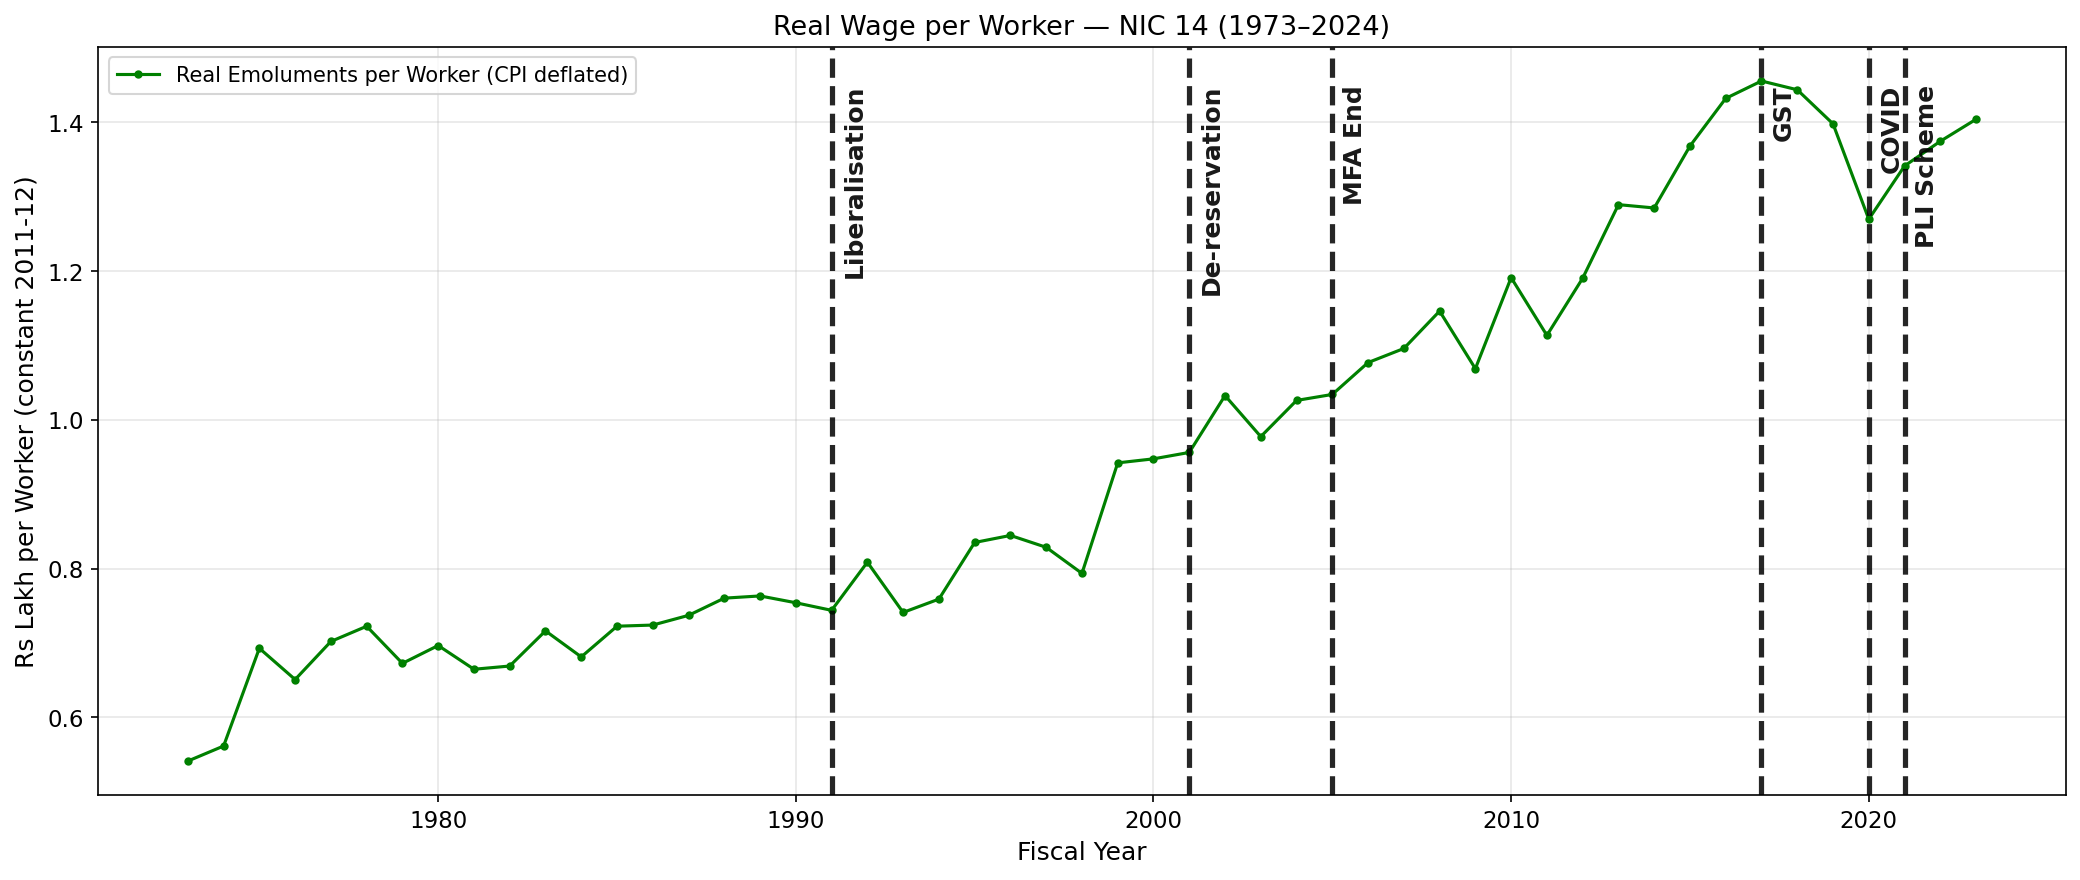

In [80]:
# 2.5 Real Wage per Worker
print('[2.5] Plotting real wage per worker...')
fig, ax = plt.subplots(figsize=(14, 6))
mask = df['RealWagePerWorker'].notna()
ax.plot(df.loc[mask, 'YearStart'], df.loc[mask, 'RealWagePerWorker'],
        'g-o', markersize=3, linewidth=1.5, label='Real Emoluments per Worker (CPI deflated)')
ax.set_xlabel('Fiscal Year')
ax.set_ylabel('Rs Lakh per Worker (constant 2011-12)')
ax.set_title('Real Wage per Worker — NIC 14 (1973–2024)')
ax.legend()
add_policy_lines(ax)
plt.tight_layout()
plt.savefig(FIG_DIR / 'Fig09_RealWagePerWorker.png', bbox_inches='tight')
plt.show()

[2.6] Plotting wage-productivity gap...


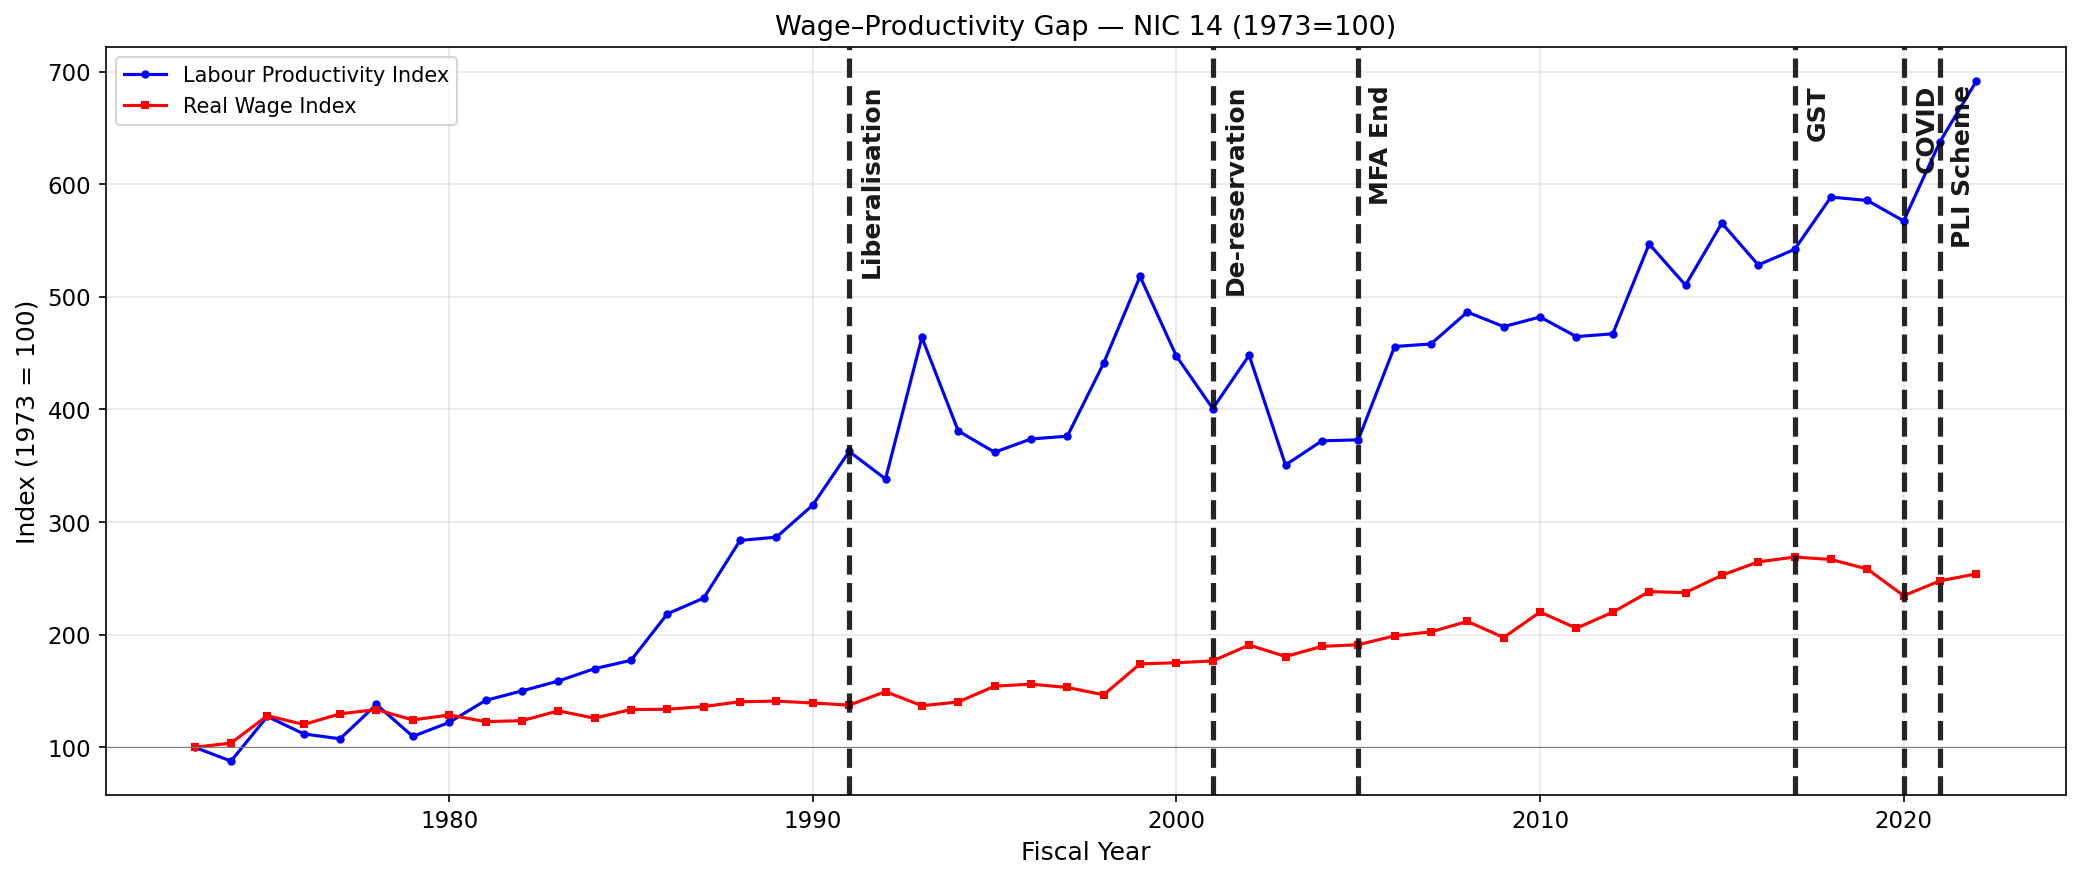

In [81]:
# 2.6 Wage-Productivity Gap
print('[2.6] Plotting wage-productivity gap...')
fig, ax = plt.subplots(figsize=(14, 6))
common = df[df['LP_GVA_Worker'].notna() & df['RealWagePerWorker'].notna()].copy()
if len(common) > 2:
    base_lp = common.iloc[0]['LP_GVA_Worker']
    base_rw = common.iloc[0]['RealWagePerWorker']
    common['LP_index'] = (common['LP_GVA_Worker'] / base_lp) * 100
    common['RW_index'] = (common['RealWagePerWorker'] / base_rw) * 100
    base_year = int(common.iloc[0]['YearStart'])
    
    ax.plot(common['YearStart'], common['LP_index'], 'b-o', markersize=3,
            label='Labour Productivity Index', linewidth=1.5)
    ax.plot(common['YearStart'], common['RW_index'], 'r-s', markersize=3,
            label='Real Wage Index', linewidth=1.5)
    ax.axhline(100, color='grey', linewidth=0.5)
    ax.set_xlabel('Fiscal Year')
    ax.set_ylabel(f'Index ({base_year} = 100)')
    ax.set_title(f'Wage–Productivity Gap — NIC 14 ({base_year}=100)')
    ax.legend()
    add_policy_lines(ax)
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'Fig10_WageProductivityGap.png', bbox_inches='tight')
    plt.show()

[2.7] Plotting: Labour share of GVA...


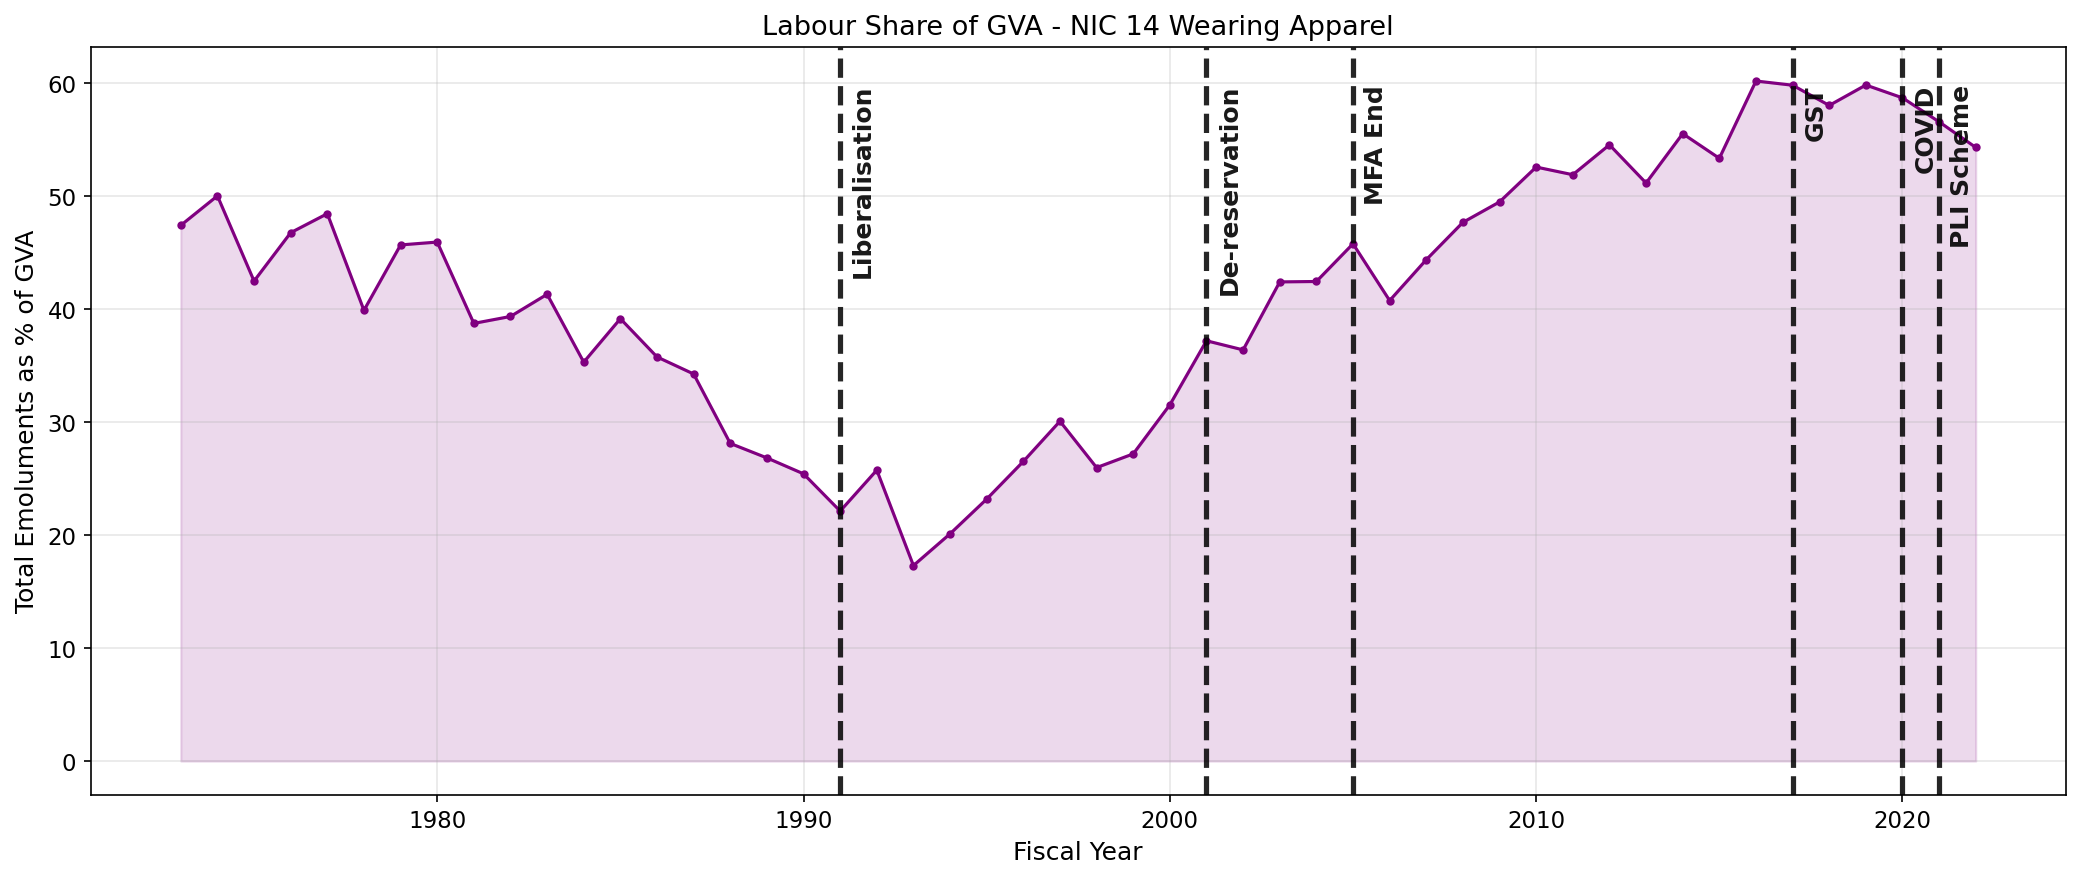

In [82]:
# 2.7 Figure: Labour Share of GVA
print('[2.7] Plotting: Labour share of GVA...')
fig, ax = plt.subplots(figsize=(14, 6))
mask = df['LabourShareGVA'].notna()
ax.plot(df.loc[mask, 'YearStart'], df.loc[mask, 'LabourShareGVA'] * 100,
        'purple', marker='o', markersize=3, linewidth=1.5)
ax.fill_between(df.loc[mask, 'YearStart'], df.loc[mask, 'LabourShareGVA'] * 100,
                alpha=0.15, color='purple')
ax.set_xlabel('Fiscal Year')
ax.set_ylabel('Total Emoluments as % of GVA')
ax.set_title('Labour Share of GVA - NIC 14 Wearing Apparel')
add_policy_lines(ax)
plt.tight_layout()
plt.savefig(FIG_DIR / 'Fig_LabourShareGVA.png', bbox_inches='tight')
plt.show()

In [83]:
# 2.8 Table 3: Labour Market Dashboard
print('[2.8] Building Table 3: Labour Market Dashboard...')
lab_vars = {
    'Workers': 'Workers (in thousands)',
    'RealWagePerWorker': 'Real Wage/Worker (Rs Lakh)',
    'LabourShareGVA': 'Labour Share of GVA',
    'WomenShare': 'Women Share (Directly Emp.)',
    'ContractShare': 'Contract Worker Share',
    'MandaysPerEmployee': 'Mandays per Employee',
}

lab_table = []
for era_name, (start, end) in ERAS.items():
    era_df = df[df['YearStart'].between(start, end)]
    row = {'Era': era_name}
    for var, label in lab_vars.items():
        if var in era_df.columns:
            row[label] = era_df[var].mean()
    lab_table.append(row)

lab_dashboard = pd.DataFrame(lab_table).set_index('Era')
lab_dashboard.round(3).to_csv(TABLE_DIR / 'Table3_labour_dashboard.csv')
lab_dashboard.round(3)

[2.8] Building Table 3: Labour Market Dashboard...


Workers (in thousands)  \
Era                                                                     
Era I: Protection & MFA (1973-1990)                            62.741   
Era II: Liberalisation (1991-2000)                            250.561   
Era III: De-reservation & MFA End (2001-2007)                 529.682   
Era IV: Post-Quota Adjustment (2008-2019)                     872.526   
Era V: COVID & PLI (2020-2024)                               1056.002   

                                               Real Wage/Worker (Rs Lakh)  \
Era                                                                         
Era I: Protection & MFA (1973-1990)                                 0.691   
Era II: Liberalisation (1991-2000)                                  0.824   
Era III: De-reservation & MFA End (2001-2007)                       1.029   
Era IV: Post-Quota Adjustment (2008-2019)                           1.282   
Era V: COVID & PLI (2020-2024)                                      1.348   

                                               Labour Share of GVA  \
Era                                                                  
Era I: Protection & MFA (1973-1990)                          0.395   
Era II: Liberalisation (1991-2000)                           0.250   
Era III: De-reservation & MFA End (2001-2007)                0.413   
Era IV: Post-Quota Adjustment (2008-2019)                    0.545   
Era V: COVID & PLI (2020-2024)                               0.565   

                                               Women Share (Directly Emp.)  \
Era                                                                          
Era I: Protection & MFA (1973-1990)                                    NaN   
Era II: Liberalisation (1991-2000)                                   0.579   
Era III: De-reservation & MFA End (2001-2007)                        0.528   
Era IV: Post-Quota Adjustment (2008-2019)                            0.502   
Era V: COVID & PLI (2020-2024)                                       0.477   

                                               Contract Worker Share  \
Era                                                                    
Era I: Protection & MFA (1973-1990)                              NaN   
Era II: Liberalisation (1991-2000)                             0.057   
Era III: De-reservation & MFA End (2001-2007)                  0.103   
Era IV: Post-Quota Adjustment (2008-2019)                      0.121   
Era V: COVID & PLI (2020-2024)                                 0.123   

                                               Mandays per Employee  
Era                                                                  
Era I: Protection & MFA (1973-1990)                         283.739  
Era II: Liberalisation (1991-2000)                          296.556  
Era III: De-reservation & MFA End (2001-2007)               298.572  
Era IV: Post-Quota Adjustment (2008-2019)                   300.595  
Era V: COVID & PLI (2020-2024)                              295.265

[2.9] Wage inequality analysis...


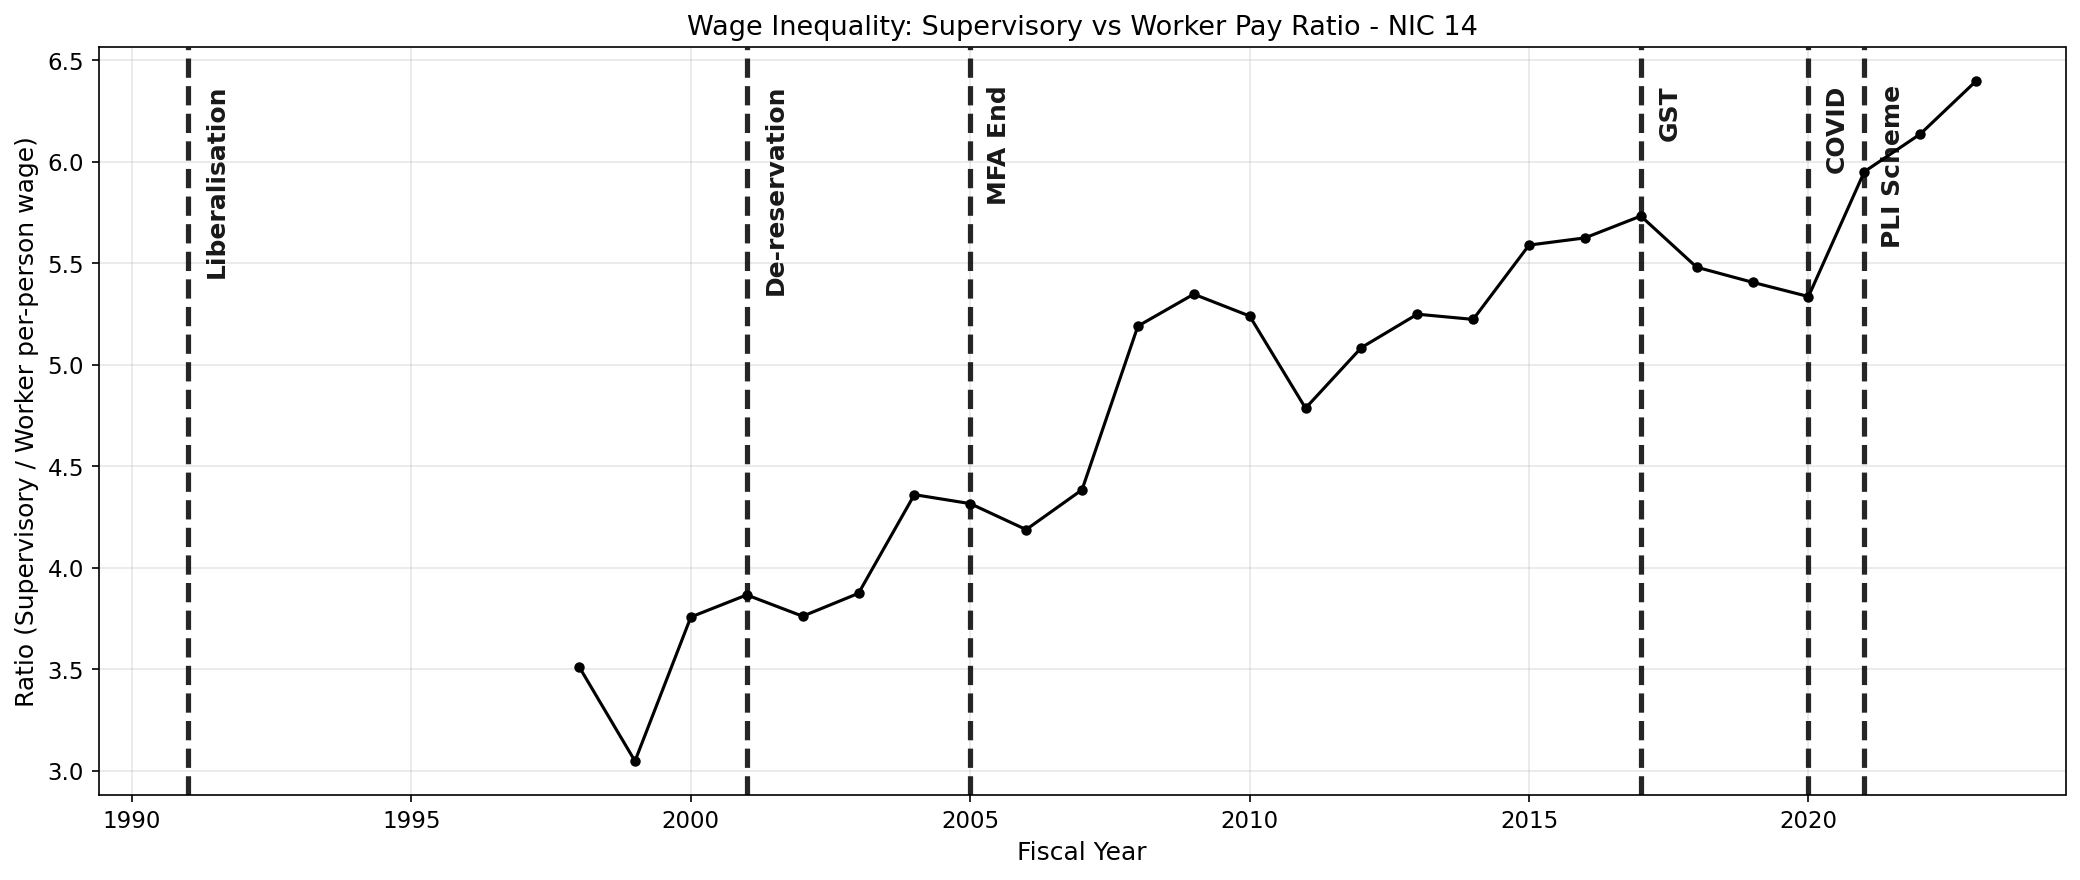

  Wage ratio range: 3.05 - 6.40


In [84]:
# 2.9 Wage inequality (supervisory vs worker)
print('[2.9] Wage inequality analysis...')
wage_ineq = df[['YearStart', 'Wages and Salaries - Supervisory and Managerial Staff',
                 'Supervisory and Managerial Staff',
                 'Wages and Salaries - Workers', 'Workers']].dropna()
if len(wage_ineq) > 0:
    wage_ineq = wage_ineq.copy()
    wage_ineq['Wage_Sup_PerPerson'] = (wage_ineq['Wages and Salaries - Supervisory and Managerial Staff'] * 100 * 100000 /
                                         wage_ineq['Supervisory and Managerial Staff'])
    wage_ineq['Wage_Worker_PerPerson'] = (wage_ineq['Wages and Salaries - Workers'] * 100 * 100000 /
                                            (wage_ineq['Workers'] * 1000))
    wage_ineq['Ratio'] = wage_ineq['Wage_Sup_PerPerson'] / wage_ineq['Wage_Worker_PerPerson']
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(wage_ineq['YearStart'], wage_ineq['Ratio'], 'k-o', markersize=4, linewidth=1.5)
    ax.set_xlabel('Fiscal Year')
    ax.set_ylabel('Ratio (Supervisory / Worker per-person wage)')
    ax.set_title('Wage Inequality: Supervisory vs Worker Pay Ratio - NIC 14')
    add_policy_lines(ax)
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'Fig_WageInequality.png', bbox_inches='tight')
    plt.show()
    print(f'  Wage ratio range: {wage_ineq["Ratio"].min():.2f} - {wage_ineq["Ratio"].max():.2f}')

---
# BLOCK 3: REGIONAL CONCENTRATION AND STATE-LEVEL PANEL

In [85]:
# 3.1 Panel construction — Balanced 13-state panel
print('[3.1] Constructing BALANCED state panel (1998-2023)...')
states_panel = sub07[(sub07['State'] != 'All India') & (sub07['YearStart'] >= 1998)].copy()

# Use confirmed balanced 13-state list
BALANCED_STATES = [
    'Andhra Pradesh', 'Delhi', 'Gujarat', 'Haryana', 'Karnataka',
    'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Punjab', 'Rajasthan',
    'Tamil Nadu', 'Uttar Pradesh', 'West Bengal'
]
# Verify which balanced states are present in data
available_balanced = [s for s in BALANCED_STATES if s in states_panel['State'].unique()]
if len(available_balanced) < 13:
    print(f'  WARNING: Only {len(available_balanced)}/13 balanced states found in data.')
    print(f'  Missing: {set(BALANCED_STATES) - set(available_balanced)}')
else:
    print(f'  All 13 balanced states confirmed present.')

good_states = available_balanced
states_panel = states_panel[states_panel['State'].isin(good_states)].copy()
# Restrict to 1998-2023 for balanced coverage
states_panel = states_panel[states_panel['YearStart'].between(1998, 2023)]
print(f'  States: {len(good_states)}')
print(f'  Panel years: 1998-2023')
print(f'  States list: {chr(10).join(sorted(good_states))}')

[3.1] Constructing BALANCED state panel (1998-2023)...
  All 13 balanced states confirmed present.
  States: 13
  Panel years: 1998-2023
  States list: Andhra Pradesh
Delhi
Gujarat
Haryana
Karnataka
Kerala
Madhya Pradesh
Maharashtra
Punjab
Rajasthan
Tamil Nadu
Uttar Pradesh
West Bengal


In [86]:
# 3.2 Concentration indices
print('[3.2] Computing concentration indices...')

# np.trapz was removed in NumPy 2.0; use np.trapezoid
_trapz = getattr(np, 'trapezoid', getattr(np, 'trapz', None))

conc_results = []
for yr in range(1998, 2024):
    yr_data = states_panel[states_panel['YearStart'] == yr].copy()
    
    for var, var_label in [('Real_GVA', 'GVA'), ('Workers', 'Employment'),
                           ('Number of Factories', 'Factories')]:
        state_vals = yr_data[['State', var]].dropna()
        if len(state_vals) < 4:
            continue
        
        # Use sum of reporting states as total (All India row may have NaN in sub07)
        total = state_vals[var].sum()
        if total == 0:
            continue
        
        state_vals = state_vals.copy()
        state_vals['share'] = state_vals[var] / total
        state_vals = state_vals.sort_values(var, ascending=False)
        
        cr4 = state_vals.head(4)['share'].sum()
        cr8 = state_vals.head(8)['share'].sum()
        hhi = (state_vals['share'] ** 2).sum()
        
        # Spatial Gini
        n = len(state_vals)
        shares_sorted = state_vals['share'].sort_values().values
        cum_share = np.cumsum(shares_sorted) / shares_sorted.sum()
        gini = 1 - 2 * _trapz(cum_share, np.linspace(0, 1, n)) if n > 1 else 0
        
        conc_results.append({
            'Year': yr, 'Variable': var_label,
            'CR4': cr4, 'CR8': cr8, 'HHI': hhi, 'Gini': gini,
        })

conc_df = pd.DataFrame(conc_results)
conc_df.to_csv(TABLE_DIR / 'concentration_indices.csv', index=False)
print(f'  Computed {len(conc_df)} concentration observations.')
conc_df.head()

[3.2] Computing concentration indices...


  Computed 78 concentration observations.


Year    Variable       CR4       CR8       HHI      Gini
0  1998         GVA  0.749484  0.958753  0.167921  0.528475
1  1998  Employment  0.825285  0.955978  0.264071  0.626843
2  1998   Factories  0.739248  0.954083  0.185805  0.544151
3  1999         GVA  0.742291  0.965986  0.163836  0.527983
4  1999  Employment  0.821980  0.963139  0.253718  0.626868

[3.3] Plotting concentration trends...


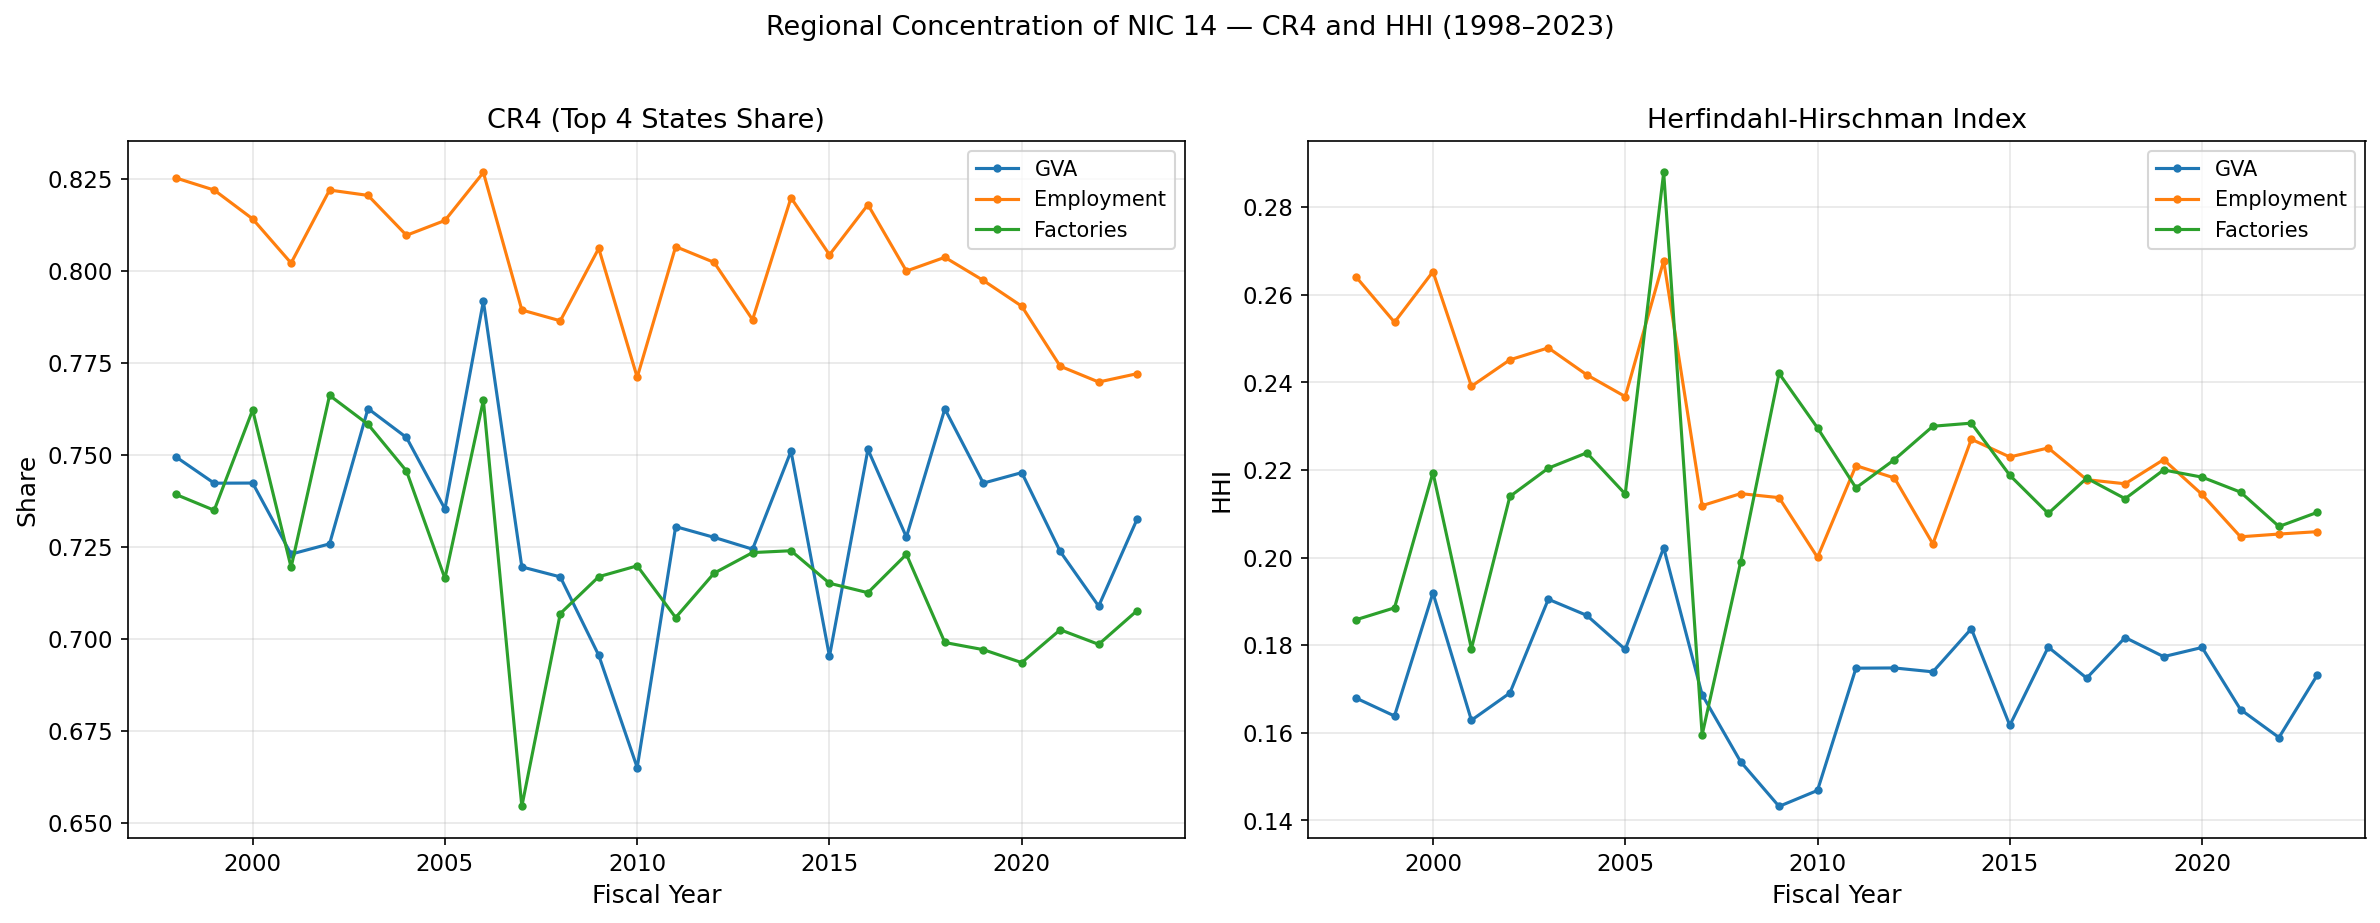

In [87]:
# 3.3 CR4 and HHI trends
print('[3.3] Plotting concentration trends...')
if len(conc_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    for var_label, color in [('GVA', 'blue'), ('Employment', 'red'), ('Factories', 'green')]:
        subset = conc_df[conc_df['Variable'] == var_label]
        if len(subset) > 0:
            axes[0].plot(subset['Year'], subset['CR4'], marker='o', markersize=3,
                         label=var_label, linewidth=1.5)
            axes[1].plot(subset['Year'], subset['HHI'], marker='o', markersize=3,
                         label=var_label, linewidth=1.5)
    
    axes[0].set_title('CR4 (Top 4 States Share)')
    axes[0].set_ylabel('Share')
    axes[0].legend()
    axes[1].set_title('Herfindahl-Hirschman Index')
    axes[1].set_ylabel('HHI')
    axes[1].legend()
    for ax in axes:
        ax.set_xlabel('Fiscal Year')
    
    plt.suptitle('Regional Concentration of NIC 14 — CR4 and HHI (1998–2023)', fontsize=13, y=1.02)
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'Fig11_Concentration_CR4_HHI.png', bbox_inches='tight')
    plt.show()

[3.4] Plotting state productivity ranking...


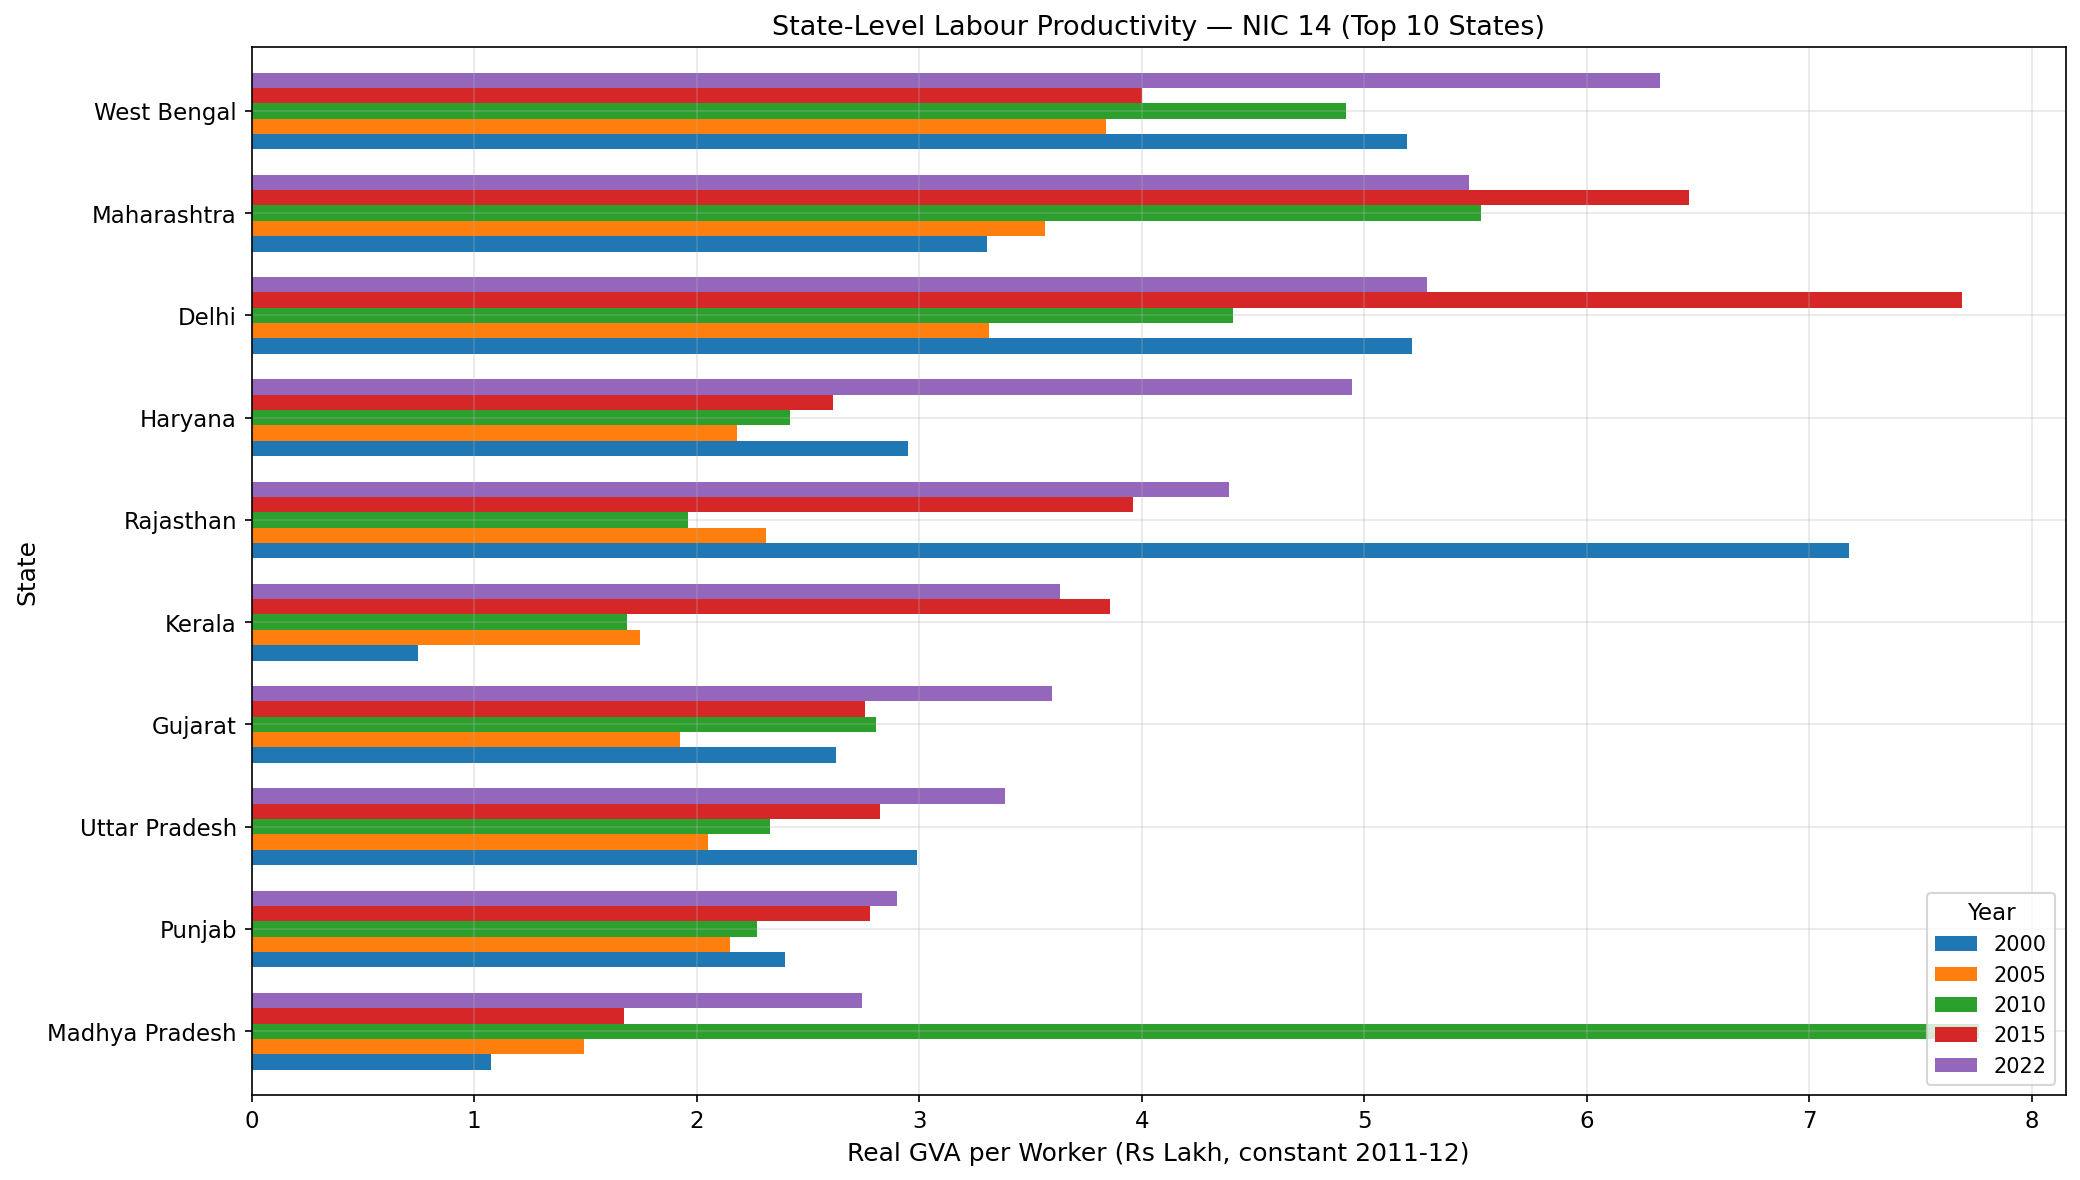

In [88]:
# 3.4 State productivity ranking
print('[3.4] Plotting state productivity ranking...')
benchmark_years = [2000, 2005, 2010, 2015, 2022]
prod_rank_data = []
for yr in benchmark_years:
    yr_data = states_panel[states_panel['YearStart'] == yr][['State', 'LP_GVA_Worker']].dropna()
    yr_data = yr_data.copy()
    yr_data['Year'] = yr
    prod_rank_data.append(yr_data)

if len(prod_rank_data) > 0:
    prod_rank = pd.concat(prod_rank_data)
    latest = prod_rank[prod_rank['Year'] == prod_rank['Year'].max()]
    top_states = latest.nlargest(10, 'LP_GVA_Worker')['State'].tolist()
    prod_rank_top = prod_rank[prod_rank['State'].isin(top_states)]
    
    fig, ax = plt.subplots(figsize=(14, 8))
    pivot = prod_rank_top.pivot(index='State', columns='Year', values='LP_GVA_Worker')
    pivot = pivot.loc[pivot[pivot.columns[-1]].sort_values(ascending=True).index]
    pivot.plot(kind='barh', ax=ax, width=0.75)
    ax.set_xlabel('Real GVA per Worker (Rs Lakh, constant 2011-12)')
    ax.set_title('State-Level Labour Productivity — NIC 14 (Top 10 States)')
    ax.legend(title='Year', loc='lower right')
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'Fig12_StateProductivityRanking.png', bbox_inches='tight')
    plt.show()

[3.5a] Sigma-convergence analysis...


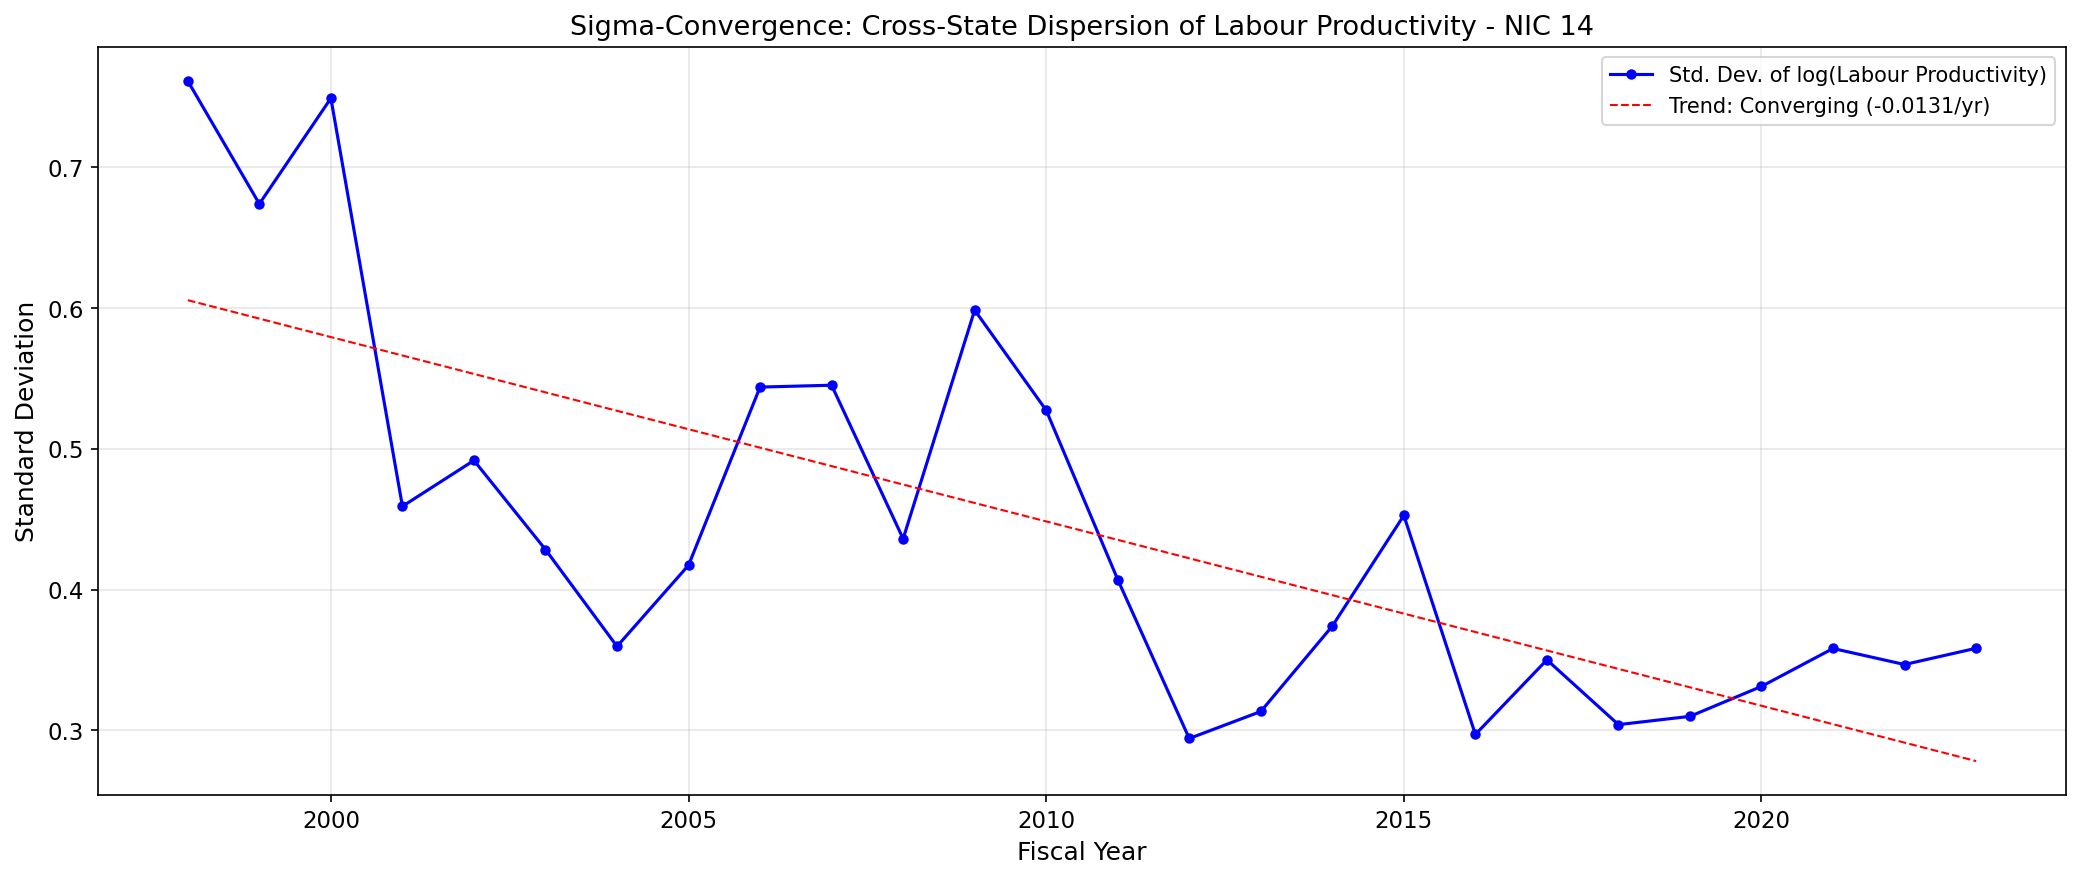

  Sigma-convergence trend: Trend: Converging (-0.0131/yr)


In [89]:
# 3.5a Sigma-convergence
print('[3.5a] Sigma-convergence analysis...')

sigma_conv = []
for yr in range(1998, 2024):
    yr_data = states_panel[(states_panel['YearStart'] == yr) & (states_panel['LP_GVA_Worker'].notna()) & (states_panel['LP_GVA_Worker'] > 0)]
    if len(yr_data) >= 5:
        log_lp = np.log(yr_data['LP_GVA_Worker'])
        sigma_conv.append({
            'Year': yr,
            'CV': log_lp.std() / log_lp.mean() if log_lp.mean() != 0 else np.nan,
            'SD': log_lp.std(),
            'N_states': len(yr_data),
        })

sigma_df = pd.DataFrame(sigma_conv)
if len(sigma_df) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(sigma_df['Year'], sigma_df['SD'], 'b-o', markersize=4, linewidth=1.5,
            label='Std. Dev. of log(Labour Productivity)')
    ax.set_xlabel('Fiscal Year')
    ax.set_ylabel('Standard Deviation')
    ax.set_title('Sigma-Convergence: Cross-State Dispersion of Labour Productivity - NIC 14')
    ax.legend()
    trend = np.polyfit(sigma_df['Year'], sigma_df['SD'], 1)
    trend_label = f"Trend: {'Converging' if trend[0] < 0 else 'Diverging'} ({trend[0]:.4f}/yr)"
    ax.plot(sigma_df['Year'], np.polyval(trend, sigma_df['Year']),
            'r--', linewidth=1, label=trend_label)
    ax.legend()
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'Fig_SigmaConvergence.png', bbox_inches='tight')
    plt.show()
    print(f'  Sigma-convergence trend: {trend_label}')
    sigma_df.to_csv(TABLE_DIR / 'sigma_convergence.csv', index=False)

[3.5b] Beta-convergence (cross-sectional)...


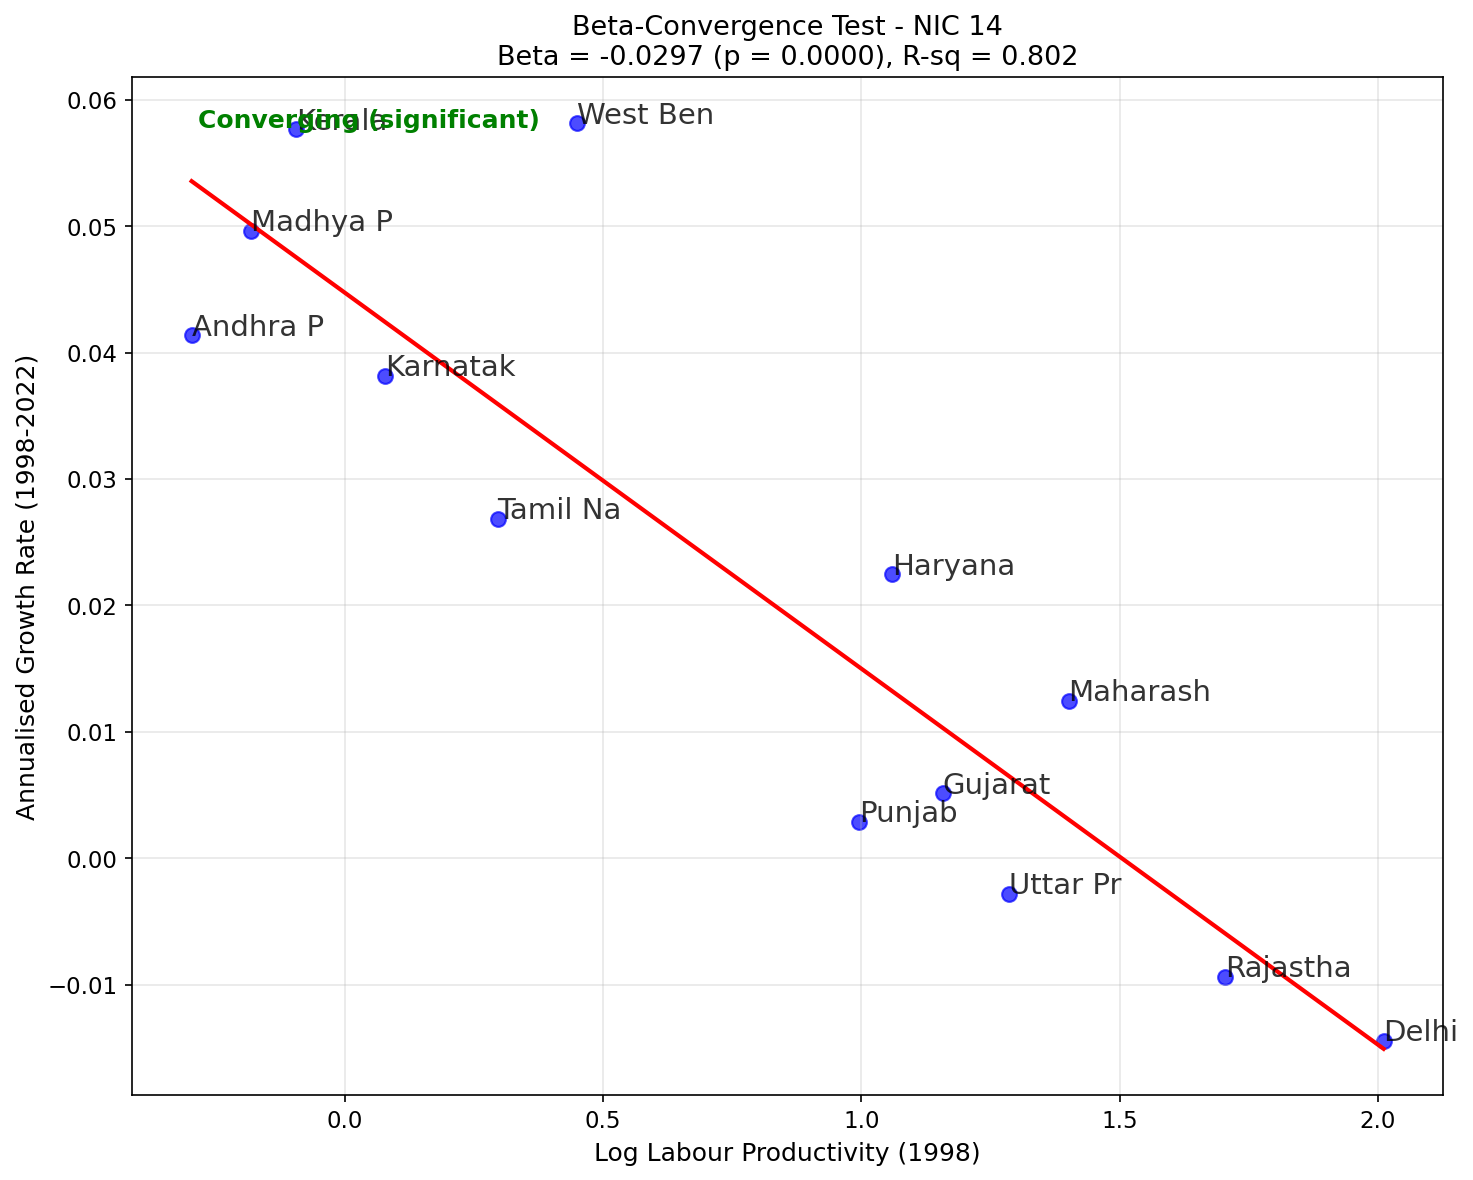

  Beta = -0.0297, p = 0.0000, R-sq = 0.802 -> Converging (significant)


In [90]:
# 3.5b Beta-convergence (cross-sectional)
print('[3.5b] Beta-convergence (cross-sectional)...')
initial_yr = 1998
final_yr = 2022
init_data = states_panel[states_panel['YearStart'] == initial_yr][['State', 'LP_GVA_Worker']].dropna()
init_data = init_data.copy()
init_data.columns = ['State', 'LP_initial']
final_data = states_panel[states_panel['YearStart'] == final_yr][['State', 'LP_GVA_Worker']].dropna()
final_data = final_data.copy()
final_data.columns = ['State', 'LP_final']

beta_data = init_data.merge(final_data, on='State')
if len(beta_data) >= 5:
    n_years = final_yr - initial_yr
    beta_data['growth'] = (np.log(beta_data['LP_final']) - np.log(beta_data['LP_initial'])) / n_years
    beta_data['log_initial'] = np.log(beta_data['LP_initial'])
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        beta_data['log_initial'], beta_data['growth']
    )
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(beta_data['log_initial'], beta_data['growth'], c='blue', s=50, alpha=0.7)
    for _, row in beta_data.iterrows():
        ax.annotate(row['State'][:8], (row['log_initial'], row['growth']),
                     fontsize=14, alpha=0.8)
    x_line = np.linspace(beta_data['log_initial'].min(), beta_data['log_initial'].max(), 100)
    ax.plot(x_line, intercept + slope * x_line, 'r-', linewidth=2)
    ax.set_xlabel(f'Log Labour Productivity ({initial_yr})')
    ax.set_ylabel(f'Annualised Growth Rate ({initial_yr}-{final_yr})')
    ax.set_title(f'Beta-Convergence Test - NIC 14\nBeta = {slope:.4f} (p = {p_value:.4f}), R-sq = {r_value**2:.3f}')
    conv_label = 'Converging' if slope < 0 else 'Diverging'
    sig_label = '(significant)' if p_value < 0.05 else '(not significant)'
    ax.annotate(f'{conv_label} {sig_label}', xy=(0.05, 0.95),
                xycoords='axes fraction', fontsize=12, fontweight='bold',
                color='green' if slope < 0 else 'red')
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'Fig_BetaConvergence.png', bbox_inches='tight')
    plt.show()
    print(f'  Beta = {slope:.4f}, p = {p_value:.4f}, R-sq = {r_value**2:.3f} -> {conv_label} {sig_label}')

In [91]:
print('[3.6] Building Table 4: Cluster profiles...')
cluster_map = {
    'Tamil Nadu': 'Tiruppur Knitwear',
    'Karnataka': 'Bengaluru Woven',
    'Delhi': 'NCR Cluster',
    'Haryana': 'NCR Cluster',
    'Uttar Pradesh': 'NCR Cluster',
    'Punjab': 'Ludhiana Flat-Knit',
    'Maharashtra': 'Mumbai Diversified',
    'Rajasthan': 'Jaipur Block-Print',
}

latest_yr = states_panel['YearStart'].max()
cluster_data = states_panel[states_panel['YearStart'] == latest_yr].copy()
cluster_data = cluster_data[cluster_data['State'].isin(cluster_map.keys())]

if len(cluster_data) > 0:
    cluster_data['Cluster'] = cluster_data['State'].map(cluster_map)
    cluster_cols = ['State', 'Cluster', 'Real_GVA', 'Workers',
                    'Number of Factories', 'LP_GVA_Worker']
    available_cols = [c for c in cluster_cols if c in cluster_data.columns]
    cluster_table = cluster_data[available_cols].sort_values('Real_GVA', ascending=False)
    
    if 'Number of Workers - Directly Employed - Women' in cluster_data.columns and \
       'Number of Workers - Directly Employed' in cluster_data.columns:
        cluster_data['WomenShare'] = (cluster_data['Number of Workers - Directly Employed - Women'] /
                                       cluster_data['Number of Workers - Directly Employed'])
        cluster_table = cluster_data[available_cols + ['WomenShare']].sort_values('Real_GVA', ascending=False)
    
    try:
        cluster_table.to_csv(TABLE_DIR / 'Table4_cluster_profiles.csv', index=False)
    except PermissionError:
        cluster_table.to_csv(TABLE_DIR / 'Table4_cluster_profiles_v2.csv', index=False)
        print('  (Saved as Table4_cluster_profiles_v2.csv due to file lock)')
    cluster_table

[3.6] Building Table 4: Cluster profiles...


[3.7] Plotting state-level gender variation...


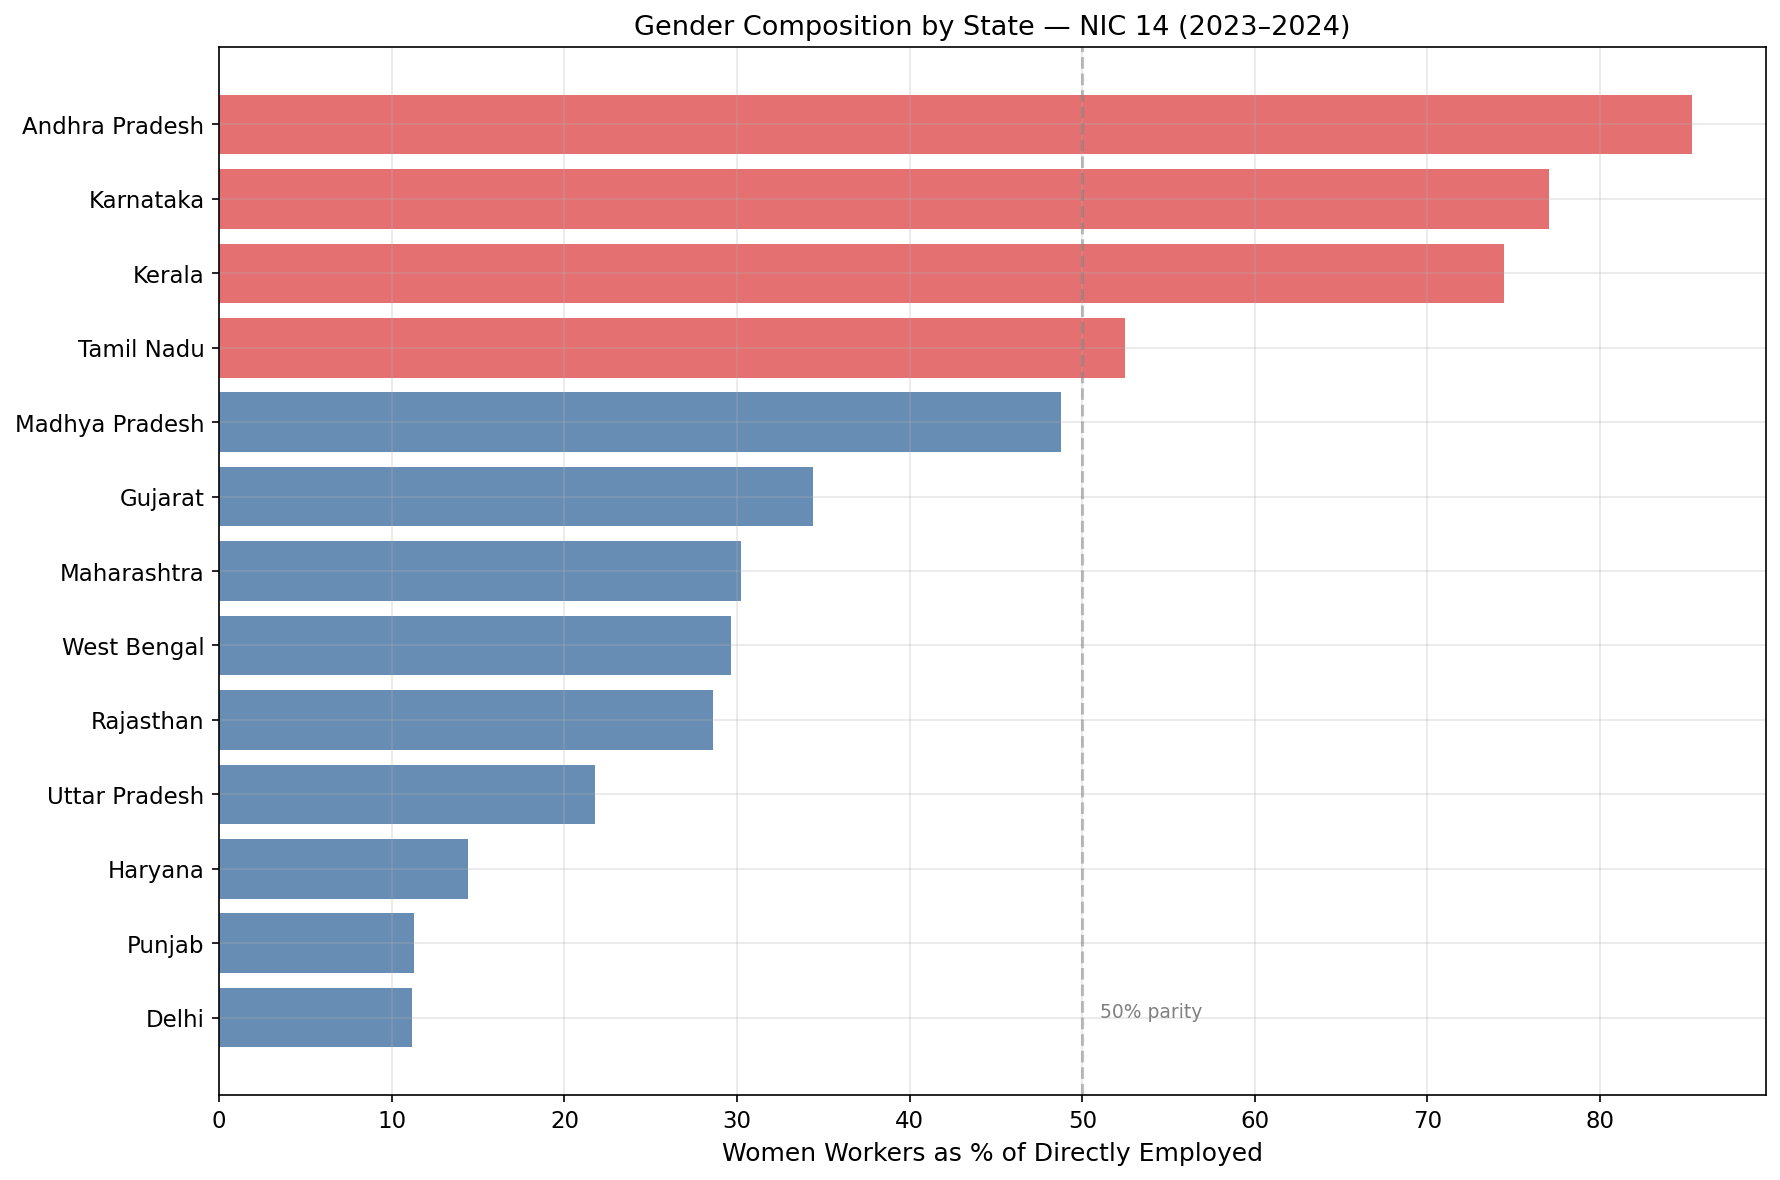

In [92]:
# 3.7 State-level gender variation
print('[3.7] Plotting state-level gender variation...')
gender_state = states_panel[states_panel['YearStart'] == latest_yr].copy()
if ('Number of Workers - Directly Employed - Women' in gender_state.columns and
    'Number of Workers - Directly Employed' in gender_state.columns):
    gender_state['WomenPct'] = (gender_state['Number of Workers - Directly Employed - Women'] /
                                 gender_state['Number of Workers - Directly Employed'] * 100)
    gender_state = gender_state.dropna(subset=['WomenPct'])
    gender_state = gender_state.sort_values('WomenPct', ascending=True).tail(15)
    
    if len(gender_state) > 0:
        fig, ax = plt.subplots(figsize=(12, 8))
        colors = ['#e15759' if v > 50 else '#4e79a7' for v in gender_state['WomenPct']]
        ax.barh(gender_state['State'], gender_state['WomenPct'], color=colors, alpha=0.85)
        ax.set_xlabel('Women Workers as % of Directly Employed')
        ax.set_title(f'Gender Composition by State — NIC 14 ({latest_yr}–{latest_yr+1})')
        ax.axvline(50, color='grey', linestyle='--', alpha=0.5)
        ax.text(51, 0, '50% parity', fontsize=9, color='grey')
        plt.tight_layout()
        plt.savefig(FIG_DIR / 'Fig13_StateGenderComposition.png', bbox_inches='tight')
        plt.show()

---
# BLOCK 4: PRICE DYNAMICS, GVC CONTEXT, AND POLICY SYNTHESIS

[4.1] Plotting growth decomposition...


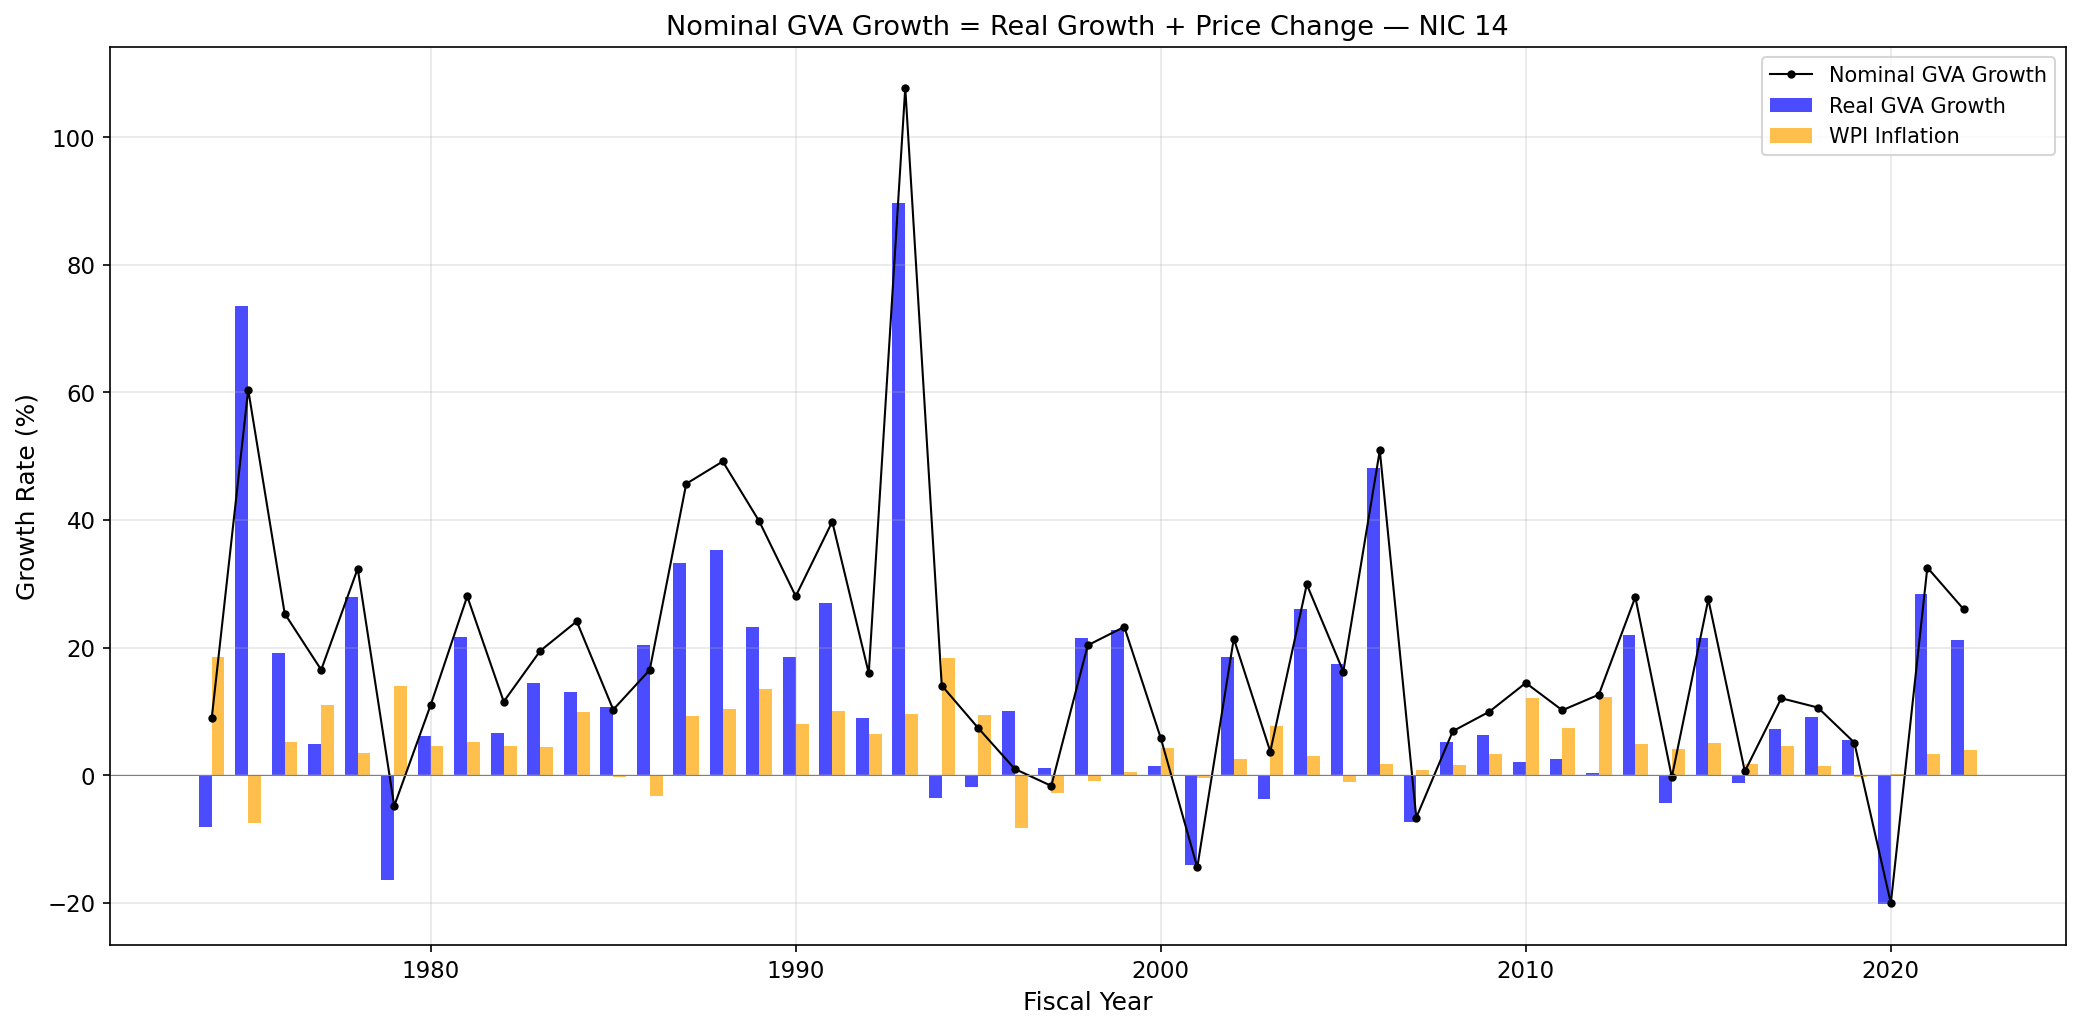

In [93]:
# 4.1 Nominal vs Real GVA growth decomposition
print('[4.1] Plotting growth decomposition...')
growth_df = df[['YearStart', 'Gross Value Added', 'Real_GVA', 'WPI']].dropna().copy()
if len(growth_df) > 2:
    growth_df['g_nominal'] = growth_df['Gross Value Added'].pct_change() * 100
    growth_df['g_real'] = growth_df['Real_GVA'].pct_change() * 100
    growth_df['g_deflator'] = growth_df['WPI'].pct_change() * 100
    growth_df = growth_df.iloc[1:]
    
    fig, ax = plt.subplots(figsize=(14, 7))
    width = 0.35
    x = growth_df['YearStart']
    ax.bar(x - width/2, growth_df['g_real'], width, label='Real GVA Growth', color='blue', alpha=0.7)
    ax.bar(x + width/2, growth_df['g_deflator'], width, label='WPI Inflation', color='orange', alpha=0.7)
    ax.plot(x, growth_df['g_nominal'], 'k-o', markersize=3, label='Nominal GVA Growth', linewidth=1)
    ax.axhline(0, color='grey', linewidth=0.5)
    ax.set_xlabel('Fiscal Year')
    ax.set_ylabel('Growth Rate (%)')
    ax.set_title('Nominal GVA Growth = Real Growth + Price Change — NIC 14')
    ax.legend()
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'Fig14_GrowthDecomposition.png', bbox_inches='tight')
    plt.show()

[4.2] Plotting apparel terms of trade...


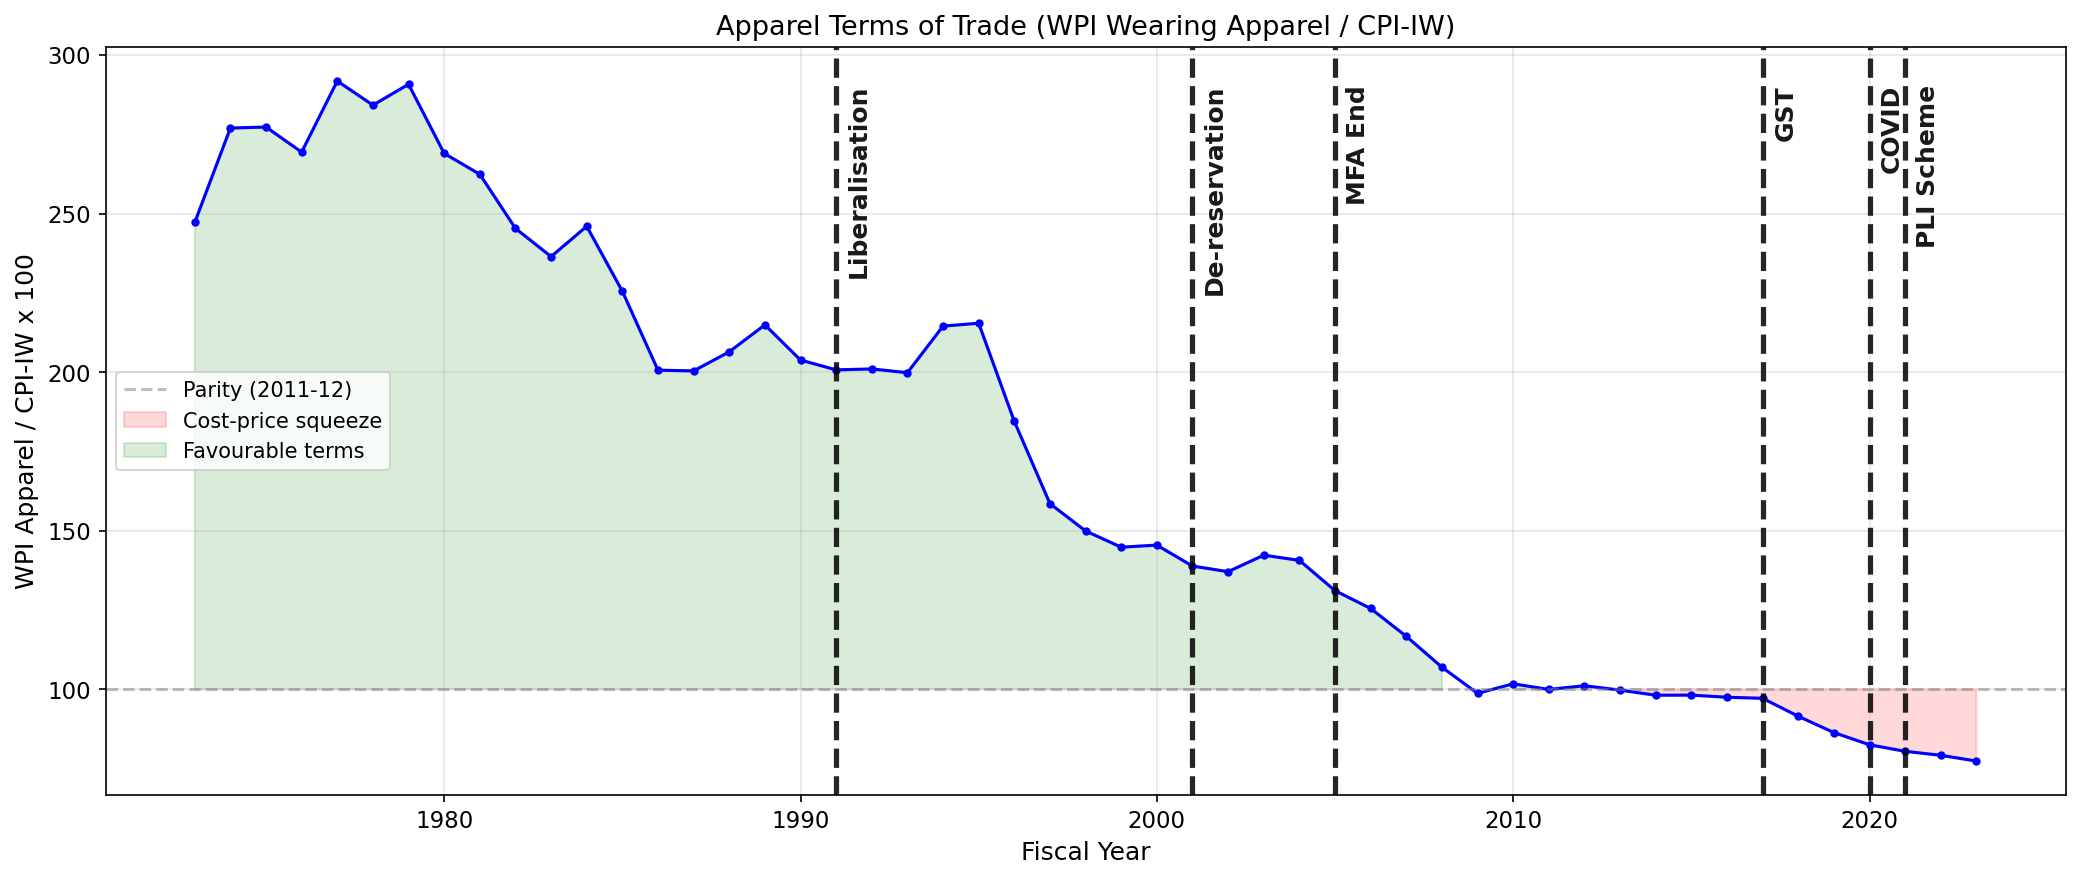

In [94]:
# 4.2 Terms of Trade (WPI / CPI-IW)
print('[4.2] Plotting apparel terms of trade...')
tot_df = df[['YearStart', 'WPI', 'CPI']].dropna().copy()
if len(tot_df) > 0:
    tot_df['ToT'] = tot_df['WPI'] / tot_df['CPI'] * 100
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(tot_df['YearStart'], tot_df['ToT'], 'b-o', markersize=3, linewidth=1.5)
    ax.axhline(100, color='grey', linestyle='--', alpha=0.5, label='Parity (2011-12)')
    ax.fill_between(tot_df['YearStart'], tot_df['ToT'], 100,
                    where=tot_df['ToT'] < 100, color='red', alpha=0.15, label='Cost-price squeeze')
    ax.fill_between(tot_df['YearStart'], tot_df['ToT'], 100,
                    where=tot_df['ToT'] >= 100, color='green', alpha=0.15, label='Favourable terms')
    ax.set_xlabel('Fiscal Year')
    ax.set_ylabel('WPI Apparel / CPI-IW x 100')
    ax.set_title('Apparel Terms of Trade (WPI Wearing Apparel / CPI-IW)')
    ax.legend()
    add_policy_lines(ax)
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'Fig15_TermsOfTrade.png', bbox_inches='tight')
    plt.show()

[4.3] Plotting: Investment intensity around ATUFS...


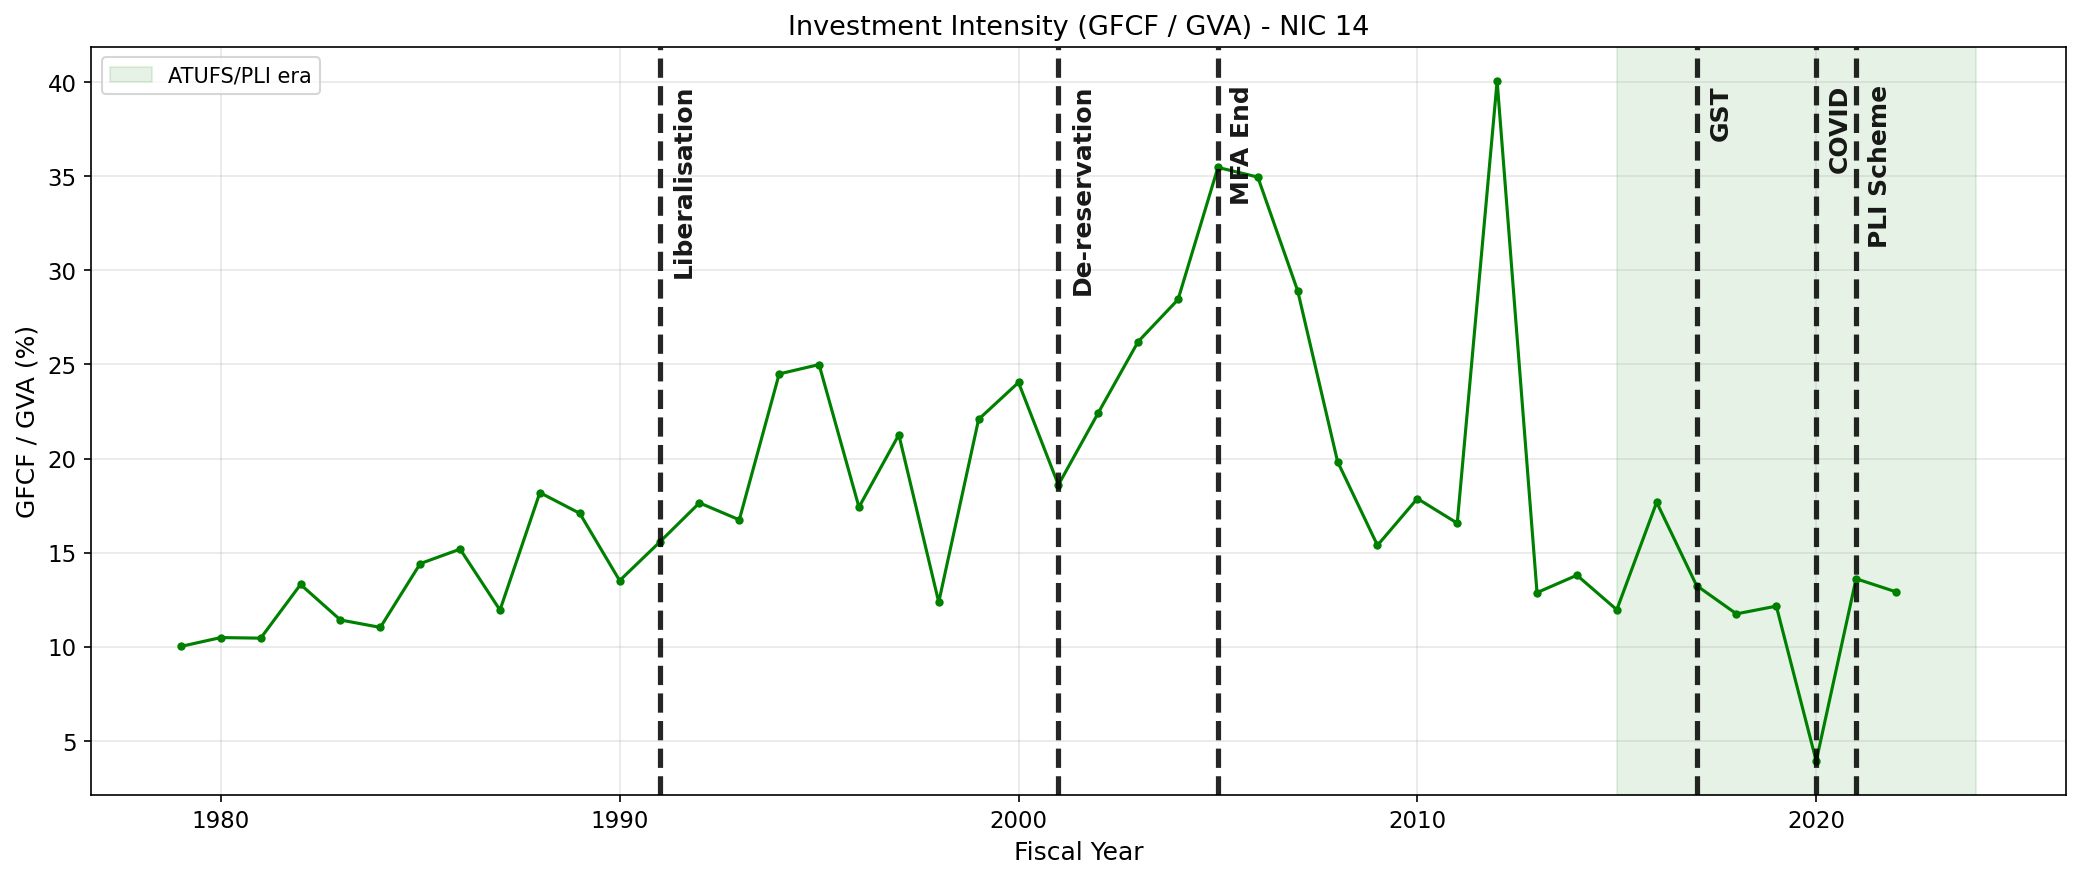

In [95]:
# 4.3 Figure: GFCF/GVA ratio around ATUFS
print('[4.3] Plotting: Investment intensity around ATUFS...')
fig, ax = plt.subplots(figsize=(14, 6))
mask = df['InvestmentRate'].notna()
ax.plot(df.loc[mask, 'YearStart'], df.loc[mask, 'InvestmentRate'] * 100,
        'g-o', markersize=3, linewidth=1.5)
ax.set_xlabel('Fiscal Year')
ax.set_ylabel('GFCF / GVA (%)')
ax.set_title('Investment Intensity (GFCF / GVA) - NIC 14')
ax.axvspan(2015, 2024, alpha=0.1, color='green', label='ATUFS/PLI era')
add_policy_lines(ax)
ax.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / 'Fig_InvestmentIntensity_ATUFS.png', bbox_inches='tight')
plt.show()

[4.4] Plotting: Capital-Output Ratio...


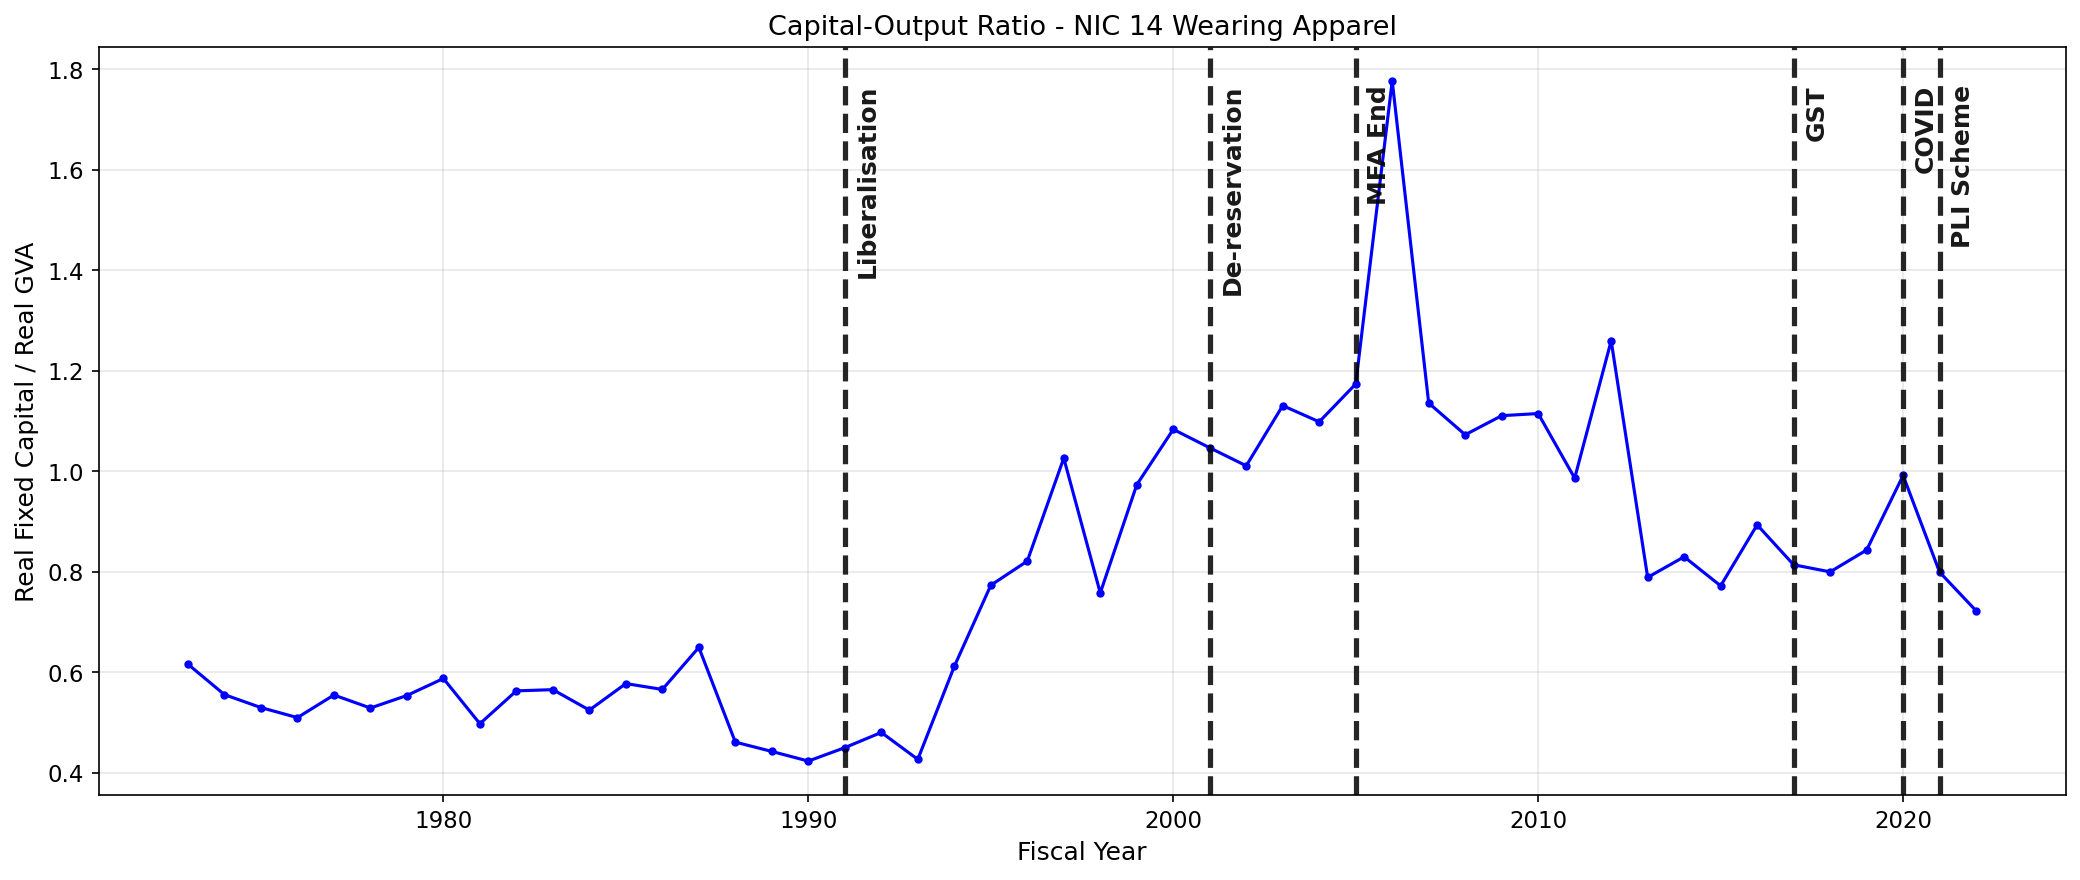

In [96]:
# 4.4 Capital-Output Ratio trend
print('[4.4] Plotting: Capital-Output Ratio...')
fig, ax = plt.subplots(figsize=(14, 6))
mask = df['CapOutputRatio'].notna()
ax.plot(df.loc[mask, 'YearStart'], df.loc[mask, 'CapOutputRatio'],
        'b-o', markersize=3, linewidth=1.5)
ax.set_xlabel('Fiscal Year')
ax.set_ylabel('Real Fixed Capital / Real GVA')
ax.set_title('Capital-Output Ratio - NIC 14 Wearing Apparel')
add_policy_lines(ax)
plt.tight_layout()
plt.savefig(FIG_DIR / 'Fig_CapitalOutputRatio.png', bbox_inches='tight')
plt.show()

In [97]:

# 4.5 Summary statistics table (full period)
print('[4.5] Building summary statistics...')
summary_vars = {
    'Real_GVA': 'Real GVA (Rs Cr, 2011-12)',
    'Real_Output': 'Real Gross Output (Rs Cr)',
    'Workers': 'Workers (in thousands)',
    'Factories': 'Number of Factories',
    'LP_GVA_Worker': 'Labour Productivity (Rs Lakh/Worker)',
    'KI_FixedCap_Worker': 'Capital Intensity (Rs Lakh/Worker)',
    'CapOutputRatio': 'Capital-Output Ratio',
    'WorkersPerFactory': 'Workers per Factory',
    'LabourShareGVA': 'Labour Share of GVA',
    'MaterialShare': 'Material Intensity',
    'RealWagePerWorker': 'Real Wage per Worker (Rs Lakh)',
    'WomenShare': 'Women Worker Share',
    'ContractShare': 'Contract Worker Share',
}

summary_data = []
for var, label in summary_vars.items():
    s = df[var].dropna()
    if len(s) == 0:
        continue
    summary_data.append({
        'Variable': label,
        'N': len(s),
        'Mean': s.mean(),
        'Std': s.std(),
        'Min': s.min(),
        'Max': s.max(),
        'First Year': df.loc[s.index[0], 'YearStart'],
        'Last Year': df.loc[s.index[-1], 'YearStart'],
    })

summary_table = pd.DataFrame(summary_data)
try:
    summary_table.round(3).to_csv(TABLE_DIR / 'summary_statistics.csv', index=False)
    print('  Saved summary_statistics.csv')
except PermissionError:
    print('  WARNING: summary_statistics.csv is locked (close Excel?). Skipping CSV write.')
summary_table.round(3)


[4.5] Building summary statistics...
  Saved summary_statistics.csv


Variable   N       Mean        Std       Min  \
0              Real GVA (Rs Cr, 2011-12)  50   9462.323  10143.213   121.022   
1              Real Gross Output (Rs Cr)  51  43525.031  44572.437   823.333   
2                 Workers (in thousands)  51    432.099    378.917    28.508   
3                    Number of Factories  51   5520.510   3619.777  1047.000   
4   Labour Productivity (Rs Lakh/Worker)  50      1.672      0.776     0.405   
5     Capital Intensity (Rs Lakh/Worker)  51      1.459      0.930     0.225   
6                   Capital-Output Ratio  50      0.786      0.283     0.424   
7                    Workers per Factory  51     63.681     30.099    25.376   
8                    Labour Share of GVA  50      0.415      0.119     0.173   
9                     Material Intensity  51      0.540      0.056     0.457   
10        Real Wage per Worker (Rs Lakh)  51      0.954      0.272     0.541   
11                    Women Worker Share  26      0.514      0.032     0.467   
12                 Contract Worker Share  26      0.109      0.026     0.049   

           Max  First Year  Last Year  
0    36623.759        1973       2022  
1   151728.749        1973       2023  
2     1153.844        1973       2023  
3    12824.000        1973       2023  
4        3.194        1973       2022  
5        3.740        1973       2023  
6        1.776        1973       2022  
7      133.691        1973       2023  
8        0.602        1973       2022  
9        0.759        1973       2023  
10       1.456        1973       2023  
11       0.587        1998       2023  
12       0.148        1998       2023

---
# Advanced Analyses: Capital Deflation, TFP, Trade, Convergence Robustness, Employment Elasticity

Capital Deflator Sensitivity Analysis

[A.1] Loading WPI Machinery and Equipment...
  WPI Machinery: 14 years (2011-2024)
  Base 2011-12 = 100.00 -> rebased to 100

[A.2] Loading GFCF at Current and Constant Prices...
  GFCF data: 76 years (1950-2025)
  IDP at 2011-12 (raw): 100.0000 -> rebased to 100

[A.3] Merging capital deflators into main dataframe...
  Real_FixedCapital (WPI Apparel): 51 obs
  Real_FixedCapital_Mach (WPI Machinery): 13 obs
  Real_FixedCapital_IDP (GFCF IDP): 51 obs
  NOTE: WPI Machinery covers only 2011-2024 (13 years)
        IDP covers full period back to 1950

[A.4] Plotting capital deflator sensitivity...


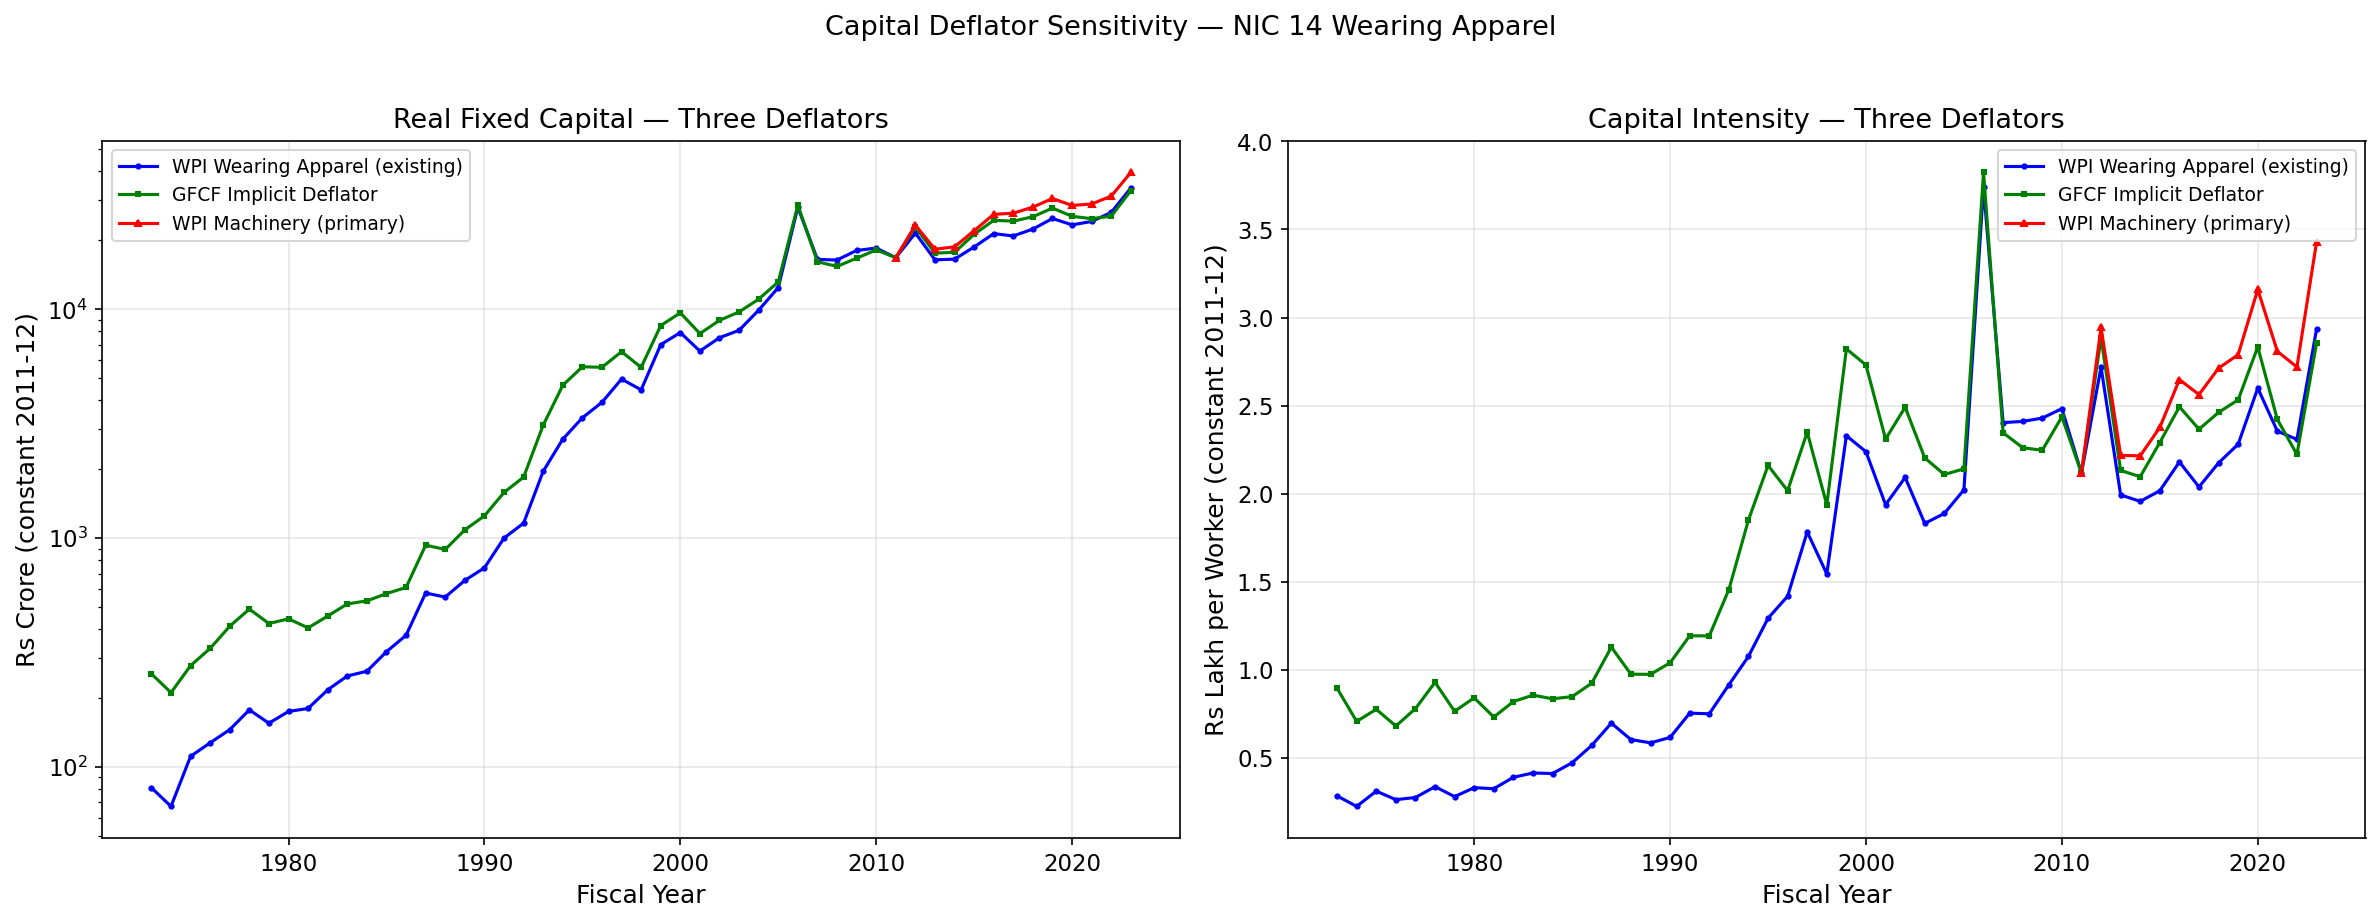


  Primary capital series (Mach + IDP fallback): 51 obs
  Capital deflator sensitivity analysis complete.


In [98]:
# Capital Deflator Sensitivity — Two New Real Capital Series
# Load WPI Machinery & Equipment and GFCF Implicit Deflator for Plant & Machinery
print('=' * 70)
print('Capital Deflator Sensitivity Analysis')
print('=' * 70)

from bs4 import BeautifulSoup
from io import StringIO

# --- 1. Load WPI Machinery and Equipment ---
print('\n[A.1] Loading WPI Machinery and Equipment...')
wpi_mach_path = BASE_DIR / 'wpi_machinery_and_equipment.xls'
with open(wpi_mach_path, 'r', encoding='utf-16') as f:
    wpi_mach_html = f.read()

soup_wpi = BeautifulSoup(wpi_mach_html, 'html.parser')
tables_wpi = soup_wpi.find_all('table')
rows_wpi = tables_wpi[1].find_all('tr')  # Data table is the second <table>

wpi_mach_data = []
for row in rows_wpi:
    cells = [c.get_text(strip=True) for c in row.find_all(['td', 'th'])]
    if len(cells) == 2:
        yr_str, val_str = cells
        # Skip header row and empty values
        if yr_str.startswith('Linking') or val_str == '' or val_str == '\xa0':
            continue
        try:
            ys = parse_fiscal_year(yr_str)
            val = float(val_str)
            wpi_mach_data.append({'YearStart': ys, 'WPI_Mach_raw': val})
        except (ValueError, TypeError):
            continue

wpi_mach_df = pd.DataFrame(wpi_mach_data).sort_values('YearStart').reset_index(drop=True)
# WPI Machinery is already on 2011-12 = 100 base (this is the 2011-12 WPI series)
# The series starts from 2012-13; assume 2011-12 = 100
base_row = pd.DataFrame([{'YearStart': 2011, 'WPI_Mach_raw': 100.0}])
wpi_mach_df = pd.concat([base_row, wpi_mach_df], ignore_index=True).sort_values('YearStart').reset_index(drop=True)
# Rebase to 2011-12 = 100 (already is, but verify)
wpi_mach_base = wpi_mach_df.loc[wpi_mach_df['YearStart'] == 2011, 'WPI_Mach_raw'].values[0]
wpi_mach_df['WPI_Machinery'] = (wpi_mach_df['WPI_Mach_raw'] / wpi_mach_base) * 100
print(f'  WPI Machinery: {len(wpi_mach_df)} years ({wpi_mach_df["YearStart"].min()}-{wpi_mach_df["YearStart"].max()})')
print(f'  Base 2011-12 = {wpi_mach_base:.2f} -> rebased to 100')

# --- 2. Load GFCF and derive Implicit Deflator for Plant & Machinery (IDP) ---
print('\n[A.2] Loading GFCF at Current and Constant Prices...')
gfcf_path = BASE_DIR / 'GFCF at Current and Constant Price to get IDP.xls'
with open(gfcf_path, 'r', encoding='utf-8') as f:
    gfcf_html = f.read()

soup_gfcf = BeautifulSoup(gfcf_html, 'html.parser')
tables_gfcf = soup_gfcf.find_all('table')
rows_gfcf = tables_gfcf[1].find_all('tr')  # Data table

gfcf_data = []
for row in rows_gfcf:
    cells = [c.get_text(strip=True) for c in row.find_all(['td', 'th'])]
    if len(cells) == 3:
        yr_str, nom_str, real_str = cells
        try:
            ys = parse_fiscal_year(yr_str)
            nom = float(nom_str)
            real = float(real_str)
            gfcf_data.append({'YearStart': ys, 'GFCF_Nominal': nom, 'GFCF_Real': real})
        except (ValueError, TypeError):
            continue

gfcf_df = pd.DataFrame(gfcf_data).sort_values('YearStart').reset_index(drop=True)

# Derive Implicit Deflator: IDP = (Nominal GFCF / Real GFCF) * 100
gfcf_df['IDP_raw'] = (gfcf_df['GFCF_Nominal'] / gfcf_df['GFCF_Real']) * 100

# Rebase IDP to 2011-12 = 100
idp_2011 = gfcf_df.loc[gfcf_df['YearStart'] == 2011, 'IDP_raw'].values[0]
gfcf_df['IDP'] = (gfcf_df['IDP_raw'] / idp_2011) * 100
print(f'  GFCF data: {len(gfcf_df)} years ({gfcf_df["YearStart"].min()}-{gfcf_df["YearStart"].max()})')
print(f'  IDP at 2011-12 (raw): {idp_2011:.4f} -> rebased to 100')

# --- 3. Merge deflators into df ---
print('\n[A.3] Merging capital deflators into main dataframe...')
# Drop existing columns to make re-runs idempotent
for c in ['WPI_Machinery', 'IDP', 'Real_FixedCapital_Mach', 'Real_FixedCapital_IDP',
          'KI_Mach', 'KI_IDP', 'COR_Mach', 'COR_IDP',
          'Real_FixedCapital_Primary', 'KI_Primary', 'COR_Primary']:
    if c in df.columns:
        df = df.drop(columns=[c])
# Also drop any suffixed duplicates from prior partial runs
df = df.loc[:, ~df.columns.str.match(r'^(WPI_Machinery|IDP)(_[xy])?$')]

df = df.merge(wpi_mach_df[['YearStart', 'WPI_Machinery']], on='YearStart', how='left')
df = df.merge(gfcf_df[['YearStart', 'IDP']], on='YearStart', how='left')

# --- 4. Compute two new Real Fixed Capital series ---
# Real_FixedCapital (existing) = Fixed Capital deflated by WPI Wearing Apparel
# Real_FixedCapital_Mach = Fixed Capital deflated by WPI Machinery
# Real_FixedCapital_IDP = Fixed Capital deflated by IDP (GFCF implicit deflator)
df['Real_FixedCapital_Mach'] = (df['Fixed Capital'] / df['WPI_Machinery']) * 100
df['Real_FixedCapital_IDP'] = (df['Fixed Capital'] / df['IDP']) * 100

print(f'  Real_FixedCapital (WPI Apparel): {df["Real_FixedCapital"].notna().sum()} obs')
print(f'  Real_FixedCapital_Mach (WPI Machinery): {df["Real_FixedCapital_Mach"].notna().sum()} obs')
print(f'  Real_FixedCapital_IDP (GFCF IDP): {df["Real_FixedCapital_IDP"].notna().sum()} obs')
print(f'  NOTE: WPI Machinery covers only 2011-2024 ({df["Real_FixedCapital_Mach"].notna().sum()} years)')
print(f'        IDP covers full period back to 1950')

# --- 5. Re-derive capital intensity and capital-output ratio under all three deflators ---
df['KI_Mach'] = (df['Real_FixedCapital_Mach'] * 100) / (df['Workers'] * 1000)
df['KI_IDP'] = (df['Real_FixedCapital_IDP'] * 100) / (df['Workers'] * 1000)
df['COR_Mach'] = df['Real_FixedCapital_Mach'] / df['Real_GVA']
df['COR_IDP'] = df['Real_FixedCapital_IDP'] / df['Real_GVA']

# --- 6. Sensitivity comparison figure ---
print('\n[A.4] Plotting capital deflator sensitivity...')
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Real Fixed Capital under three deflators
ax1 = axes[0]
mask1 = df['Real_FixedCapital'].notna()
ax1.plot(df.loc[mask1, 'YearStart'], df.loc[mask1, 'Real_FixedCapital'],
         'b-o', ms=2, lw=1.5, label='WPI Wearing Apparel (existing)')
mask2 = df['Real_FixedCapital_IDP'].notna()
ax1.plot(df.loc[mask2, 'YearStart'], df.loc[mask2, 'Real_FixedCapital_IDP'],
         'g-s', ms=2, lw=1.5, label='GFCF Implicit Deflator')
mask3 = df['Real_FixedCapital_Mach'].notna()
ax1.plot(df.loc[mask3, 'YearStart'], df.loc[mask3, 'Real_FixedCapital_Mach'],
         'r-^', ms=3, lw=1.5, label='WPI Machinery (primary)')
ax1.set_xlabel('Fiscal Year')
ax1.set_ylabel('Rs Crore (constant 2011-12)')
ax1.set_title('Real Fixed Capital — Three Deflators')
ax1.legend(fontsize=9)
ax1.set_yscale('log')

# Panel 2: Capital Intensity under three deflators
ax2 = axes[1]
mask_ki = df['KI_FixedCap_Worker'].notna()
ax2.plot(df.loc[mask_ki, 'YearStart'], df.loc[mask_ki, 'KI_FixedCap_Worker'],
         'b-o', ms=2, lw=1.5, label='WPI Wearing Apparel (existing)')
mask_ki_idp = df['KI_IDP'].notna()
ax2.plot(df.loc[mask_ki_idp, 'YearStart'], df.loc[mask_ki_idp, 'KI_IDP'],
         'g-s', ms=2, lw=1.5, label='GFCF Implicit Deflator')
mask_ki_mach = df['KI_Mach'].notna()
ax2.plot(df.loc[mask_ki_mach, 'YearStart'], df.loc[mask_ki_mach, 'KI_Mach'],
         'r-^', ms=3, lw=1.5, label='WPI Machinery (primary)')
ax2.set_xlabel('Fiscal Year')
ax2.set_ylabel('Rs Lakh per Worker (constant 2011-12)')
ax2.set_title('Capital Intensity — Three Deflators')
ax2.legend(fontsize=9)

plt.suptitle('Capital Deflator Sensitivity — NIC 14 Wearing Apparel', fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig(FIG_DIR / 'Fig_CapitalDeflator_Sensitivity.png', bbox_inches='tight')
plt.show()

# Use Real_FixedCapital_Mach as primary going forward (where available, else fallback to IDP)
# For TFP and subsequent analysis, we use Mach where available, IDP as fallback
df['Real_FixedCapital_Primary'] = df['Real_FixedCapital_Mach'].fillna(df['Real_FixedCapital_IDP'])
df['KI_Primary'] = (df['Real_FixedCapital_Primary'] * 100) / (df['Workers'] * 1000)
df['COR_Primary'] = df['Real_FixedCapital_Primary'] / df['Real_GVA']
print(f'\n  Primary capital series (Mach + IDP fallback): {df["Real_FixedCapital_Primary"].notna().sum()} obs')
print('  Capital deflator sensitivity analysis complete.')

TFP / Growth Accounting — Solow Residual

[B.1] TFP sample: 50 observations (1973-2022)
  Alpha (labour share) range: 0.173 - 0.602, median = 0.424

[B.2] Era-wise TFP CAGR and Growth Decomposition:
Era                                                 TFP CAGR%   LP CAGR%   KI CAGR%  TFP share
------------------------------------------------------------------------------------------
Era I: Protection & MFA (1973-1990)                      3.31       6.99       0.89      47.4%
Era II: Liberalisation (1991-2000)                      -1.36       2.36       9.63     -57.9%
Era III: De-reservation & MFA End (2001-2007)            6.02       2.26       0.26     266.7%
Era IV: Post-Quota Adjustment (2008-2019)                4.46       1.70       1.93     262.5%
Era V: COVID & PLI (2020-2024)                           5.92      10.41      -7.23      56.9%

  Saved Table1B_TFP_GrowthDecomposition.csv
  Updated Table1_CAGR_by_era.csv with TFP CAGR column


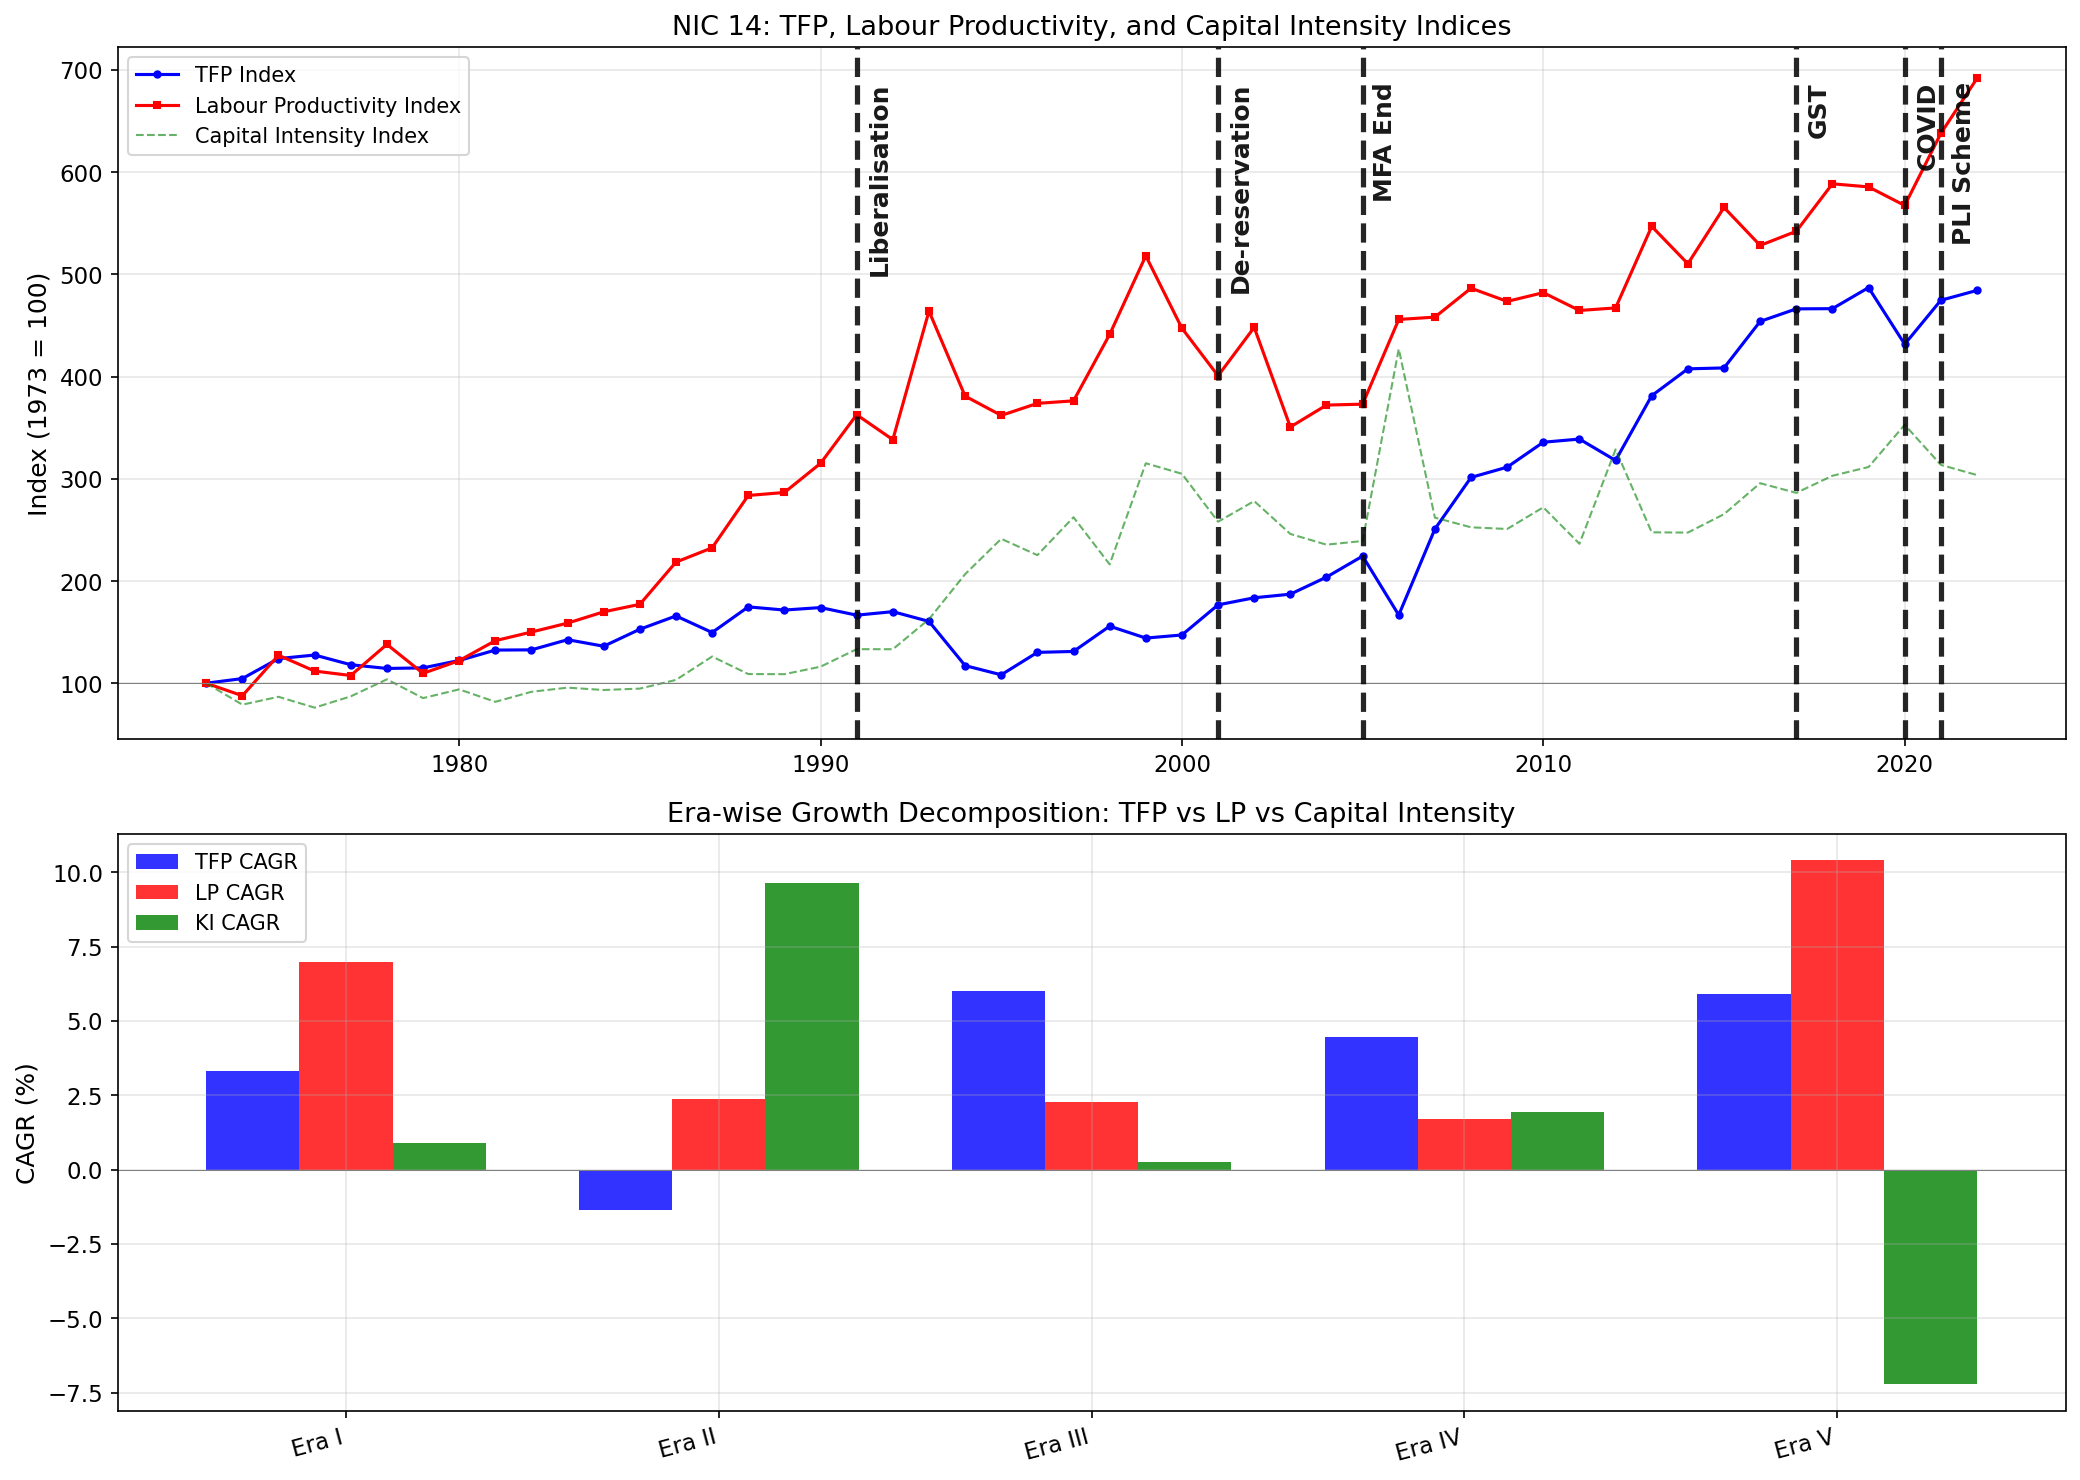


  TFP / growth accounting analysis complete.


In [99]:
# Total Factor Productivity / Growth Accounting (Solow Residual)
# Uses: Real_GVA, Real_FixedCapital_Primary (WPI Mach + IDP fallback), Workers, Total Emoluments
print('=' * 70)
print('TFP / Growth Accounting — Solow Residual')
print('=' * 70)

# Step 1: Time-varying labour share alpha
df['alpha'] = (df['Total Emoluments'] / df['Gross Value Added']).clip(0.1, 0.9)

# Step 2: Prepare TFP dataset
tfp_cols = ['YearStart', 'Real_GVA', 'Real_FixedCapital_Primary', 'Workers', 'alpha']
tfp = df[tfp_cols].dropna().copy()
print(f'\n[B.1] TFP sample: {len(tfp)} observations ({tfp["YearStart"].min()}-{tfp["YearStart"].max()})')
print(f'  Alpha (labour share) range: {tfp["alpha"].min():.3f} - {tfp["alpha"].max():.3f}, median = {tfp["alpha"].median():.3f}')

# Step 3: Log variables
tfp['logY'] = np.log(tfp['Real_GVA'])
tfp['logL'] = np.log(tfp['Workers'])
tfp['logK'] = np.log(tfp['Real_FixedCapital_Primary'])

# Step 4: Solow residual (time-varying alpha)
tfp['TFP_log'] = tfp['logY'] - tfp['alpha'] * tfp['logL'] - (1 - tfp['alpha']) * tfp['logK']

# Step 5: TFP Index (first year = 100)
tfp['TFP_index'] = np.exp(tfp['TFP_log'] - tfp['TFP_log'].iloc[0]) * 100

# LP Index for comparison
base_lp_val = (tfp.iloc[0]['Real_GVA'] * 100) / (tfp.iloc[0]['Workers'] * 1000)
tfp['LP_val'] = (tfp['Real_GVA'] * 100) / (tfp['Workers'] * 1000)
tfp['LP_index'] = (tfp['LP_val'] / base_lp_val) * 100

# KI (capital deepening) index
base_ki_val = (tfp.iloc[0]['Real_FixedCapital_Primary'] * 100) / (tfp.iloc[0]['Workers'] * 1000)
tfp['KI_val'] = (tfp['Real_FixedCapital_Primary'] * 100) / (tfp['Workers'] * 1000)
tfp['KI_index'] = (tfp['KI_val'] / base_ki_val) * 100

# Step 6: Era-wise TFP CAGR and Growth Decomposition
print('\n[B.2] Era-wise TFP CAGR and Growth Decomposition:')
print(f'{"Era":<50} {"TFP CAGR%":>10} {"LP CAGR%":>10} {"KI CAGR%":>10} {"TFP share":>10}')
print('-' * 90)

tfp_cagr_results = []
for era_name, (start, end) in ERAS.items():
    era_tfp = tfp[tfp['YearStart'].between(start, end)]
    if len(era_tfp) < 2:
        continue
    n = era_tfp['YearStart'].iloc[-1] - era_tfp['YearStart'].iloc[0]
    if n == 0:
        continue
    
    # TFP CAGR from log differences
    tfp_cagr_val = (np.exp((era_tfp['TFP_log'].iloc[-1] - era_tfp['TFP_log'].iloc[0]) / n) - 1) * 100
    
    # LP CAGR
    lp_start, lp_end = era_tfp['LP_val'].iloc[0], era_tfp['LP_val'].iloc[-1]
    lp_cagr_val = ((lp_end / lp_start) ** (1/n) - 1) * 100 if lp_start > 0 and lp_end > 0 else np.nan
    
    # KI CAGR (capital deepening)
    ki_start, ki_end = era_tfp['KI_val'].iloc[0], era_tfp['KI_val'].iloc[-1]
    ki_cagr_val = ((ki_end / ki_start) ** (1/n) - 1) * 100 if ki_start > 0 and ki_end > 0 else np.nan
    
    # Growth decomposition: LP growth ≈ TFP growth + (1-alpha_avg) * K/L growth
    alpha_avg = era_tfp['alpha'].mean()
    capital_deepening_contrib = (1 - alpha_avg) * ki_cagr_val if pd.notna(ki_cagr_val) else np.nan
    tfp_share_of_lp = (tfp_cagr_val / lp_cagr_val * 100) if pd.notna(lp_cagr_val) and lp_cagr_val != 0 else np.nan
    
    print(f'{era_name:<50} {tfp_cagr_val:>10.2f} {lp_cagr_val:>10.2f} {ki_cagr_val:>10.2f} {tfp_share_of_lp:>9.1f}%')
    
    tfp_cagr_results.append({
        'Era': era_name,
        'TFP_CAGR': round(tfp_cagr_val, 2),
        'LP_CAGR': round(lp_cagr_val, 2),
        'KI_CAGR': round(ki_cagr_val, 2),
        'Alpha_avg': round(alpha_avg, 3),
        'Capital_Deepening_Contrib': round(capital_deepening_contrib, 2) if pd.notna(capital_deepening_contrib) else np.nan,
        'TFP_Share_of_LP_%': round(tfp_share_of_lp, 1) if pd.notna(tfp_share_of_lp) else np.nan,
    })

tfp_cagr_df = pd.DataFrame(tfp_cagr_results)
tfp_cagr_df.to_csv(TABLE_DIR / 'Table1B_TFP_GrowthDecomposition.csv', index=False)
print(f'\n  Saved Table1B_TFP_GrowthDecomposition.csv')

# Step 7: Update Table 1 (add TFP CAGR column)
try:
    table1 = pd.read_csv(TABLE_DIR / 'Table1_CAGR_by_era.csv')
    tfp_merge = tfp_cagr_df[['Era', 'TFP_CAGR']].copy()
    table1 = table1.merge(tfp_merge, on='Era', how='left')
    table1.to_csv(TABLE_DIR / 'Table1_CAGR_by_era.csv', index=False)
    print('  Updated Table1_CAGR_by_era.csv with TFP CAGR column')
except Exception as e:
    print(f'  Could not update Table 1: {e}')

# Step 8: Plot TFP Growth Accounting figure (dual-panel)
fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [1.2, 1]})

# Top panel: TFP index and LP index
ax_top.plot(tfp['YearStart'], tfp['TFP_index'], 'b-o', ms=3, lw=1.5, label='TFP Index')
ax_top.plot(tfp['YearStart'], tfp['LP_index'], 'r-s', ms=3, lw=1.5, label='Labour Productivity Index')
ax_top.plot(tfp['YearStart'], tfp['KI_index'], 'g--', ms=2, lw=1, alpha=0.6, label='Capital Intensity Index')
ax_top.axhline(100, color='grey', lw=0.5)
ax_top.set_ylabel(f'Index ({int(tfp["YearStart"].iloc[0])} = 100)')
ax_top.set_title('NIC 14: TFP, Labour Productivity, and Capital Intensity Indices')
ax_top.legend()
add_policy_lines(ax_top)

# Bottom panel: Era-wise bar chart
if len(tfp_cagr_df) > 0:
    era_labels = [e.split(':')[0] for e in tfp_cagr_df['Era']]
    x = np.arange(len(era_labels))
    width = 0.25
    ax_bot.bar(x - width, tfp_cagr_df['TFP_CAGR'], width, label='TFP CAGR', color='blue', alpha=0.8)
    ax_bot.bar(x, tfp_cagr_df['LP_CAGR'], width, label='LP CAGR', color='red', alpha=0.8)
    ax_bot.bar(x + width, tfp_cagr_df['KI_CAGR'], width, label='KI CAGR', color='green', alpha=0.8)
    ax_bot.set_xticks(x)
    ax_bot.set_xticklabels(era_labels, rotation=15, ha='right')
    ax_bot.set_ylabel('CAGR (%)')
    ax_bot.set_title('Era-wise Growth Decomposition: TFP vs LP vs Capital Intensity')
    ax_bot.legend()
    ax_bot.axhline(0, color='grey', lw=0.5)

plt.tight_layout()
plt.savefig(FIG_DIR / 'Fig_TFP_GrowthAccounting.png', bbox_inches='tight')
plt.show()

# Merge TFP index back into df (drop existing to make re-runs idempotent)
for c in ['TFP_index', 'TFP_log']:
    if c in df.columns:
        df = df.drop(columns=[c])
df = df.loc[:, ~df.columns.str.match(r'^(TFP_index|TFP_log)(_[xy])?$')]
df = df.merge(tfp[['YearStart', 'TFP_index', 'TFP_log']], on='YearStart', how='left')
print('\n  TFP / growth accounting analysis complete.')

Summarized conversation history

In [100]:
# Beta-Convergence Robustness (HC3 + Leave-One-Out)
# Runs after the balanced panel is constructed in Block 3
print('=' * 70)
print('Beta-Convergence Robustness Analysis')
print('=' * 70)

import statsmodels.api as sm

# Re-construct beta-convergence data from balanced panel
initial_yr_d = 1998
final_yr_d = 2022

init_d = states_panel[states_panel['YearStart'] == initial_yr_d][['State', 'LP_GVA_Worker']].dropna()
init_d = init_d.copy()
init_d.columns = ['State', 'LP_initial']
final_d = states_panel[states_panel['YearStart'] == final_yr_d][['State', 'LP_GVA_Worker']].dropna()
final_d = final_d.copy()
final_d.columns = ['State', 'LP_final']

conv_df = init_d.merge(final_d, on='State')
print(f'\n[D.1] N = {len(conv_df)} states in convergence sample')
print(f'  States: {", ".join(sorted(conv_df["State"].tolist()))}')

if len(conv_df) >= 5:
    n_years_d = final_yr_d - initial_yr_d
    conv_df['growth'] = (np.log(conv_df['LP_final']) - np.log(conv_df['LP_initial'])) / n_years_d
    conv_df['log_initial'] = np.log(conv_df['LP_initial'])
    
    # [D.2] OLS with HC3 heteroskedasticity-robust standard errors
    print('\n[D.2] OLS with HC3 robust standard errors:')
    X = sm.add_constant(conv_df['log_initial'])
    y = conv_df['growth']
    model_hc3 = sm.OLS(y, X).fit(cov_type='HC3')
    print(model_hc3.summary())
    
    beta_hc3 = model_hc3.params['log_initial']
    pval_hc3 = model_hc3.pvalues['log_initial']
    print(f'\n  Beta (HC3) = {beta_hc3:.4f}, p-value = {pval_hc3:.4f}')
    print(f'  {"Significant" if pval_hc3 < 0.05 else "NOT significant"} at 5% level')
    
    # [D.3] Leave-one-out (LOO) analysis
    print('\n[D.3] Leave-one-out analysis:')
    loo_results = []
    for idx, excluded_state in enumerate(conv_df['State']):
        loo_data = conv_df[conv_df['State'] != excluded_state]
        X_loo = sm.add_constant(loo_data['log_initial'])
        y_loo = loo_data['growth']
        model_loo = sm.OLS(y_loo, X_loo).fit(cov_type='HC3')
        loo_results.append({
            'Excluded_State': excluded_state,
            'Beta': model_loo.params['log_initial'],
            'P_value': model_loo.pvalues['log_initial'],
            'R_squared': model_loo.rsquared,
            'N': len(loo_data),
        })
    
    loo_df = pd.DataFrame(loo_results)
    
    # Flag influential states
    loo_df['Sign_Changed'] = (loo_df['Beta'] > 0) != (beta_hc3 > 0)
    loo_df['Significance_Changed'] = (loo_df['P_value'] < 0.05) != (pval_hc3 < 0.05)
    loo_df['Influential'] = loo_df['Sign_Changed'] | loo_df['Significance_Changed']
    
    print(f'\n{"Excluded State":<25} {"Beta":>8} {"P-value":>10} {"R²":>8} {"Flag":>12}')
    print('-' * 65)
    for _, row in loo_df.iterrows():
        flag = '*** INFLUENTIAL' if row['Influential'] else ''
        print(f'{row["Excluded_State"]:<25} {row["Beta"]:>8.4f} {row["P_value"]:>10.4f} {row["R_squared"]:>8.3f} {flag}')
    
    if loo_df['Influential'].any():
        print(f'\n  WARNING: Excluding {loo_df[loo_df["Influential"]]["Excluded_State"].tolist()} changes sign or significance of beta.')
    else:
        print(f'\n  ROBUST: No single state exclusion changes sign or significance of beta.')
    
    loo_df.to_csv(TABLE_DIR / 'Table_BetaConvergence_LOO.csv', index=False)
    print(f'  Saved Table_BetaConvergence_LOO.csv')

print('\n  Beta-convergence robustness analysis complete.')

Beta-Convergence Robustness Analysis

[D.1] N = 13 states in convergence sample
  States: Andhra Pradesh, Delhi, Gujarat, Haryana, Karnataka, Kerala, Madhya Pradesh, Maharashtra, Punjab, Rajasthan, Tamil Nadu, Uttar Pradesh, West Bengal

[D.2] OLS with HC3 robust standard errors:
                            OLS Regression Results                            
Dep. Variable:                 growth   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     67.34
Date:                Fri, 20 Feb 2026   Prob (F-statistic):           5.13e-06
Time:                        02:12:16   Log-Likelihood:                 40.415
No. Observations:                  13   AIC:                            -76.83
Df Residuals:                      11   BIC:                            -75.70
Df Model:                           1                                         
Covarian


Excluded State                Beta    P-value       R²         Flag
-----------------------------------------------------------------
Andhra Pradesh             -0.0322     0.0000    0.818 
Delhi                      -0.0299     0.0000    0.756 
Gujarat                    -0.0294     0.0000    0.798 
Haryana                    -0.0302     0.0000    0.814 
Karnataka                  -0.0302     0.0000    0.798 
Kerala                     -0.0282     0.0000    0.779 
Madhya Pradesh             -0.0298     0.0000    0.779 
Maharashtra                -0.0307     0.0000    0.813 
Punjab                     -0.0293     0.0000    0.814 
Rajasthan                  -0.0292     0.0000    0.772 
Tamil Nadu                 -0.0304     0.0000    0.814 
Uttar Pradesh              -0.0289     0.0000    0.797 
West Bengal                -0.0284     0.0000    0.884 

  ROBUST: No single state exclusion changes sign or significance of beta.
  Saved Table_BetaConvergence_LOO.csv

  Beta-convergence robu

Export Intensity and Trade Analysis

[E.1] Loading apparel trade data files (HS 61+62)...
  TradeData 1990-2001.csv: 24 rows, years 1990-2001
  TradeData 2002-13.csv: 24 rows, years 2002-2013
  TradeData 2014-25.csv: 22 rows, years 2014-2024

  Combined apparel export data: 35 years (1990-2024)

  Apparel export data with exchange rate: 35 years
 YearStart  Apparel_Exports_USD_Bn  Apparel_Exports_RsCrore
      1990                2.211410              3869.966688
      1991                2.203592              5010.968062
      1992                2.673726              6930.298813
      1993                2.586085              7884.972750
      1994                3.282066             10295.841795
      1995                3.664615             11884.346160
      1996                3.753329             13298.045561
      1997                3.878948             14084.460072
      1998                4.364594             18008.316626
      1999                4.794519             20645

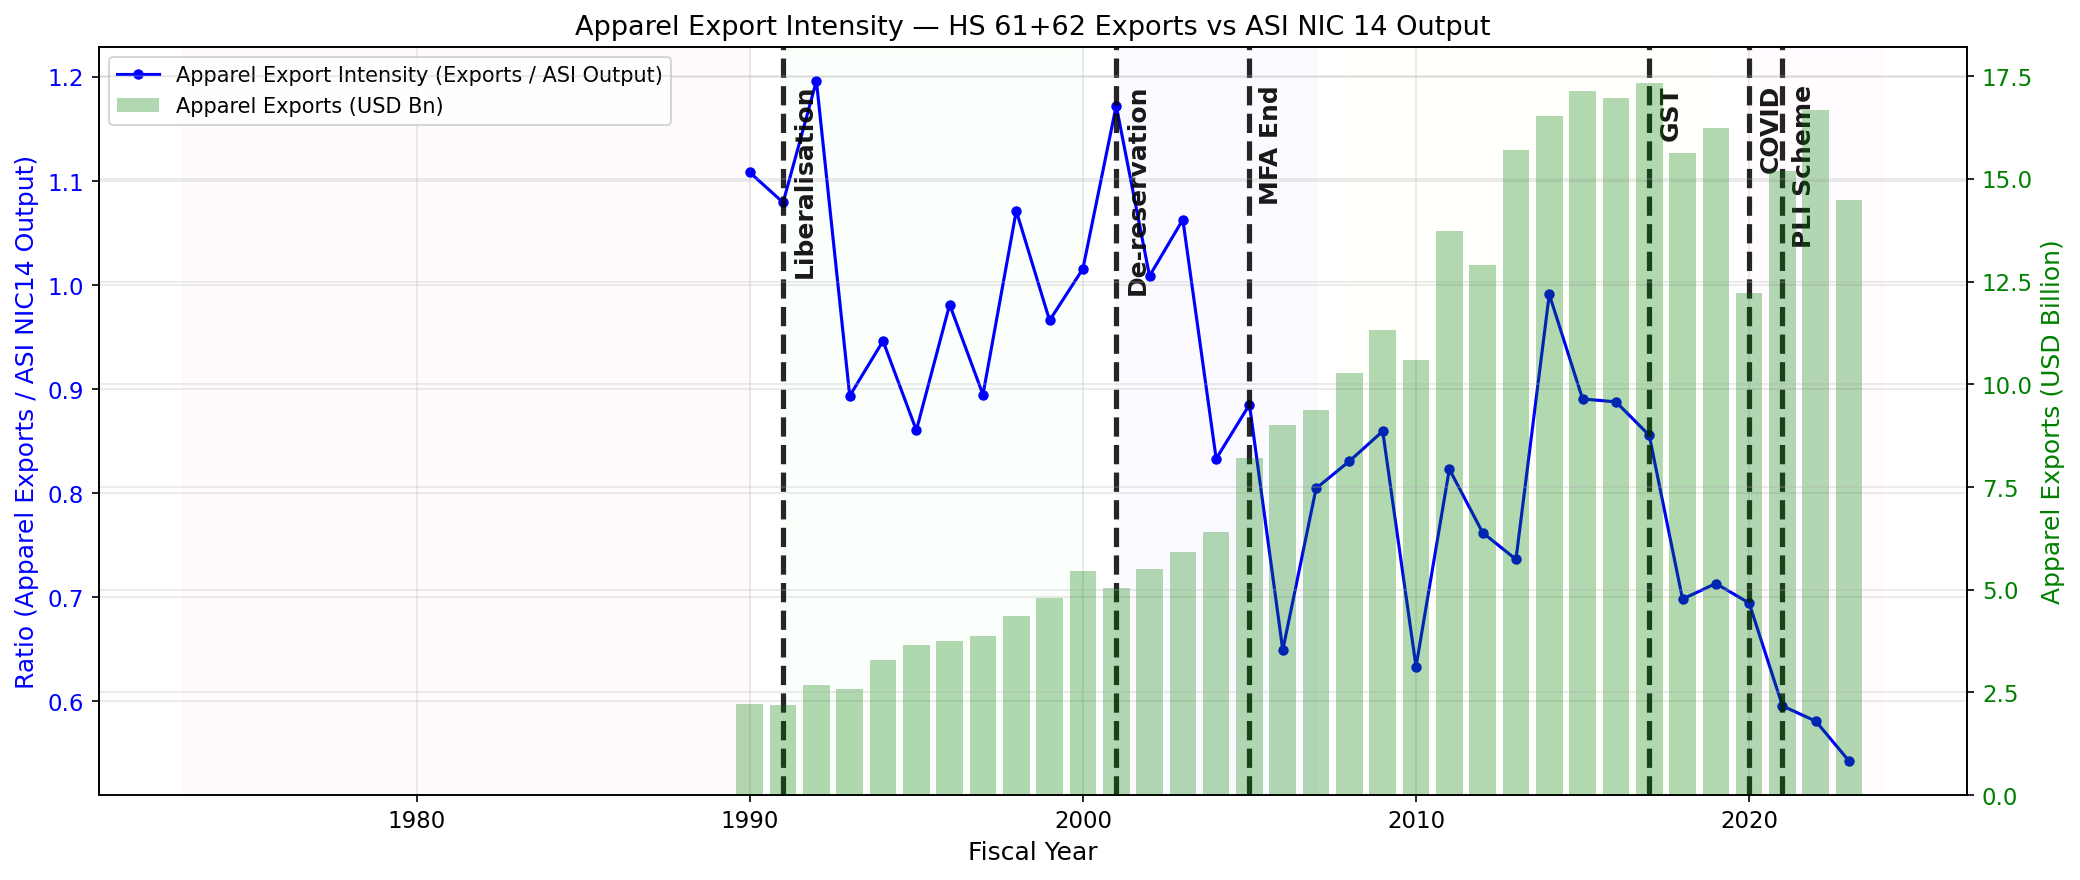

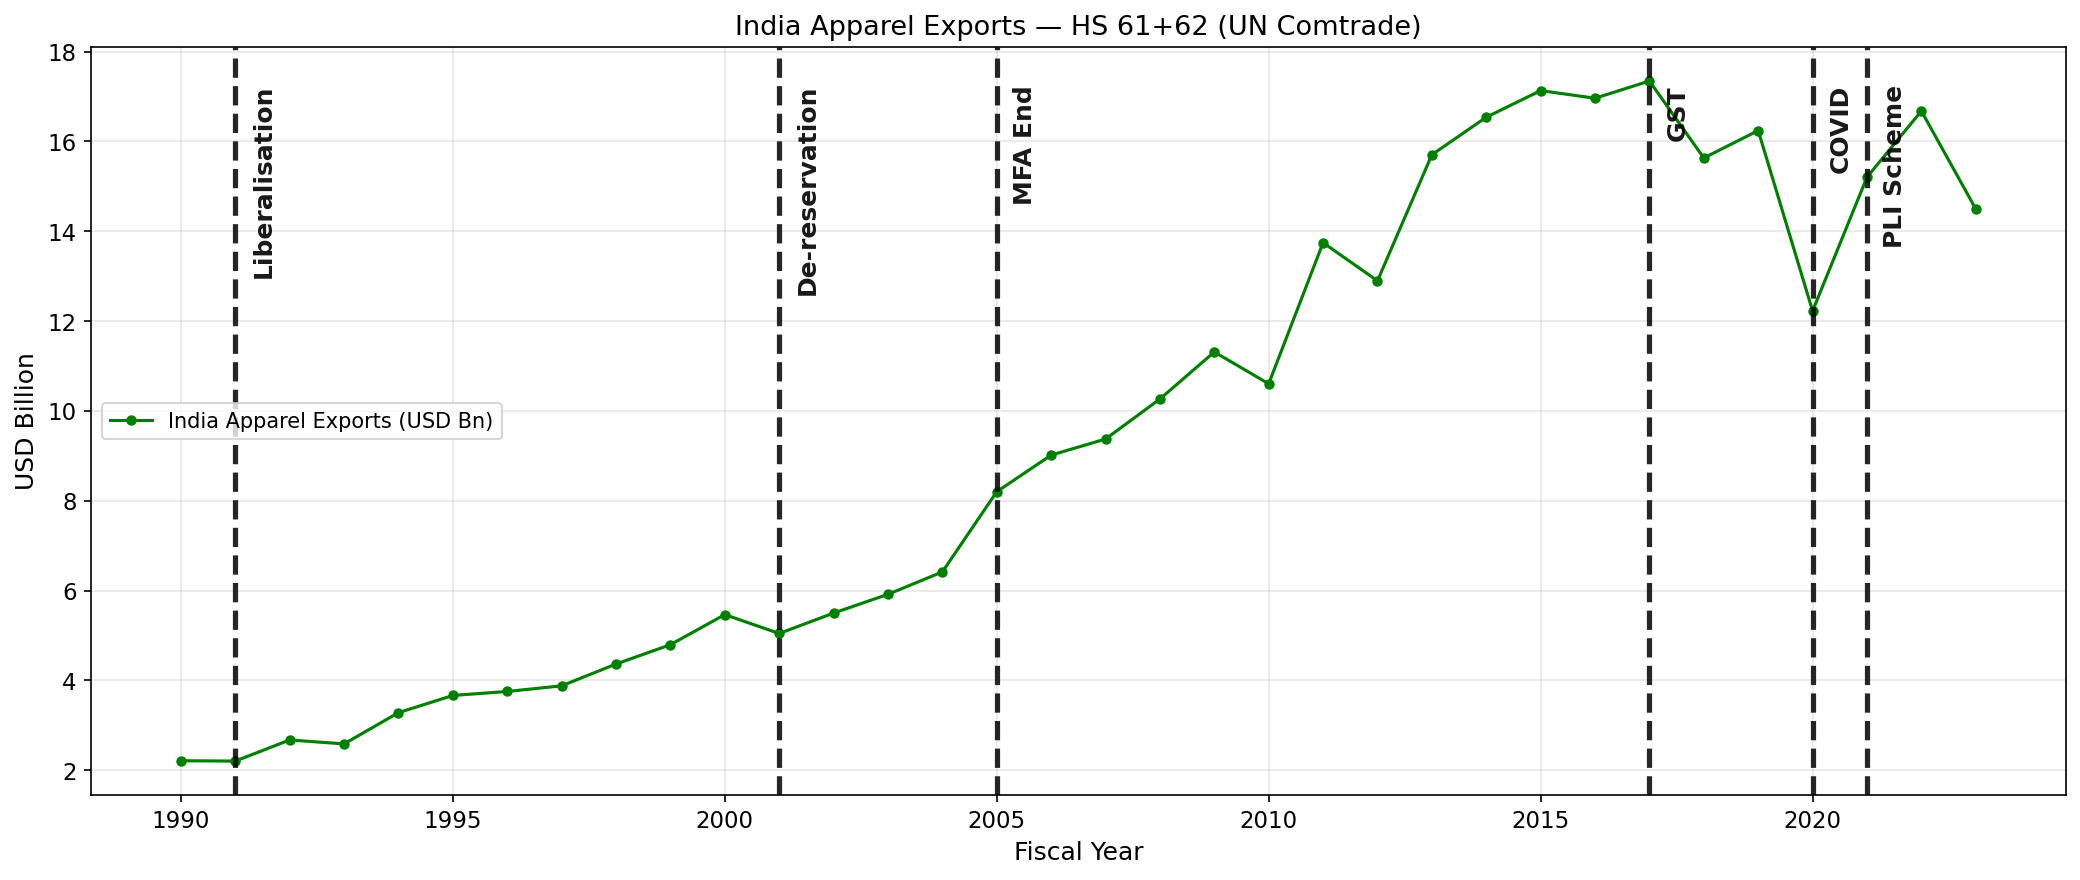


  Export intensity analysis complete.


In [101]:
# Apparel Export Intensity and Trade Analysis
# Trade CSVs contain India's apparel exports (HS 61 + 62) from UN Comtrade (fobvalue in USD)
print('=' * 70)
print('Export Intensity and Trade Analysis')
print('=' * 70)

# --- 1. Load and concatenate trade CSVs ---
print('\n[E.1] Loading apparel trade data files (HS 61+62)...')
trade_files = [
    'TradeData 1990-2001.csv',
    'TradeData 2002-13.csv',
    'TradeData 2014-25.csv',
]

trade_dfs = []
for tf in trade_files:
    try:
        tdf = pd.read_csv(BASE_DIR / tf)
        tdf.columns = [str(c).strip() for c in tdf.columns]

        if 'fobvalue' in tdf.columns:
            tdf['fobvalue'] = pd.to_numeric(tdf['fobvalue'], errors='coerce')

        # Robust year extraction
        year = pd.to_numeric(tdf.get('refYear'), errors='coerce')
        if year.isna().all() or (year.max(skipna=True) < 1900):
            year = pd.to_numeric(tdf.get('period'), errors='coerce')
        if year.isna().all() or (year.max(skipna=True) < 1900):
            year = pd.to_numeric(
                tdf.get('refPeriodId').astype(str).str.slice(0, 4),
                errors='coerce',
            )
        tdf['year'] = year

        trade_dfs.append(tdf)
        y_min = int(tdf['year'].min()) if tdf['year'].notna().any() else None
        y_max = int(tdf['year'].max()) if tdf['year'].notna().any() else None
        print(f'  {tf}: {len(tdf)} rows, years {y_min}-{y_max}')
    except Exception as e:
        print(f'  ERROR loading {tf}: {e}')

trade_all = pd.concat(trade_dfs, ignore_index=True)
trade_all = trade_all.dropna(subset=['year', 'fobvalue']).copy()
trade_all['year'] = pd.to_numeric(trade_all['year'], errors='coerce')
trade_all = trade_all[(trade_all['year'] >= 1900) & (trade_all['year'] <= 2100)].copy()

# Sum HS 61 + 62 per year (file 1 has separate rows per HS code)
trade_all = trade_all.groupby('year', as_index=False)['fobvalue'].sum()
trade_all = trade_all.sort_values('year').reset_index(drop=True)

print(f'\n  Combined apparel export data: {len(trade_all)} years '
      f'({int(trade_all["year"].min())}-{int(trade_all["year"].max())})')

# --- 2. Convert to Rs Crore using approximate USD/INR exchange rates ---
USD_INR = {
    1988: 13.92, 1989: 16.23, 1990: 17.50, 1991: 22.74, 1992: 25.92,
    1993: 30.49, 1994: 31.37, 1995: 32.43, 1996: 35.43, 1997: 36.31,
    1998: 41.26, 1999: 43.06, 2000: 44.94, 2001: 47.19, 2002: 48.61,
    2003: 46.58, 2004: 45.32, 2005: 44.10, 2006: 45.31, 2007: 41.35,
    2008: 43.51, 2009: 48.41, 2010: 45.73, 2011: 46.67, 2012: 53.44,
    2013: 58.60, 2014: 61.03, 2015: 64.15, 2016: 67.20, 2017: 65.12,
    2018: 68.39, 2019: 70.42, 2020: 74.10, 2021: 73.93, 2022: 78.60,
    2023: 82.60, 2024: 83.50, 2025: 85.50,
}

trade_all['refYear'] = trade_all['year'].astype(int)
trade_all['USD_INR_rate'] = trade_all['refYear'].map(USD_INR)
trade_all['Apparel_Exports_USD_Bn'] = trade_all['fobvalue'] / 1e9
trade_all['Apparel_Exports_RsCrore'] = (trade_all['fobvalue'] * trade_all['USD_INR_rate']) / 1e7

trade_all['YearStart'] = trade_all['refYear']

trade_df = trade_all[['YearStart', 'Apparel_Exports_USD_Bn', 'Apparel_Exports_RsCrore', 'fobvalue']].dropna(subset=['Apparel_Exports_RsCrore'])
print(f'\n  Apparel export data with exchange rate: {len(trade_df)} years')
print(trade_df[['YearStart', 'Apparel_Exports_USD_Bn', 'Apparel_Exports_RsCrore']].to_string(index=False))

# --- 3. Merge into main df ---
print('\n[E.2] Merging apparel export data into main dataframe...')
for c in ['Apparel_Exports_USD_Bn', 'Apparel_Exports_RsCrore', 'Export_Intensity',
          'Exports_USD_Bn', 'Exports_RsCrore', 'ExportRatio_RealOutput']:
    if c in df.columns:
        df = df.drop(columns=[c])

df = df.merge(trade_df[['YearStart', 'Apparel_Exports_USD_Bn', 'Apparel_Exports_RsCrore']],
              on='YearStart', how='left')
print(f'  Apparel export coverage in df: {df["Apparel_Exports_RsCrore"].notna().sum()} / {len(df)} years')

# --- 4. Compute Export Intensity ---
# Export_Intensity = Apparel Exports (HS 61+62) / ASI NIC14 Gross Output
# Both in nominal Rs Crore.
df['Export_Intensity'] = df['Apparel_Exports_RsCrore'] / df['Value of Gross Output']

print(f'  Export Intensity (Apparel Exports / NIC14 Output): '
      f'available for {df["Export_Intensity"].notna().sum()} years')

mask_ei_valid = df['Export_Intensity'].notna()
if mask_ei_valid.any():
    ei_series = df.loc[mask_ei_valid, ['YearStart', 'Export_Intensity']]
    print(f'  Range: {ei_series["Export_Intensity"].min():.4f} - {ei_series["Export_Intensity"].max():.4f}')

# --- 5. Era-wise average export intensity ---
print('\n[E.3] Era-wise average export intensity:')
for era_name, (start, end) in ERAS.items():
    era_ei = df[df['YearStart'].between(start, end)]['Export_Intensity'].dropna()
    if len(era_ei) > 0:
        print(f'  {era_name}: mean = {era_ei.mean():.4f}, '
              f'range [{era_ei.min():.4f}, {era_ei.max():.4f}], obs = {len(era_ei)}')

# --- 6. Plot Export Intensity ---
fig, ax1 = plt.subplots(figsize=(14, 6))
mask_ei = df['Export_Intensity'].notna()
ax1.plot(df.loc[mask_ei, 'YearStart'], df.loc[mask_ei, 'Export_Intensity'],
         'b-o', ms=4, lw=1.5, label='Apparel Export Intensity (Exports / ASI Output)')
ax1.set_xlabel('Fiscal Year')
ax1.set_ylabel('Ratio (Apparel Exports / ASI NIC14 Output)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
mask_exp = df['Apparel_Exports_USD_Bn'].notna()
ax2.bar(df.loc[mask_exp, 'YearStart'], df.loc[mask_exp, 'Apparel_Exports_USD_Bn'],
        alpha=0.3, color='green', label='Apparel Exports (USD Bn)')
ax2.set_ylabel('Apparel Exports (USD Billion)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

era_colors = ['#ffcccc', '#ccffcc', '#ccccff', '#ffffcc', '#ffccff']
for i, (era_name, (s, e)) in enumerate(ERAS.items()):
    ax1.axvspan(s, e, alpha=0.08, color=era_colors[i % len(era_colors)])

ax1.set_title('Apparel Export Intensity — HS 61+62 Exports vs ASI NIC 14 Output')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
add_policy_lines(ax1)
plt.tight_layout()
plt.savefig(FIG_DIR / 'Fig_ExportIntensity.png', bbox_inches='tight')
plt.show()

# --- 7. Export trend figure ---
fig, ax = plt.subplots(figsize=(14, 6))
mask_exp2 = df['Apparel_Exports_USD_Bn'].notna()
ax.plot(df.loc[mask_exp2, 'YearStart'], df.loc[mask_exp2, 'Apparel_Exports_USD_Bn'],
        'g-o', ms=4, lw=1.5, label='India Apparel Exports (USD Bn)')
ax.set_xlabel('Fiscal Year')
ax.set_ylabel('USD Billion')
ax.set_title('India Apparel Exports — HS 61+62 (UN Comtrade)')
ax.legend()
add_policy_lines(ax)
plt.tight_layout()
plt.savefig(FIG_DIR / 'Fig_ExportTrend.png', bbox_inches='tight')
plt.show()

# Save trade data
trade_df.to_csv(TABLE_DIR / 'trade_data_merged.csv', index=False)
print('\n  Export intensity analysis complete.')

In [102]:
# DEBUG: inspect state panel key columns
if 'states_panel' in globals():
    print('states_panel shape:', states_panel.shape)
    cols = list(states_panel.columns)
    print('states_panel columns:', cols)
    state_like = [c for c in cols if 'state' in c.lower()]
    print('state-like columns:', state_like)
    print(states_panel[state_like + ['YearStart']].head() if state_like else states_panel[['YearStart']].head())
else:
    print('states_panel is not defined in globals()')


states_panel shape: (338, 69)
states_panel columns: ['Year', 'State', 'Addition in Stock of Finished Goods', 'Addition in Stock of Materials, Fuels, etc.', 'Addition in Stock of Semi-Finished Goods', 'Additions to Total Stock', 'Bonus to All Staff', 'Depreciation', 'Employees Other Than Workers', 'Fixed Capital', 'Fuels Consumed - Coal (Quantity)', 'Fuels Consumed - Coal (Value)', 'Fuels Consumed - Electricity (Value)', 'Fuels Consumed - Electricity Purchased (Quantity)', 'Fuels Consumed - Other Fuel (Value)', 'Fuels Consumed - Petroleum Products (Value)', 'Fuels Consumed - Total', 'Gross Capital Formation', 'Gross Fixed Capital Formation', 'Gross Value Added', 'Gross Value of Addition to Fixed Capital', 'Gross Value of Plant and Machinery', 'Interest Paid', 'Interest Received', 'Invested Capital', 'Materials Consumed', 'Net Fixed Capital Formation', 'Net Income', 'Net Value Added', 'Number of Employees', 'Number of Factories', 'Number of Factories in Operation', 'Number of Mandays - E

Employment Elasticity: Output-Employment Nexus

[G.1] All-India Employment Elasticity (OLS on log-differences):
  Pooled elasticity: 0.3158 (SE=0.0821, p=0.0001)
  R² = 0.2809, N = 50

  Era-specific elasticity (log-difference model):
  Era I: Protection & MFA (1973-1990): ε = 0.2399 (SE=0.0914, p=0.0087, N=17)
  Era II: Liberalisation (1991-2000): ε = 0.4259 (SE=0.8371, p=0.6110, N=10)
  Era III: De-reservation & MFA End (2001-2007): ε = 0.3096 (SE=0.1603, p=0.0535, N=7)
  Era IV: Post-Quota Adjustment (2008-2019): ε = 0.0305 (SE=0.0524, p=0.5599, N=12)
  Era V: COVID & PLI (2020-2024): insufficient observations (4)

[G.2] Full interaction model (era × ln_output):
                                                                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                 

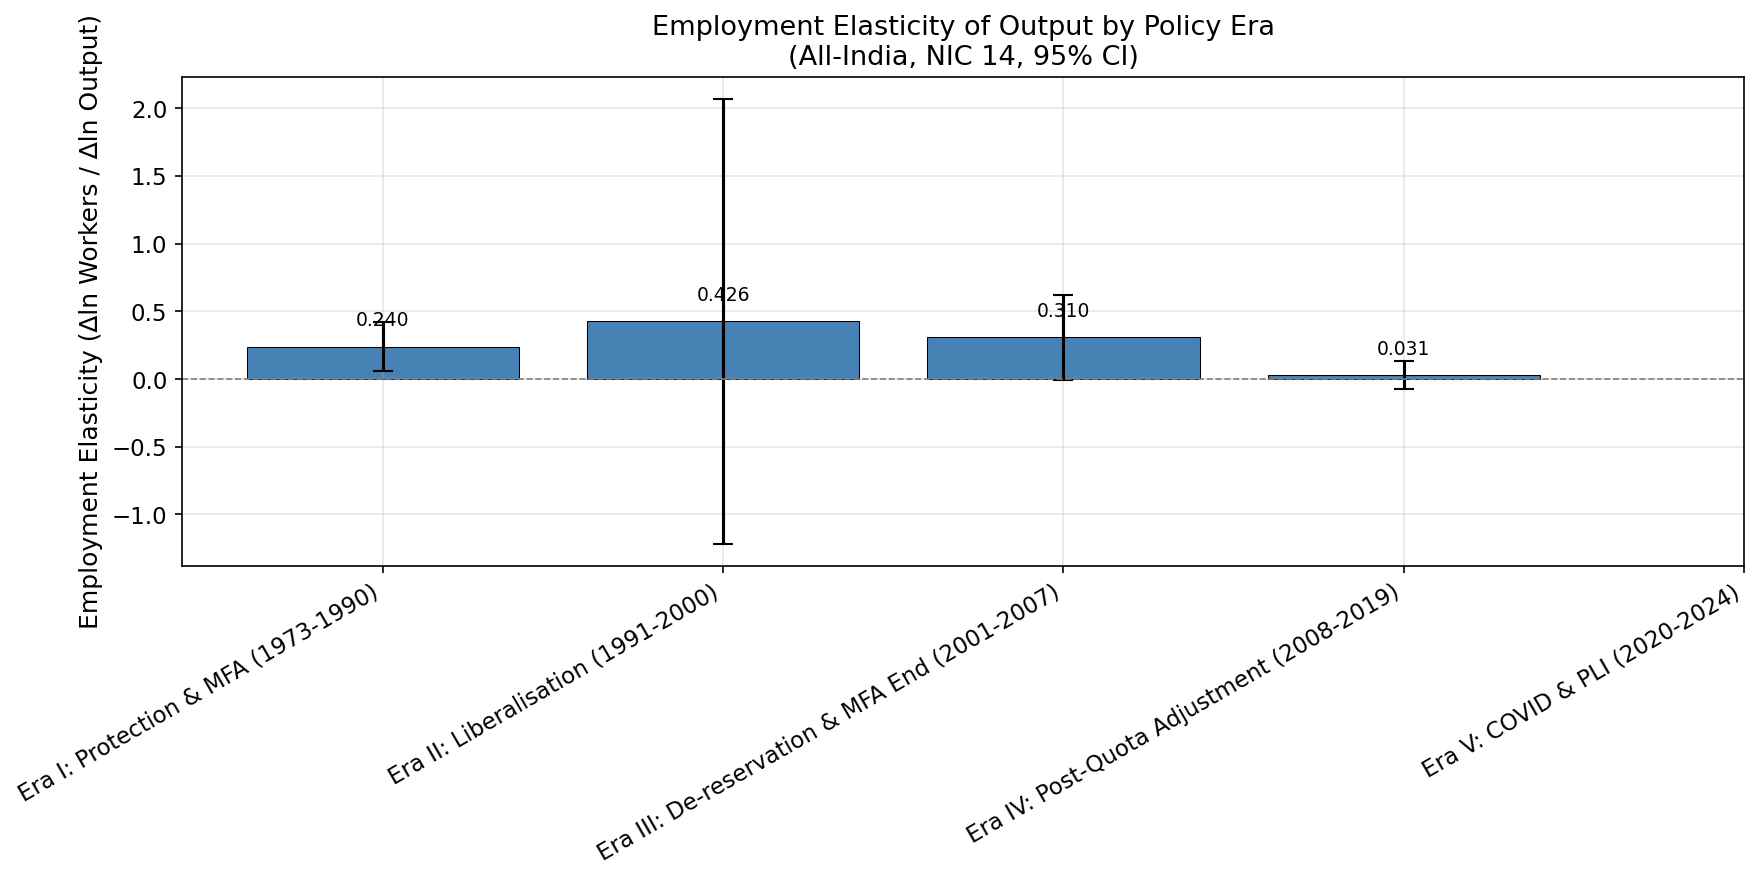


  Employment elasticity analysis complete.


In [103]:
# Employment Elasticity via Panel Regression
# ln(Workers) ~ ln(Real_Output) * C(era)  (era-specific slopes = elasticities)
# HC3 robust standard errors used throughout.
import statsmodels.api as sm
print('=' * 70)
print('Employment Elasticity: Output-Employment Nexus')
print('=' * 70)

# --- 1. All-India time series ---
print('\n[G.1] All-India Employment Elasticity (OLS on log-differences):')
ts = df[['YearStart', 'Workers', 'Real_Output']].dropna().copy()
ts['ln_W'] = np.log(ts['Workers'])
ts['ln_Y'] = np.log(ts['Real_Output'])
ts['dln_W'] = ts['ln_W'].diff()
ts['dln_Y'] = ts['ln_Y'].diff()
ts = ts.dropna()

# Assign era dummies
ts['era'] = 'Unknown'
for era_name, (s, e) in ERAS.items():
    ts.loc[ts['YearStart'].between(s, e), 'era'] = era_name

# Overall elasticity (pooled)
X_all = sm.add_constant(ts['dln_Y'])
mod_all = sm.OLS(ts['dln_W'], X_all).fit(cov_type='HC3')
print(f'  Pooled elasticity: {mod_all.params["dln_Y"]:.4f} '
      f'(SE={mod_all.bse["dln_Y"]:.4f}, p={mod_all.pvalues["dln_Y"]:.4f})')
print(f'  R² = {mod_all.rsquared:.4f}, N = {len(ts)}')

# Era-specific elasticity via interaction
print('\n  Era-specific elasticity (log-difference model):')
era_results = []
for era_name, (s, e) in ERAS.items():
    sub = ts[ts['era'] == era_name]
    if len(sub) >= 5:
        X_e = sm.add_constant(sub['dln_Y'])
        m_e = sm.OLS(sub['dln_W'], X_e).fit(cov_type='HC3')
        elast = m_e.params.get('dln_Y', np.nan)
        se = m_e.bse.get('dln_Y', np.nan)
        pv = m_e.pvalues.get('dln_Y', np.nan)
        era_results.append({
            'Era': era_name, 'Elasticity': elast, 'SE_HC3': se,
            'p_value': pv, 'N': len(sub), 'R2': m_e.rsquared
        })
        print(f'  {era_name}: ε = {elast:.4f} (SE={se:.4f}, p={pv:.4f}, N={len(sub)})')
    else:
        era_results.append({'Era': era_name, 'Elasticity': np.nan, 'SE_HC3': np.nan,
                            'p_value': np.nan, 'N': len(sub), 'R2': np.nan})
        print(f'  {era_name}: insufficient observations ({len(sub)})')

era_elas_df = pd.DataFrame(era_results)

# --- 2. Full interaction model ---
print('\n[G.2] Full interaction model (era × ln_output):')
ts_interac = ts.copy()
ts_interac['era_cat'] = pd.Categorical(ts_interac['era'],
    categories=[v for v in ERAS.keys()], ordered=True)
# Use formulaic approach
formula_data = ts_interac.dropna(subset=['dln_W', 'dln_Y', 'era_cat'])
if len(formula_data) >= 10:
    from statsmodels.formula.api import ols as smf_ols
    mod_interact = smf_ols('dln_W ~ dln_Y * C(era_cat)', data=formula_data).fit(cov_type='HC3')
    print(mod_interact.summary().tables[1])

# --- 3. State panel employment elasticity ---
print('\n[G.3] State Panel Employment Elasticity:')
if 'states_panel' in dir() and len(states_panel) > 0:
    sp = states_panel.copy()

    # Normalize state identifier column name.
    if 'StateName' not in sp.columns:
        if 'State' in sp.columns:
            sp = sp.rename(columns={'State': 'StateName'})
        else:
            state_like = [c for c in sp.columns if 'state' in c.lower()]
            raise KeyError(
                'Upgrade G expects a state identifier column named StateName (or State). '
                f'Found state-like columns: {state_like}'
            )

    sp['ln_W'] = np.log(sp['Workers'].replace(0, np.nan))
    sp['ln_Y'] = np.log(sp['Real_Output'].replace(0, np.nan))
    sp = sp.dropna(subset=['ln_W', 'ln_Y'])
    sp = sp.sort_values(['StateName', 'YearStart'])
    sp['dln_W'] = sp.groupby('StateName')['ln_W'].diff()
    sp['dln_Y'] = sp.groupby('StateName')['ln_Y'].diff()
    sp = sp.dropna(subset=['dln_W', 'dln_Y'])

    print(f'  State panel observations: {len(sp)}')
    print(f'  States: {sp["StateName"].nunique()}')

    # Pooled panel OLS with state fixed effects
    sp['era'] = 'Unknown'
    for era_name, (s, e) in ERAS.items():
        sp.loc[sp['YearStart'].between(s, e), 'era'] = era_name

    state_era_results = []
    for era_name, (s, e) in ERAS.items():
        sub_sp = sp[sp['era'] == era_name]
        if len(sub_sp) >= 10:
            X_sp = sm.add_constant(sub_sp['dln_Y'])
            m_sp = sm.OLS(sub_sp['dln_W'], X_sp).fit(cov_type='HC3')
            elast_sp = m_sp.params.get('dln_Y', np.nan)
            se_sp = m_sp.bse.get('dln_Y', np.nan)
            pv_sp = m_sp.pvalues.get('dln_Y', np.nan)
            state_era_results.append({
                'Era': era_name, 'Panel_Elasticity': elast_sp,
                'SE_HC3': se_sp, 'p_value': pv_sp, 'N_obs': len(sub_sp),
            })
            print(f'  {era_name} (panel): ε = {elast_sp:.4f} (SE={se_sp:.4f}, N={len(sub_sp)})')
        else:
            state_era_results.append({'Era': era_name, 'Panel_Elasticity': np.nan,
                                      'SE_HC3': np.nan, 'p_value': np.nan, 'N_obs': len(sub_sp)})
            print(f'  {era_name} (panel): insufficient obs ({len(sub_sp)})')

    state_elas_df = pd.DataFrame(state_era_results)
    # Merge all-india and panel
    elas_merged = era_elas_df.merge(state_elas_df, on='Era', how='outer', suffixes=('_AllIndia', '_Panel'))
    elas_merged.to_csv(TABLE_DIR / 'Table_EmploymentElasticity_Regression.csv', index=False)
    print(f'\n  Saved: Table_EmploymentElasticity_Regression.csv')
else:
    print('  states_panel not available; skipping panel elasticity.')
    era_elas_df.to_csv(TABLE_DIR / 'Table_EmploymentElasticity_Regression.csv', index=False)
    print(f'\n  Saved: Table_EmploymentElasticity_Regression.csv (All-India only)')

# --- 4. Elasticity bar chart ---
fig, ax = plt.subplots(figsize=(12, 6))
x_pos = np.arange(len(era_elas_df))
valid = era_elas_df['Elasticity'].notna()
colors = ['steelblue' if e > 0 else 'salmon' for e in era_elas_df['Elasticity'].fillna(0)]
ax.bar(x_pos[valid], era_elas_df.loc[valid, 'Elasticity'], yerr=era_elas_df.loc[valid, 'SE_HC3'] * 1.96,
       color=[colors[i] for i in range(len(colors)) if valid.iloc[i]],
       capsize=5, edgecolor='black', linewidth=0.5)
ax.set_xticks(x_pos)
ax.set_xticklabels(era_elas_df['Era'], rotation=30, ha='right')
ax.axhline(0, color='gray', ls='--', lw=0.8)
ax.set_ylabel('Employment Elasticity (∆ln Workers / ∆ln Output)')
ax.set_title('Employment Elasticity of Output by Policy Era\n(All-India, NIC 14, 95% CI)')
for i, row in era_elas_df[valid].iterrows():
    ax.annotate(f'{row["Elasticity"]:.3f}', (i, row['Elasticity']),
                textcoords='offset points', xytext=(0, 10), ha='center', fontsize=9)
plt.tight_layout()
plt.savefig(FIG_DIR / 'Fig_ElasticityRegression.png', bbox_inches='tight')
plt.show()

print('\n  Employment elasticity analysis complete.')


In [104]:
# FINAL OUTPUT SUMMARY
print('=' * 70)
print('ANALYSIS COMPLETE')
print('=' * 70)

n_figs = len(list(FIG_DIR.glob('*.png')))
n_tables = len(list(TABLE_DIR.glob('*.csv')))
print(f'\nOutputs generated:')
print(f'  Figures: {n_figs} PNG files in {FIG_DIR}')
print(f'  Tables:  {n_tables} CSV files in {TABLE_DIR}')

print('\nFigures:')
for f in sorted(FIG_DIR.glob('*.png')):
    print(f'  - {f.name}')

print('\nTables:')
for f in sorted(TABLE_DIR.glob('*.csv')):
    print(f'  - {f.name}')

print('\nAll blocks complete.')

ANALYSIS COMPLETE

Outputs generated:
  Figures: 28 PNG files in c:\Users\user\Downloads\EPWRF Clone\epwrf_downloader\division 14\output\figures
  Tables:  13 CSV files in c:\Users\user\Downloads\EPWRF Clone\epwrf_downloader\division 14\output\tables

Figures:
  - Fig01_RealGVA_Output.png
  - Fig02_Factories_Workers.png
  - Fig03_RealCapital_GFCF.png
  - Fig04_NominalVsRealGVA.png
  - Fig05_InputCostDecomposition.png
  - Fig06_Employment.png
  - Fig07_GenderComposition.png
  - Fig08_Contractualisation.png
  - Fig09_RealWagePerWorker.png
  - Fig10_WageProductivityGap.png
  - Fig11_Concentration_CR4_HHI.png
  - Fig12_StateProductivityRanking.png
  - Fig13_StateGenderComposition.png
  - Fig14_GrowthDecomposition.png
  - Fig15_TermsOfTrade.png
  - Fig_BetaConvergence.png
  - Fig_CapitalDeflator_Sensitivity.png
  - Fig_CapitalOutputRatio.png
  - Fig_ElasticityRegression.png
  - Fig_ExportIntensity.png
  - Fig_ExportTrend.png
  - Fig_InvestmentIntensity_ATUFS.png
  - Fig_LabourShareGVA.png
 